In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pyhive import hive
import json
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import ortools 

import warnings

from scipy.stats import mannwhitneyu, ks_2samp
from scipy.optimize import LinearConstraint, Bounds, minimize
from tqdm.notebook import tqdm


In [3]:
# create sql engine
def get_engine():
    database='sergey_morozov'#'bmb_analitic'
    host='dc-analytics.russianpost.ru'
    port=10000
    user = "Sergey-Morozov"
    password = "Gfqnjy#.6" # ""

    # SQLAlchemy with LDAP
    engine = create_engine(
        f'hive://{user}:{password}@{host}:10000/{database}',
        connect_args={'auth': 'CUSTOM'})

    connection = engine.connect()
    return engine



# process query and get data
def get_data(engine, query):
    
    return pd.read_sql_query(query, engine)
    #return query
    
    
        
def plotTreeCoefficients(model, feature_names):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.feature_importances_, feature_names)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1).iloc[:10]
    
    plt.figure(figsize=(12, 8))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.show()
        

def plotCoefficients(model,feature_names, title=''):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, feature_names)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1).iloc[:10]
    
    plt.figure(figsize=(8, 8))
    coefs.coef.plot(kind='bar')
    plt.title(title)
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.show()
        
def regression_qlt(y_true, y_pred):
    print('MAE: {:.4f}'.format(mean_absolute_error(y_true, y_pred)))
    print('MSE: {:.4f}'.format(mean_squared_error(y_true, y_pred)))
    print('R^2: {:.4f}'.format(r2_score(y_true, y_pred)))

In [4]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats
import matplotlib.pyplot as plt


def fit_dist(y, title=''):

    # Create an index array (x) for data

    x = np.arange(0,np.percentile(y,99), 0.1)
    size = len(y)
   

    #sc=StandardScaler() 
    #y_std = sc.fit_transform(y.reshape(-1,1))
    #y_std = y_std.flatten()
    y_std = y


    dist_names = ['beta',
                  'expon',
                  'gamma',
                  'lognorm',
                  'norm',
                  'pearson3',
                  'triang',
                  'uniform',
                  'weibull_min', 
                  'weibull_max']

    # Set up empty lists to stroe results
    chi_square = []
    p_values = []

    # Set up 50 bins for chi-square test
    # Observed data will be approximately evenly distrubuted aross all bins
    percentile_bins = np.linspace(0, 100, 51)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)

        # Obtain the KS test P statistic, round it to 5 decimal places
        p = scipy.stats.kstest(y_std, distribution, args=param)[1]
        p = np.around(p, 5)
        p_values.append(p)    

        # Get expected counts in percentile bins
        # This is based on a 'cumulative distrubution function' (cdf)
        cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                              scale=param[-1])
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # calculate chi-squared
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
        chi_square.append(ss)
        
        

    # Collate results and sort by goodness of fit (best at top)

    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square
    results['p_value'] = p_values
    results.sort_values(['chi_square'], inplace=True)

    # Report results

    print ('\nDistributions sorted by goodness of fit:')
    print ('----------------------------------------')
    print (results)


    # Divide the observed data into 100 bins for plotting (this can be changed)
    number_of_bins = 50
    bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99), number_of_bins)

    # Create the plot
    plt.figure(figsize=(8,6))
    sns.distplot(y, bins = number_of_bins)

    # Get the top three distributions from the previous phase
    number_distributions_to_plot = 1
    dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

    # Create an empty list to stroe fitted distribution parameters
    parameters = []

    # Loop through the distributions ot get line fit and paraemters

    for dist_name in dist_names:
        # Set up distribution and store distribution paraemters
        dist = getattr(scipy.stats, dist_name)
        param = dist.fit(y)
        parameters.append(param)

        # Get line for each distribution (and scale to match observed data)
        pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
        
        # Add the line to the plot
        #exp = dist(param).expect()
        exp = dist.ppf(0.85, *param[:-2], loc=param[-2], scale=param[-1])
        plt.plot(x, pdf_fitted, label=dist_name + ': {:.2f}'.format(exp))
        plt.title(title)
        plt.axvline(exp)
        # Set the plot x axis to contain 99% of the data
        # This can be removed, but sometimes outlier data makes the plot less clear
        plt.xlim(0,np.percentile(y,99))

    # Add legend and display plot
    plt.grid()
    plt.xlabel('Время обработки, дней')
    plt.ylabel('Вероятность')
    plt.legend()
    plt.show()

    # Store distribution paraemters in a dataframe (this could also be saved)
    dist_parameters = pd.DataFrame()
    dist_parameters['Distribution'] = (
            results['Distribution'].iloc[0:number_distributions_to_plot])
    dist_parameters['Distribution parameters'] = parameters

    # Print parameter results
    print ('\nDistribution parameters:')
    print ('------------------------')

    for index, row in dist_parameters.iterrows():
        print ('\nDistribution:', row[0])
        print ('Parameters:', row[1] )
        
    return dist_name, param


def get_percent_time(model, percentile=0.85):
    dist_name, param = model
    dist = getattr(scipy.stats, dist_name)
    exp = dist.ppf(percentile, *param[:-2], loc=param[-2], scale=param[-1])
    return exp

## 1. Загружаем данные по входным потокам

In [17]:
%%time
engine = get_engine()
query = "select * from bmb_analitic.shoulders_for_morozov_12month_ali_in_out_dayfull" 
in_out_streams_days = get_data(engine, query)
in_out_streams_days['date_'] = pd.to_datetime(in_out_streams_days['date_']).dt.date

CPU times: user 489 ms, sys: 16.8 ms, total: 506 ms
Wall time: 20.8 s


In [18]:
in_out_streams_days.tail()

date_      type_product mmpo_index  input_  output_
34995  2020-10-06  Посылка наземная     102975       0       14
34996  2020-10-06  Посылка наземная     420310       7      344
34997  2020-10-06  Посылка наземная     620980       0        0
34998  2020-10-06  Посылка наземная     630870       0        0
34999  2020-10-06  Посылка наземная     690980       0        0

In [19]:
mmpo = in_out_streams_days['mmpo_index'].unique()
mmpo

array(['102975', '420310', '620980', '630870', '690980'], dtype=object)

## Объемы при которых произведены наблюдения

In [435]:
for m in mmpo:
    temp = in_out_streams_days[(in_out_streams_days['mmpo_index']==m) &\
                        (in_out_streams_days['type_product'] == 'cPacket')]\
                        .set_index('date_')[['input_', 'output_']]
    if temp['input_'].sum() > 1e5:
        temp.plot(figsize=(16,2))
        plt.title(m)
        plt.ylabel('Количество, шт.')
        plt.grid()
        plt.show()

## 2. Загружаем данные о времени обработки по всем ММПО и всем продуктам

In [23]:
%%time
targets_all = {}
for prod in in_out_streams_days['type_product'].unique():
    targets_prod = {}
    
    for idx in mmpo:
        query = "select * from bmb_analitic.shoulders_for_morozov_12month_ali "+\
f"where bar_code_type = '{prod}' and b_index={idx} ORDER BY RAND() LIMIT 100000"

        target = get_data(engine, query)
        target['b_date_h'] = pd.to_datetime(target['b_date_h'])
        targets_prod[idx] = target
        
    targets_all[prod] = targets_prod

CPU times: user 5min 4s, sys: 3.56 s, total: 5min 7s
Wall time: 56min 16s


In [439]:
targets_all.keys()

dict_keys(['EMS', 'PH E2E', 'RDC', 'RDnR', 'RDnR Air', 'RDnR E2E', 'RDnR Ground', 'RM', 'RM Air', 'RM E2E', 'RM Ground', 'RM Letter Air', 'RM Letter Ground', 'RMH E2E', 'SRM', 'SRM Air', 'SRM E2E', 'SRM Ground', 'cPacket', 'domestic', 'ePacket_CN', 'ePacket_HK', 'Посылка', 'Посылка авиа', 'Посылка наземная'])

In [ ]:
targets_all

In [478]:
total_count = 0
full_count = 0
filtered_target ={}
for prod in targets_all.keys():
    filtred_prod = {}
    for idx in targets_all[prod].keys():
        total_count += 1
        if targets_all[prod][idx].shape[0] >= 50000:
            full_count += 1
            filtred_prod[idx] = targets_all[prod][idx]
            #print(prod, idx)
            #print(targets_all[prod][idx].shape)
            #print()
    filtered_target[prod] = filtred_prod
            
print("Total pairs:", total_count)
print("Full sets pairs:", full_count)

Total pairs: 525
Full sets pairs: 41


In [302]:
# # print total info about data
# for prod in filtered_target.keys():
#     print(prod)
#     print('-'*60)
#     for k in filtered_target[prod].keys():
#         print(k, filtered_target[prod][k].shape)
#     print('-'*60)
    
    

# for prod in filtered_target.keys():
#     print(prod)
#     print('-'*60)
#     for k in filtered_target[prod].keys():
#         if 'zone' in filtered_target[prod][k].columns:
#             print(k)
#             print(filtered_target[prod][k].groupby('zone')['rpo_bar_code'].count())
#             print('-'*60)
#             print()
#     print('-'*60)
#     print()

In [480]:
# load data about zone and regions
pre_sort_zone = pd.read_excel('./data/Сортирвка C-packet PRESORT 2019.xlsx')
pre_sort_zone = pre_sort_zone[['deg_3_idx', 'zone', 'Region in Russian']]
pre_sort_zone['deg_3_idx'] = pre_sort_zone['deg_3_idx'].astype('str')

zones = ['RU1', 'RU2', 'RU3', 'RU4', 'RU5', 'RU6', 'RU7', 'RU8']

In [481]:
# add zones and regions to data
for prod in filtered_target.keys():
    for k in filtered_target[prod].keys():
        temp = filtered_target[prod][k]
        temp['deg_3_idx'] = temp['d_index'].str[:3]
        temp = pd.merge(temp, pre_sort_zone, on='deg_3_idx') 
        filtered_target[prod][k] = temp

In [482]:
# calculate time in mmpo and om magistral route
for prod in filtered_target.keys():
    for k in filtered_target[prod].keys():
        temp = filtered_target[prod][k]
        temp['days_in_mmpo'] = temp['delta_in_hours'] / 24
        temp ['day_on_magistral'] = temp['day_reg_bag_place_of_delivery'] - temp['days_in_mmpo']
        filtered_target[prod][k] = temp

## Total product time processing distribution


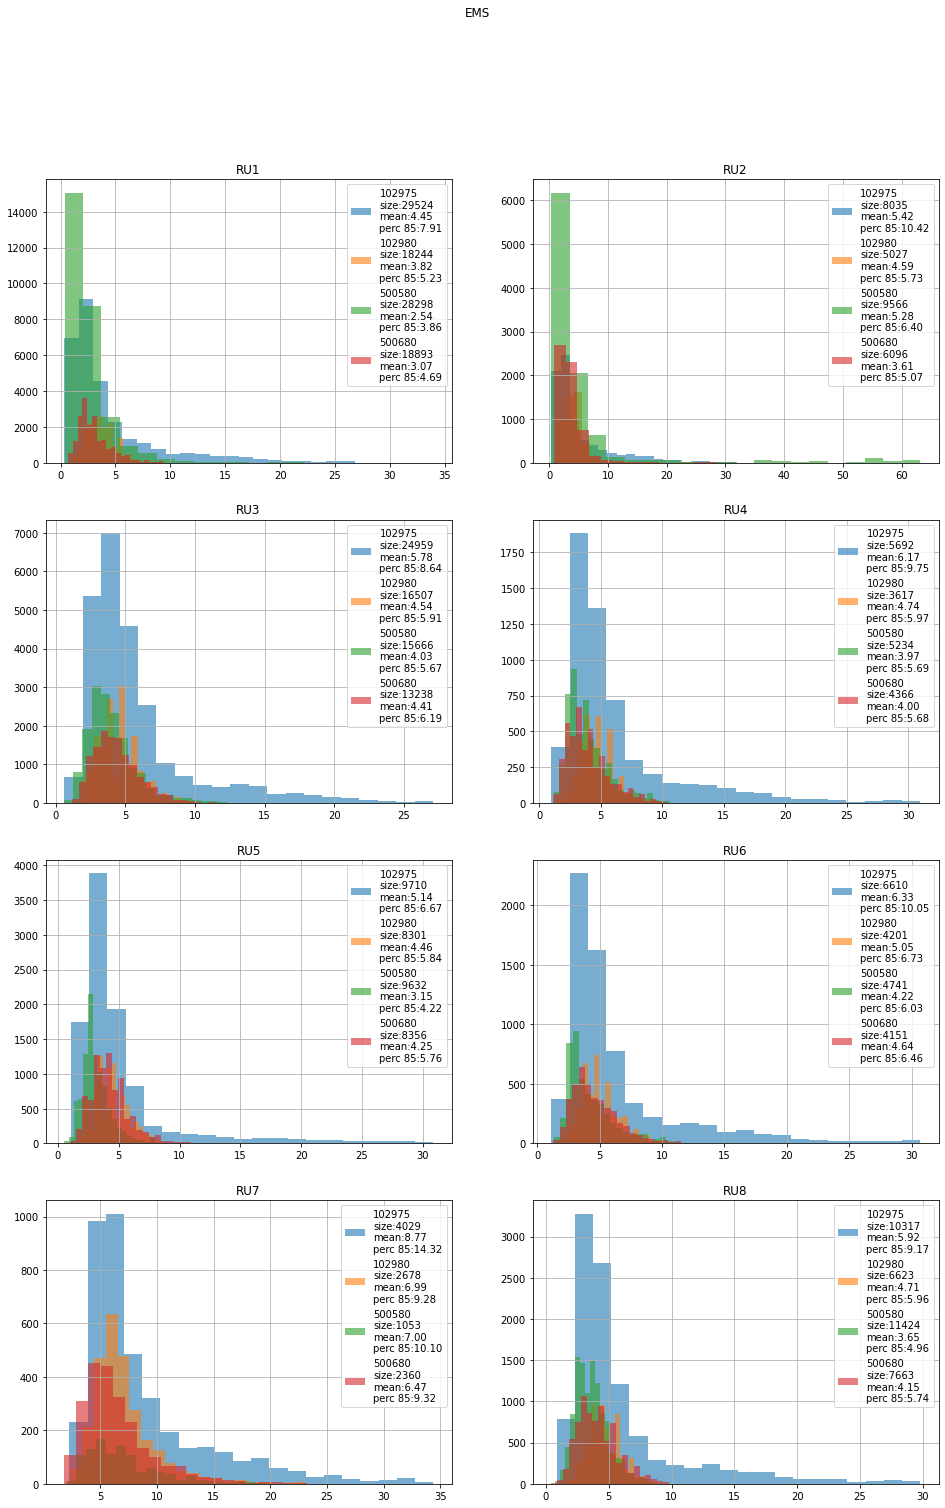

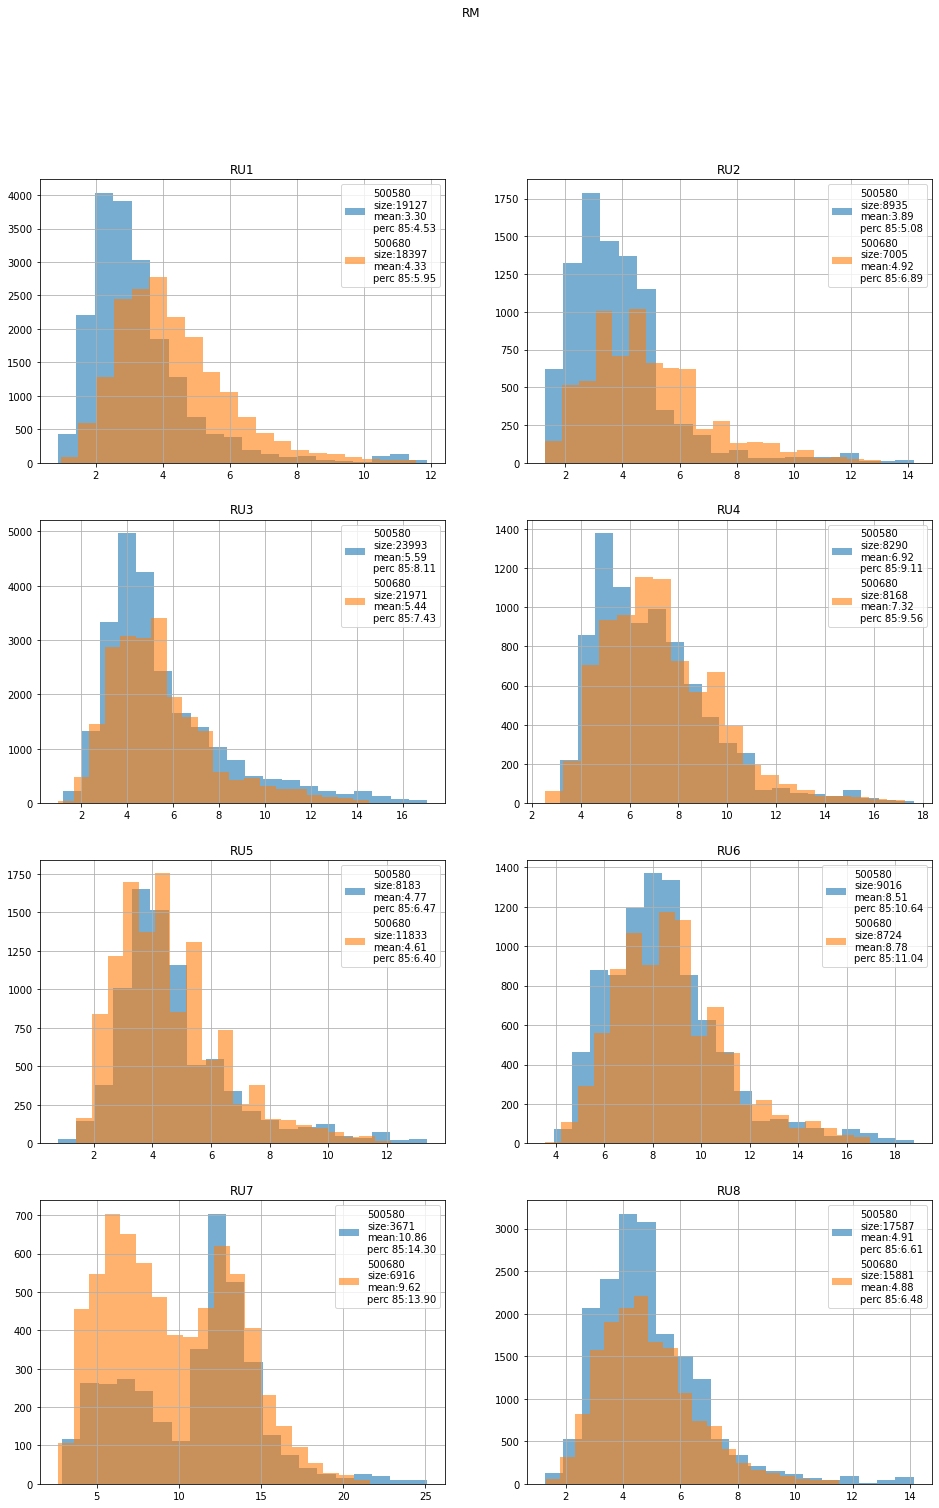

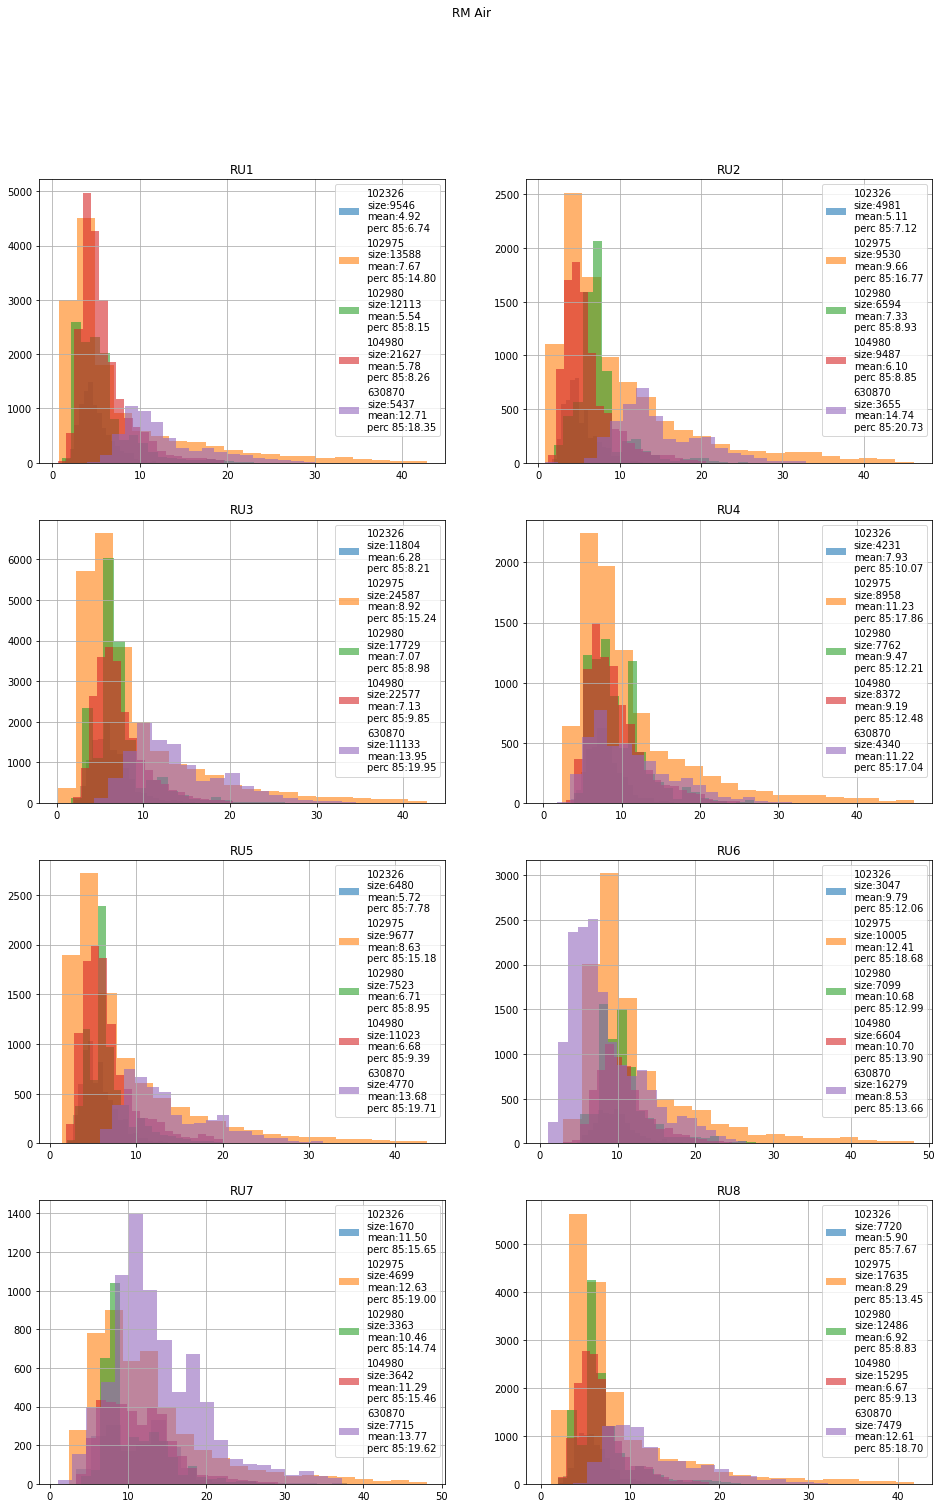

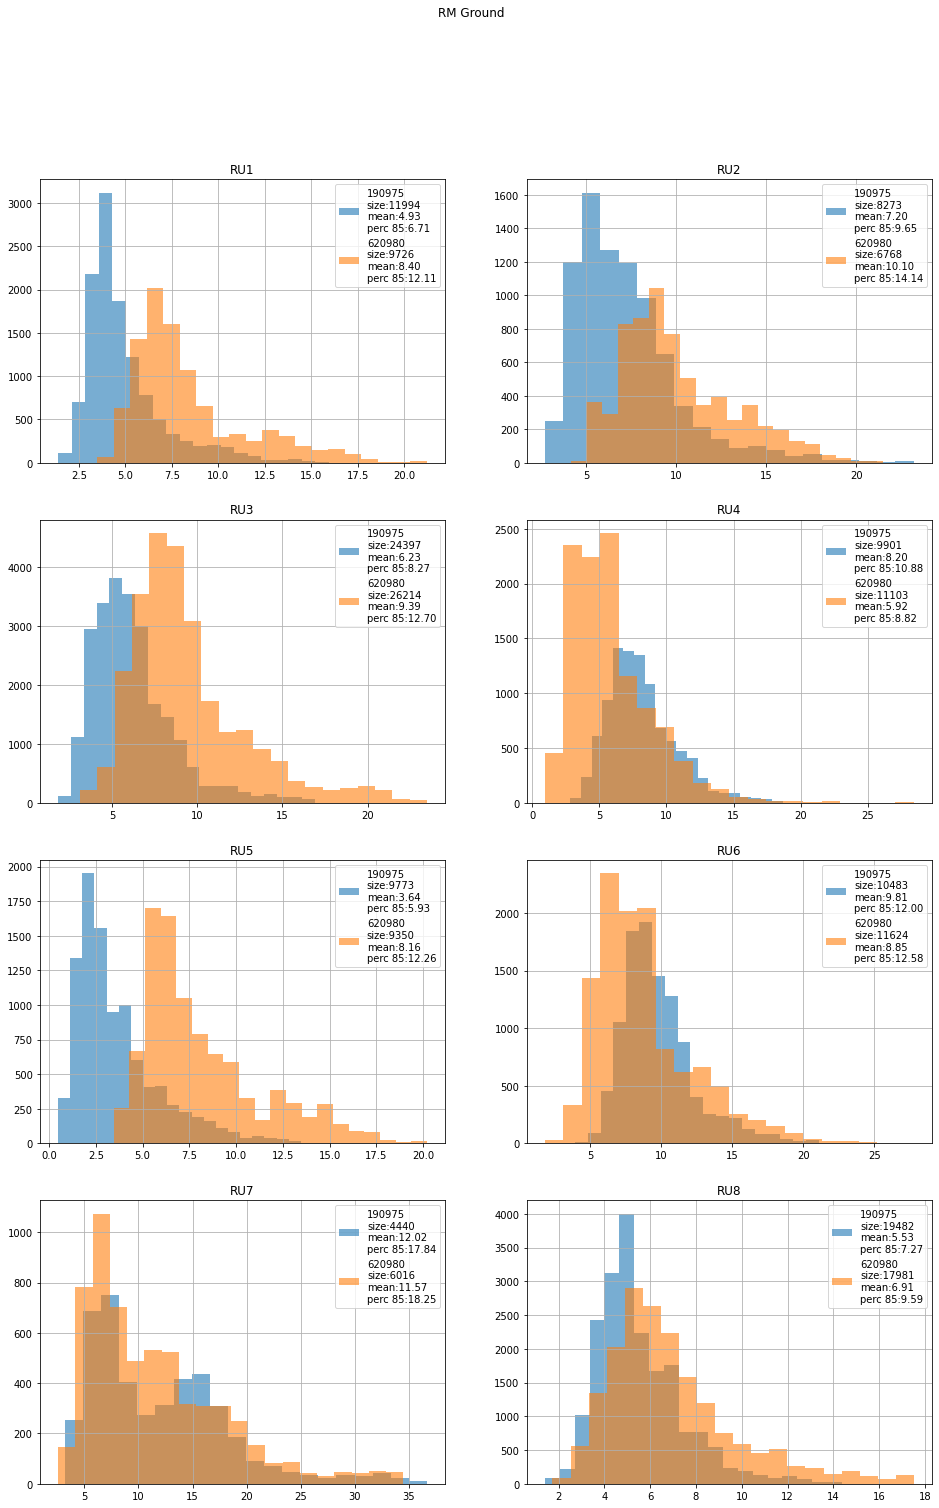

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


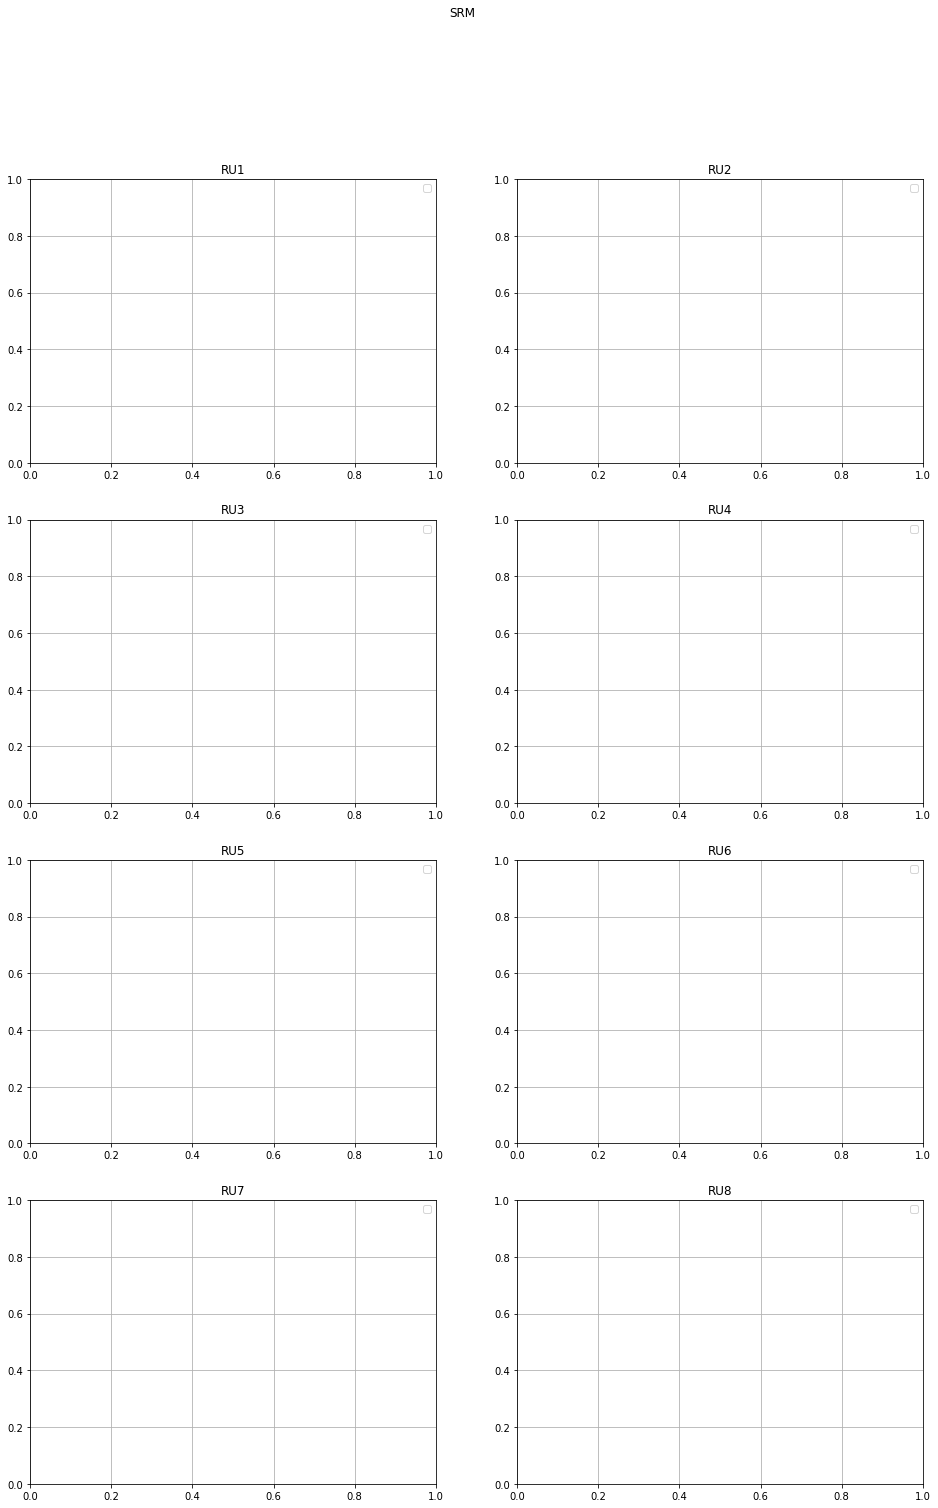

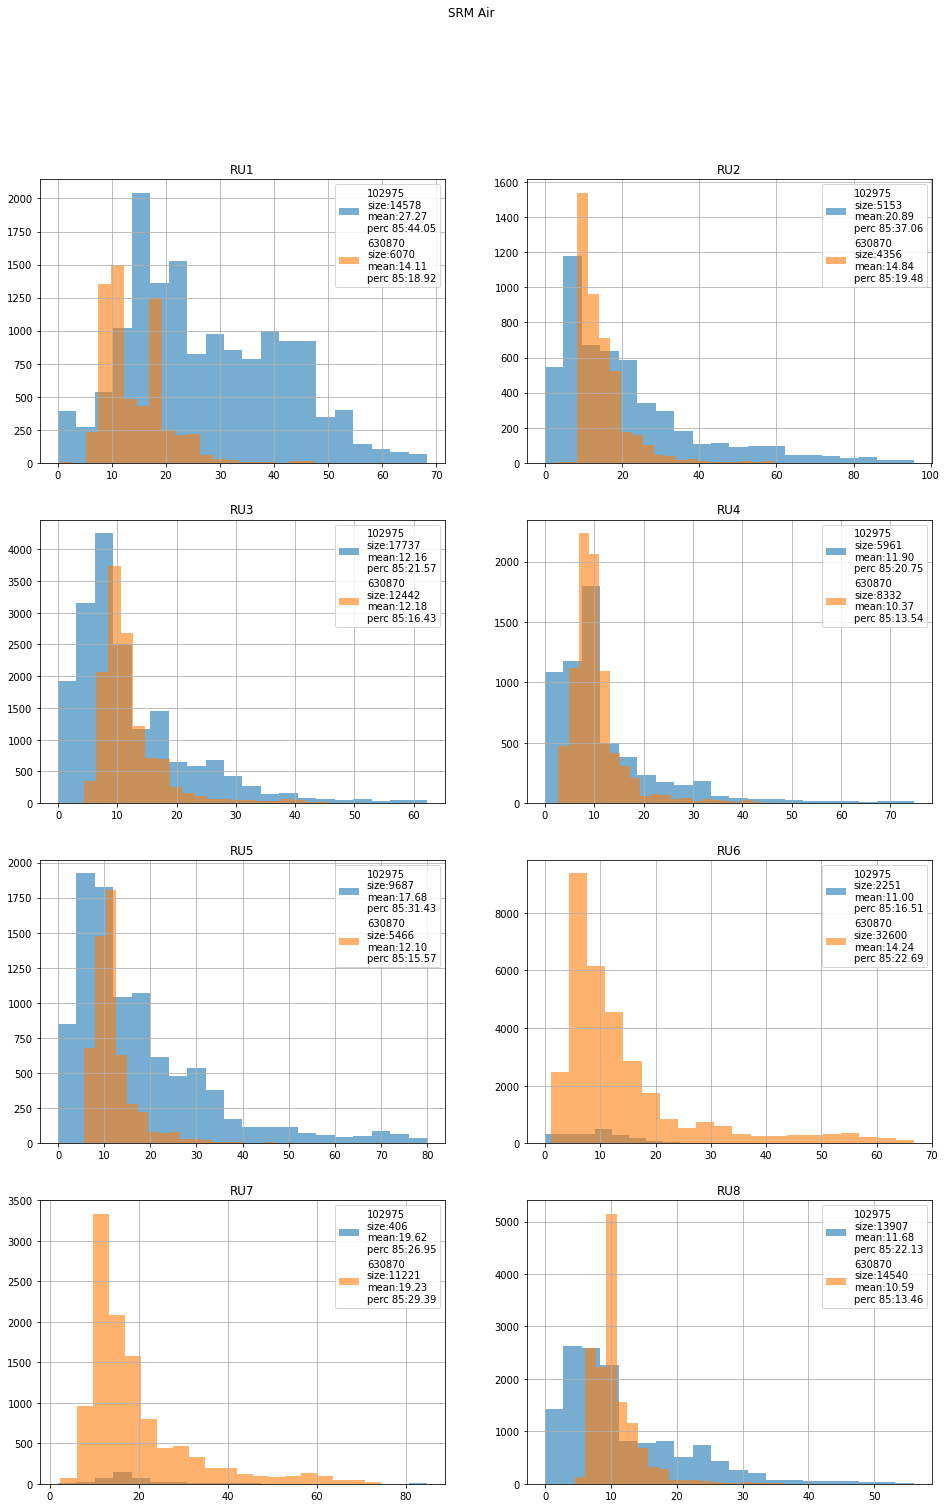

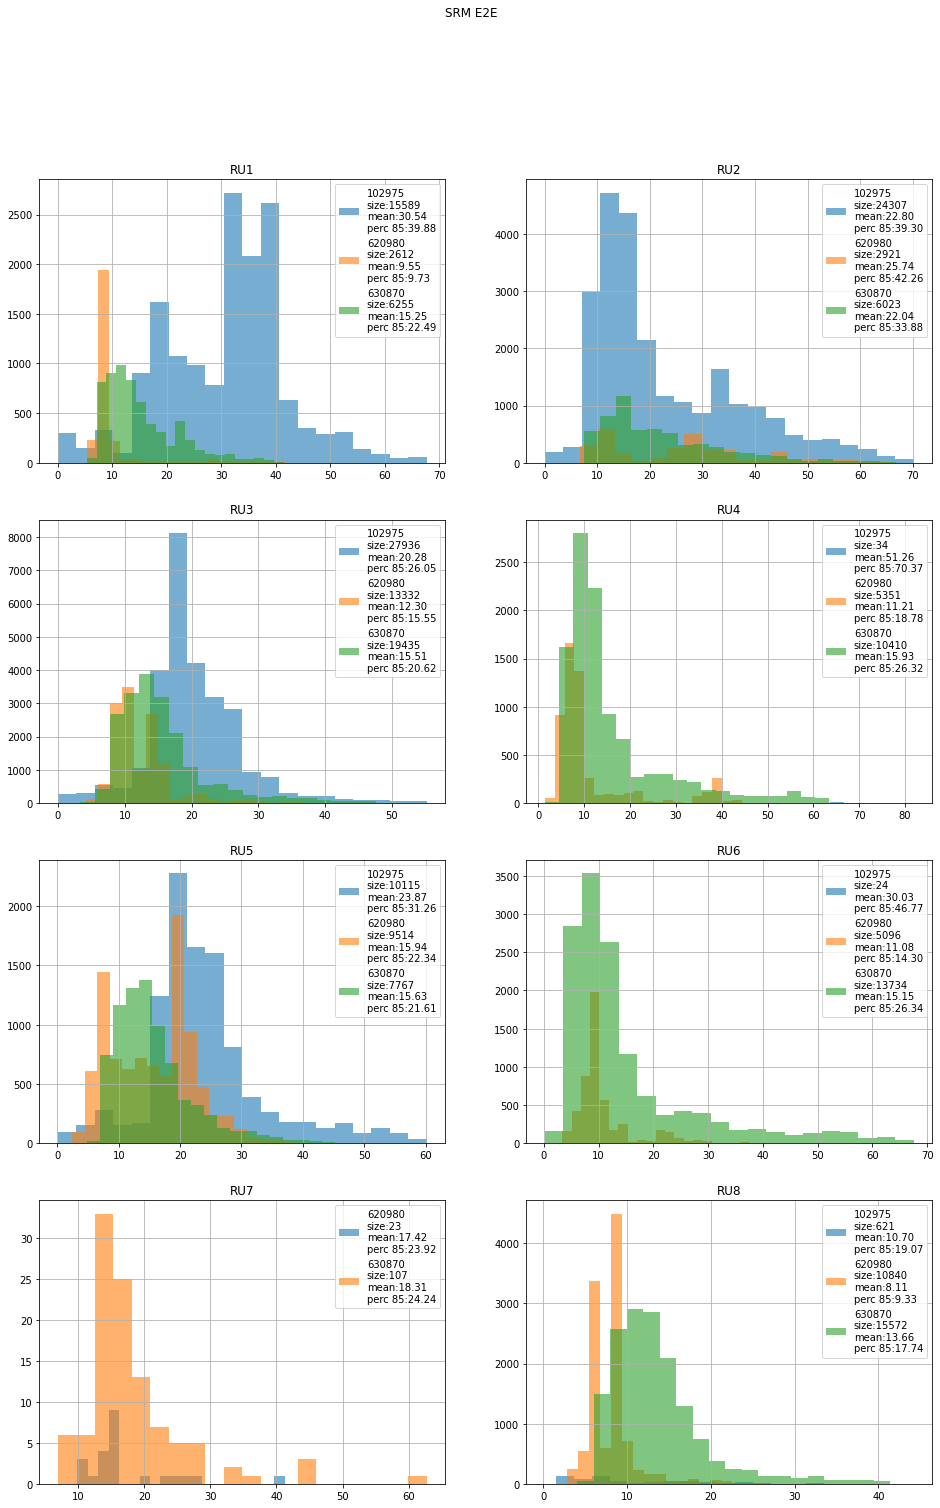

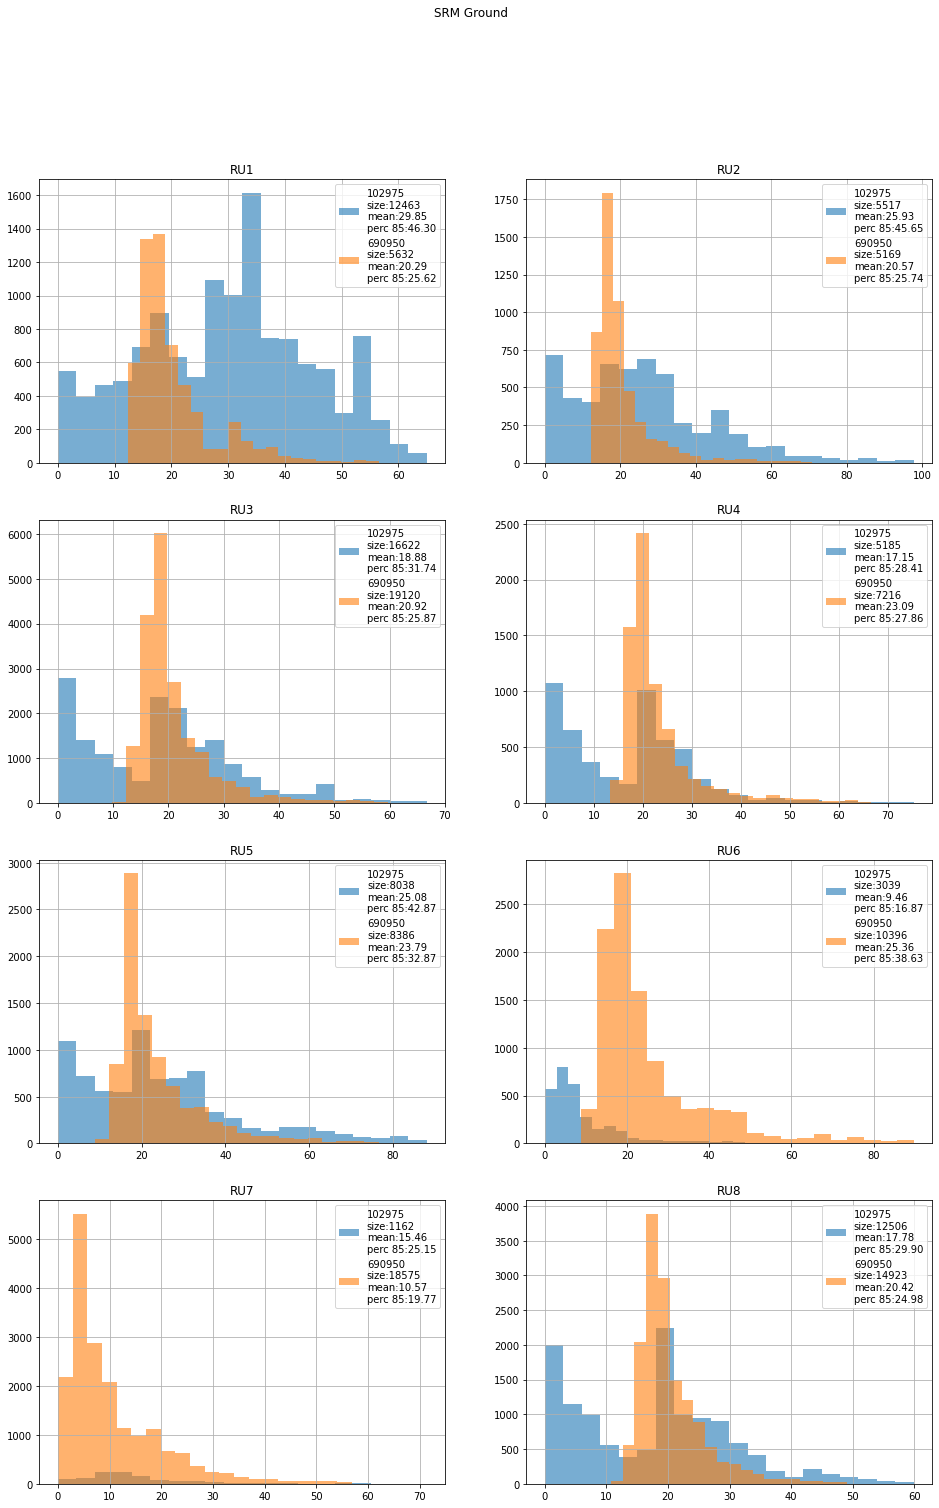

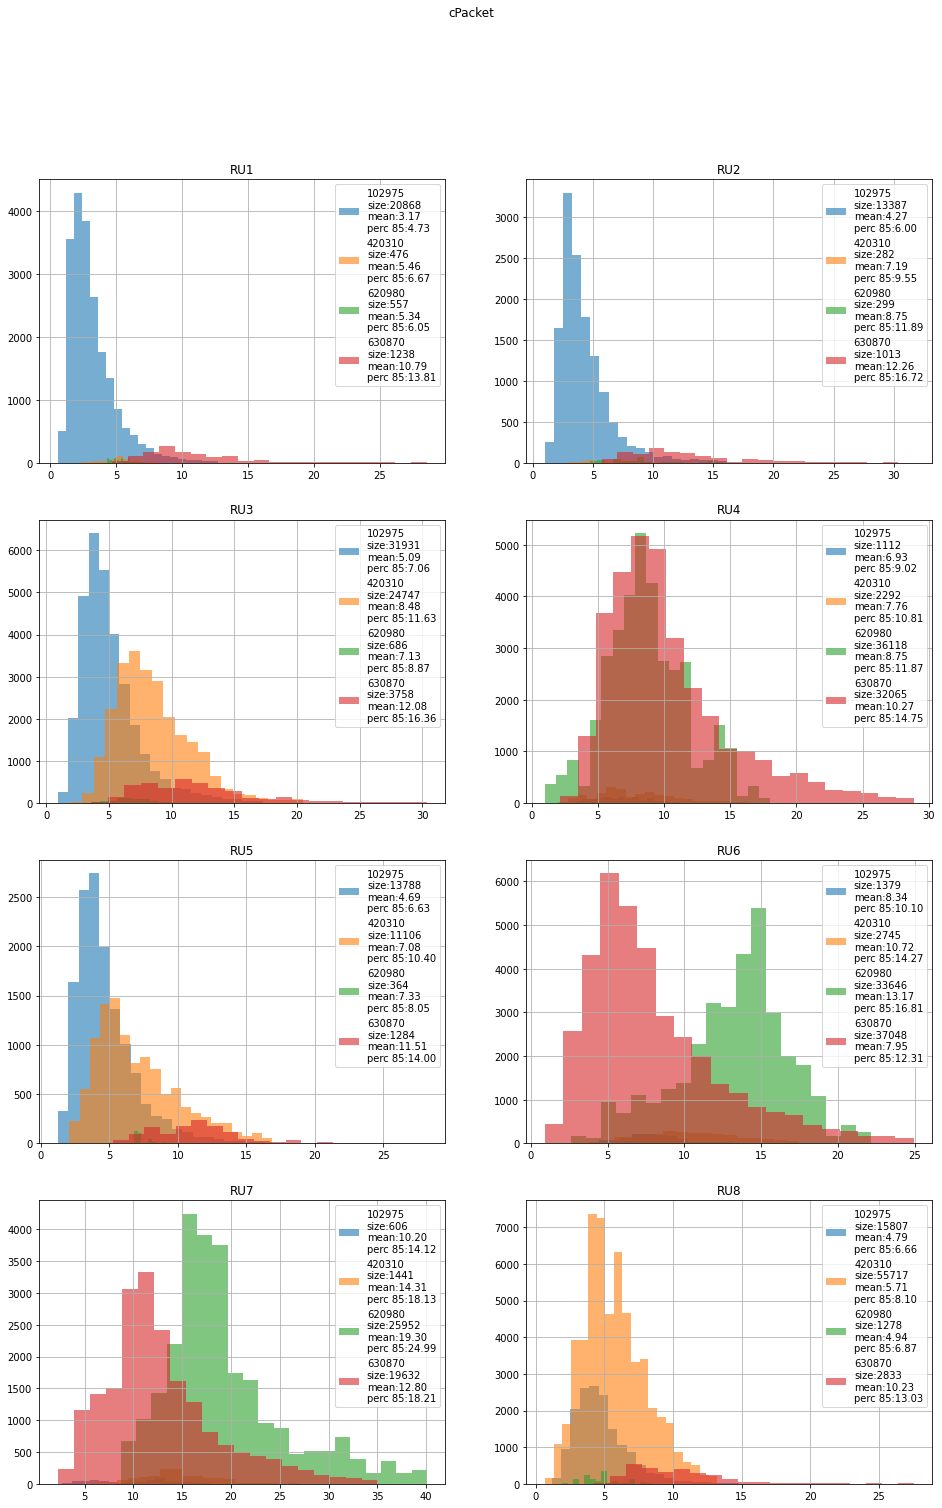

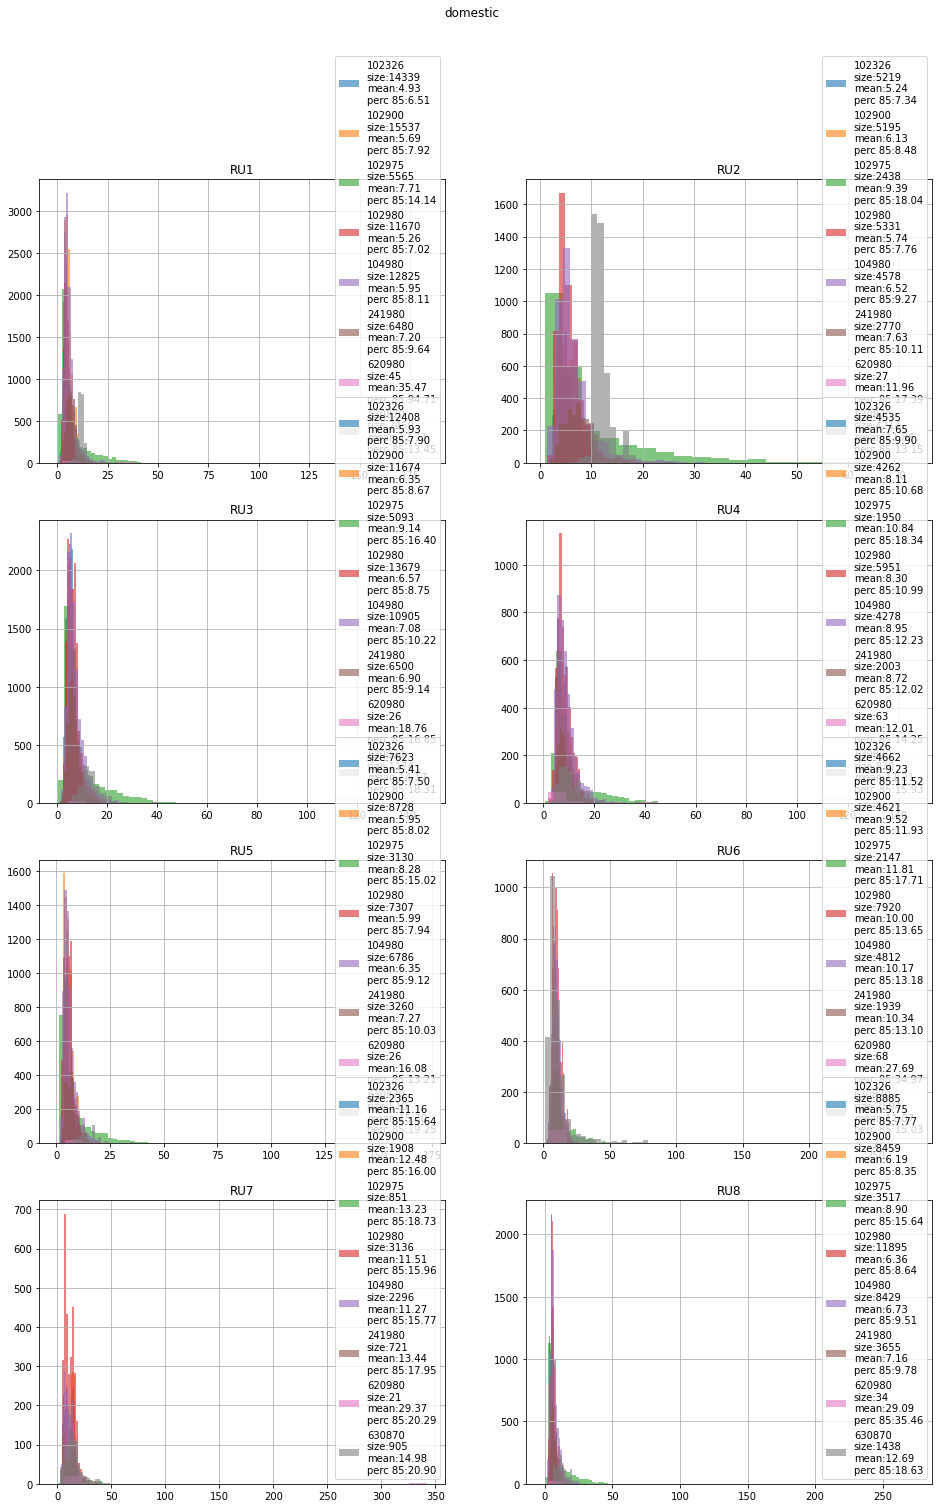

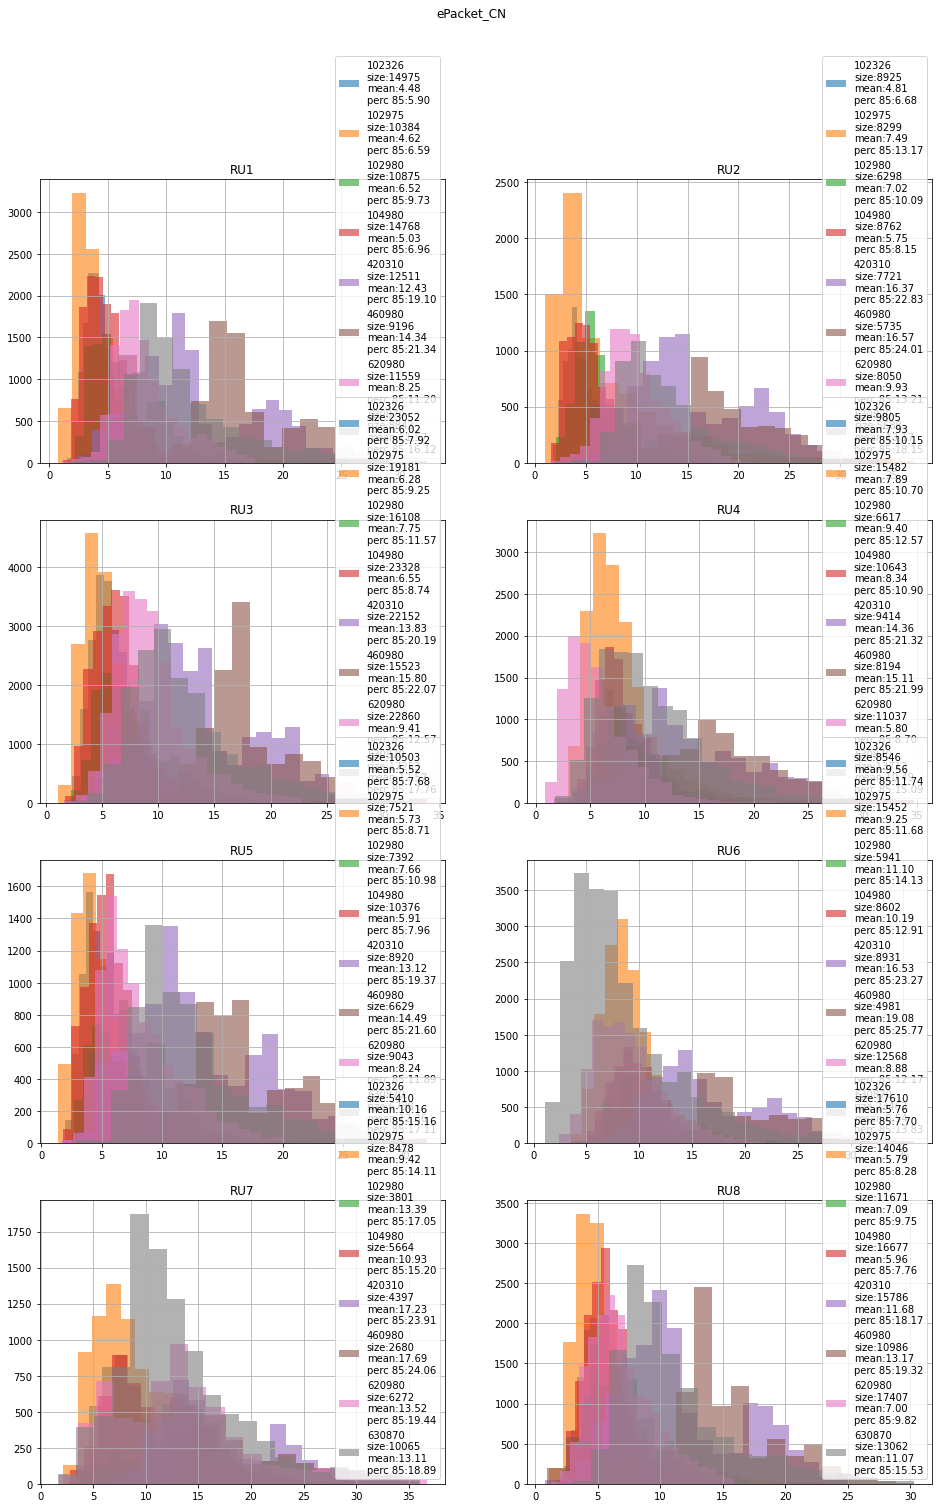

In [490]:
for prod in filtered_target.keys():
    if filtered_target[prod]:
        fig, axs = plt.subplots(4, 2, figsize=(16,24))
        for ax, zone in zip(axs.flatten(), zones):
            for k in filtered_target[prod].keys():
                sample = filtered_target[prod][k].query('zone == @zone')\
                        ['day_reg_bag_place_of_delivery'].dropna().values
                if len(sample) != 0:
                    
                    
                    sample = sample[(sample > 0) & (sample <= np.percentile(sample, 99))]
                    if len(sample) != 0:
                        ax.hist(sample, 
                                bins=20, 
                                alpha=0.6,        
                                label=k + '\nsize:{}'.format(len(sample)) +\
                                      '\nmean:{:.2f}'.format(np.mean(sample)) +\
                                      '\nperc 85:{:.2f}'.format(np.percentile(sample, 85)))

            ax.set_title(zone)
            ax.grid()
            ax.legend()
            
        fig.suptitle(prod)
        
        plt.show()
        #break

## cPacket by zone

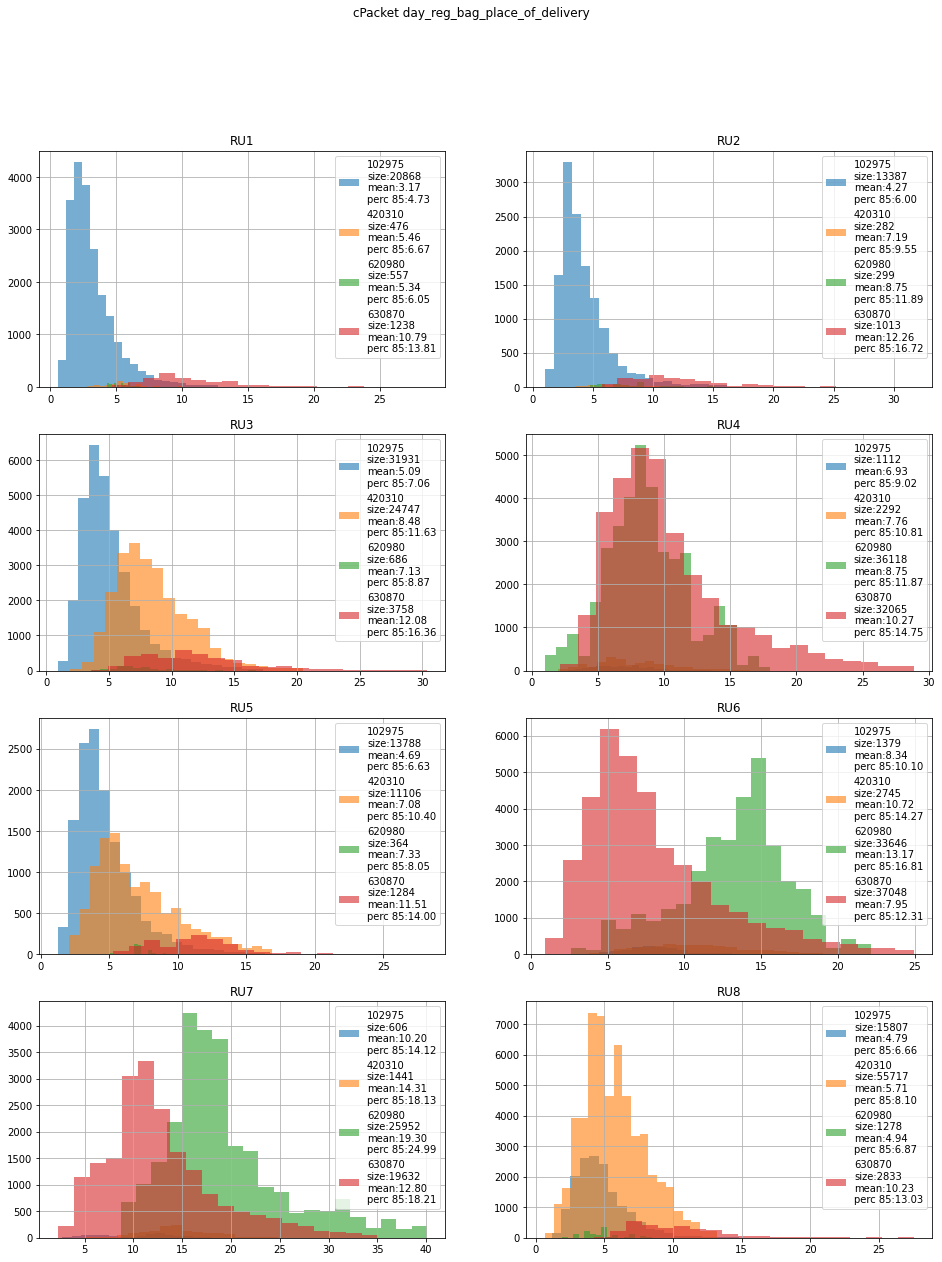

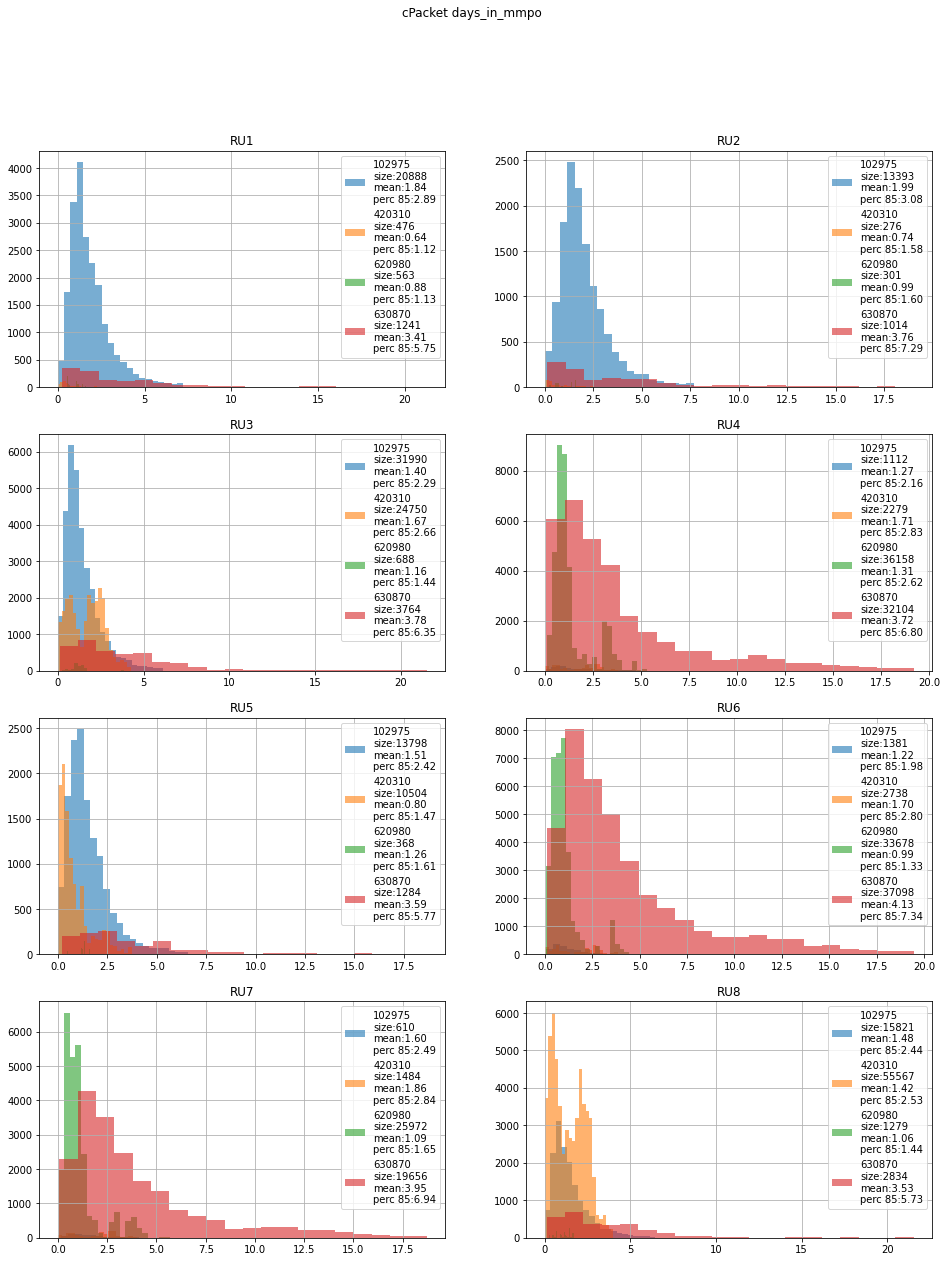

In [487]:
for prod in ['cPacket']:
    
        fig, axs = plt.subplots(4, 2, figsize=(16,20))
        for ax, zone in zip(axs.flatten(), zones):
            for k in filtered_target[prod].keys():
                sample = filtered_target[prod][k].query('zone == @zone')\
                        ['day_reg_bag_place_of_delivery'].dropna().values
                if len(sample) != 0:
                    
                    sample = sample[(sample > 0) & (sample <= np.percentile(sample, 99))]
                    
                    ax.hist(sample, 
                            bins=20, 
                            alpha=0.6,        
                            label=k + '\nsize:{}'.format(len(sample)) +\
                                  '\nmean:{:.2f}'.format(np.mean(sample)) +\
                                  '\nperc 85:{:.2f}'.format(np.percentile(sample, 85)))

                   

            ax.set_title(zone)
            ax.grid()
            ax.legend()
            
        fig.suptitle(prod +' day_reg_bag_place_of_delivery')
        plt.show()
        
        
for prod in ['cPacket']:
    
        fig, axs = plt.subplots(4, 2, figsize=(16,20))
        for ax, zone in zip(axs.flatten(), zones):
            for k in filtered_target[prod].keys():
                sample = filtered_target[prod][k].query('zone == @zone')\
                        ['days_in_mmpo'].dropna().values
                if len(sample) != 0:
                    
                    
                    sample = sample[(sample > 0) & (sample <= np.percentile(sample, 99))]
                    
                    ax.hist(sample, 
                            bins=20, 
                            alpha=0.6,        
                            label=k + '\nsize:{}'.format(len(sample)) +\
                                  '\nmean:{:.2f}'.format(np.mean(sample)) +\
                                  '\nperc 85:{:.2f}'.format(np.percentile(sample, 85)))

            ax.set_title(zone)
            ax.grid()
            ax.legend()
            
        fig.suptitle(prod + ' days_in_mmpo')
        
        plt.show()
        #break
    #break
    
for prod in ['cPacket']:
    
        fig, axs = plt.subplots(4, 2, figsize=(16,20))
        for ax, zone in zip(axs.flatten(), zones):
            for k in filtered_target[prod].keys():
                sample = filtered_target[prod][k].query('zone == @zone')\
                        ['day_on_magistral'].dropna().values
                if len(sample) != 0:
                    
                    
                    sample = sample[(sample > 0) & (sample <= np.percentile(sample, 99))]
                    
                    ax.hist(sample, 
                            bins=20, 
                            alpha=0.6,        
                            label=k + '\nsize:{}'.format(len(sample)) +\
                                  '\nmean:{:.2f}'.format(np.mean(sample)) +\
                                  '\nperc 85:{:.2f}'.format(np.percentile(sample, 85)))

            ax.set_title(zone)
            ax.grid()
            ax.legend()
            
        fig.suptitle(prod + ' day_on_magistral')
        
        plt.show()
        #break
    #break

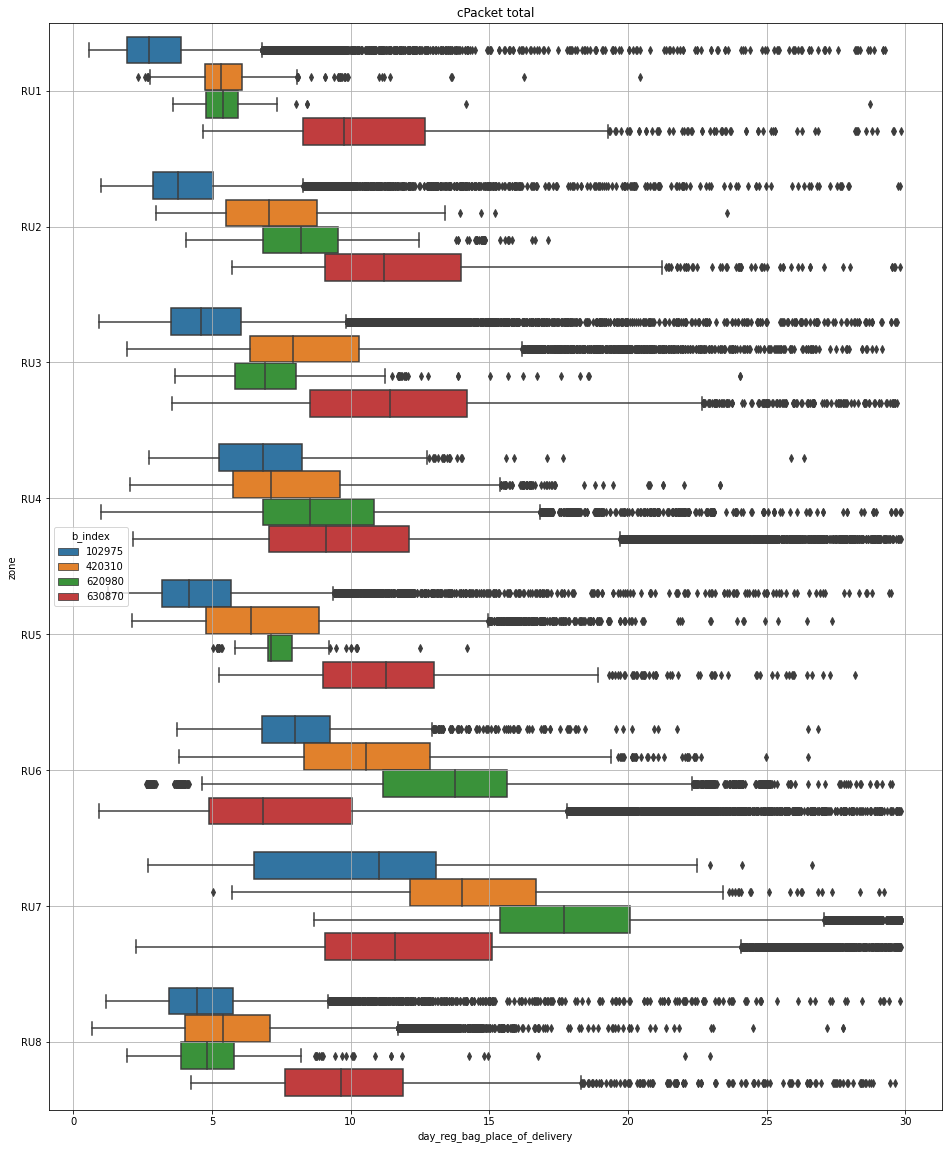

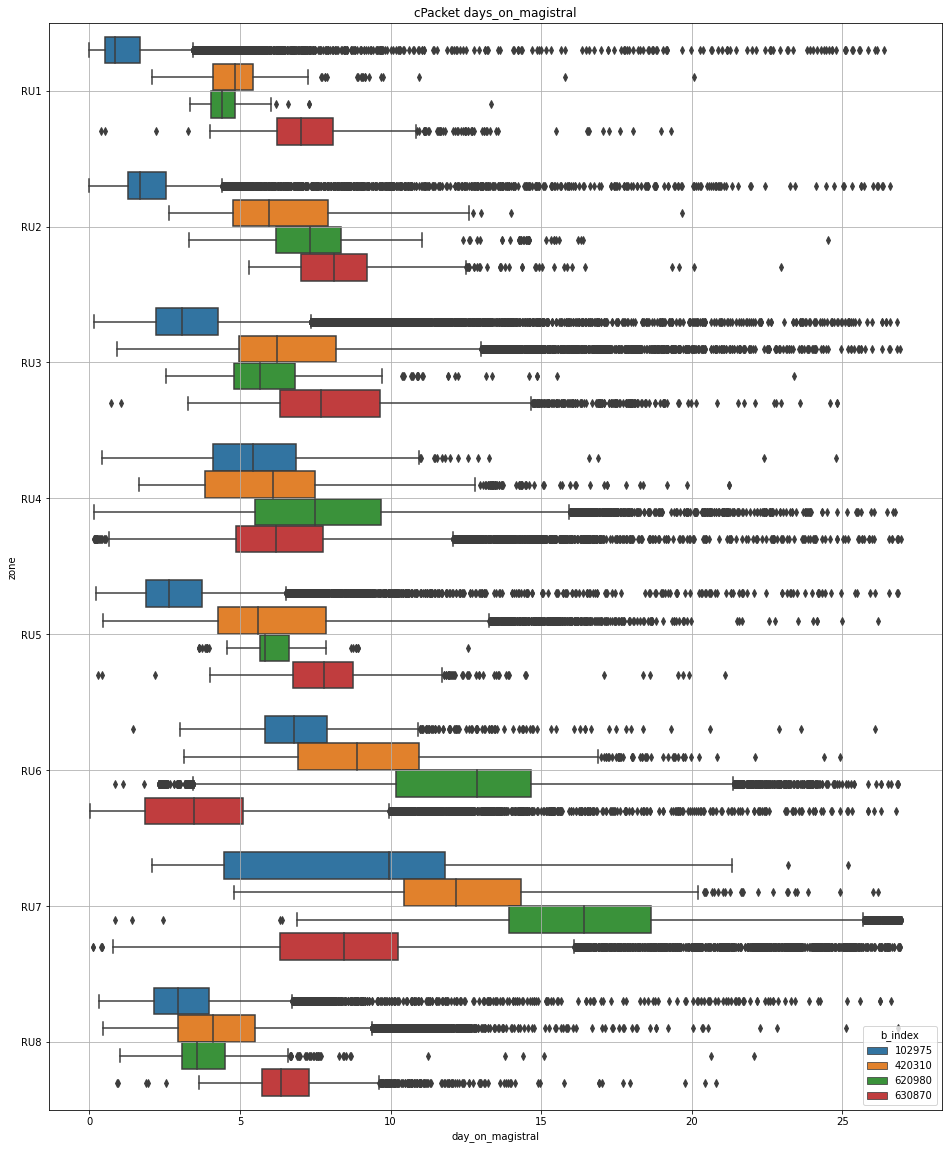

In [493]:
for prod in ['cPacket']:
        
        temp = []
        for k in filtered_target[prod].keys():
            temp.append(filtered_target[prod][k])
                
        temp = pd.concat(temp)

                   
        plt.figure(figsize=(16,20))
        sns.boxplot(x='day_reg_bag_place_of_delivery',
                    y='zone', 
                    hue='b_index', 
                    data=temp[(temp['day_reg_bag_place_of_delivery'] > 0) \
                              & (temp['day_reg_bag_place_of_delivery'] \
                                 <= np.percentile(temp['day_reg_bag_place_of_delivery'].dropna(), 99))], 
                    order=zones)
            
        plt.title(prod + ' total')
        plt.grid()
        plt.show()
        
        
        plt.figure(figsize=(16,20))
        sns.boxplot(x='days_in_mmpo',
                    y='zone', 
                    hue='b_index',
                    data=temp[(temp['days_in_mmpo'] > 0) \
                              & (temp['days_in_mmpo'] \
                                 <= np.percentile(temp['days_in_mmpo'].dropna(), 99))], 
                    order=zones)
            
        plt.title(prod + ' days_in_mmpo')
        plt.grid()
        plt.show()
        
        
        plt.figure(figsize=(16,20))
        sns.boxplot(x='day_on_magistral',
                    y='zone', 
                    hue='b_index', 
                    data=temp[(temp['day_on_magistral'] > 0) \
                              & (temp['day_on_magistral'] \
                                 <= np.percentile(temp['day_on_magistral'].dropna(), 99))], 
                    order=zones)
            
        plt.title(prod + ' days_on_magistral')
        plt.grid()
        plt.show()

In [664]:
filtered_target['cPacket']['102975'][['b_date_h', 'day_reg_bag_place_of_delivery', 
                                      'days_in_mmpo', 
                                      'day_on_magistral']].to_pickle('cPacket_102975_time.pckl')

In [668]:
in_out_streams_days[(in_out_streams_days['mmpo_index']=='102975') &\
                    (in_out_streams_days['type_product'] == 'cPacket')]\
                    [['date_', 'input_', 'output_']]\
                    .to_pickle('load_cpacket_102975.pckl')
                                                                            

In [407]:
#filtered_target['SRM Air']['102975'].query('day_reg_bag_place_of_delivery < 0').to_excel('srm_negative.xlsx')
#filtered_target[prod]['102975'].query('day_on_magistral < 0').to_excel('negative_cpacket_102975.xlsx')

## Fit distribution for time to zone

102975 RU1
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm   10101.259415      0.0
2        gamma   21530.630537      0.0
5     pearson3   21530.987375      0.0
0         beta   22036.564307      0.0
9  weibull_max   23320.269666      0.0
8  weibull_min   35630.192364      0.0
4         norm   79601.129288      0.0
1        expon  111517.949992      0.0
6       triang  167007.791963      0.0
7      uniform  264325.163117      0.0


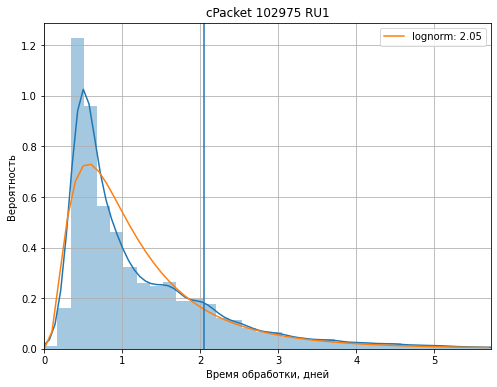


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.7210002408114216, -0.021418429152175438, 0.9802190818020498)

420310 RU1
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution   chi_square  p_value
4         norm    93.698009  0.01521
5     pearson3   114.986927  0.00339
2        gamma   114.989101  0.00339
3      lognorm   115.073291  0.00340
0         beta   118.191150  0.00267
8  weibull_min   132.456616  0.00102
6       triang   396.526024  0.00000
7      uniform  1271.903074  0.00000
1        expon  3088.315708  0.00000
9  weibull_max  8642.774489  0.00000


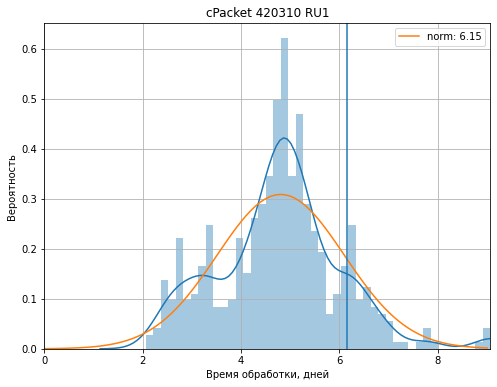


Distribution parameters:
------------------------

Distribution: norm
Parameters: (4.805984720277, 1.2928334850511414)

620980 RU1
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution   chi_square  p_value
2        gamma   141.461440  0.01581
5     pearson3   141.465656  0.01576
0         beta   142.278250  0.02491
3      lognorm   145.621976  0.00683
9  weibull_max   151.520961  0.00552
8  weibull_min   197.053547  0.00489
4         norm   272.179435  0.00004
6       triang   404.600520  0.00025
7      uniform  1747.825669  0.00000
1        expon  7165.536585  0.00000


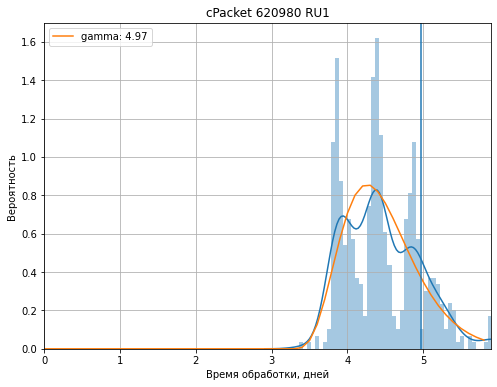


Distribution parameters:
------------------------

Distribution: gamma
Parameters: (6.077826513782673, 3.2243716573360652, 0.2035583119487926)

630870 RU1
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
9  weibull_max    257.819499  0.00003
3      lognorm    259.346873  0.00001
5     pearson3    295.418202  0.00000
2        gamma    295.452155  0.00000
0         beta    309.006720  0.00000
4         norm    499.324612  0.00000
6       triang   7443.252533  0.00000
7      uniform  17749.156208  0.00000
8  weibull_min  24128.982035  0.00000
1        expon  36616.720011  0.00000



Distribution parameters:
------------------------

Distribution: weibull_max
Parameters: (7.206828804684409, 17.505887678828778, 10.88281399248033)

102975 RU2
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm    4964.241306      0.0
9  weibull_max    8513.218371      0.0
5     pearson3   14874.563302      0.0
2        gamma   15204.671039      0.0
0         beta   17515.671868      0.0
8  weibull_min   41564.269926      0.0
4         norm   49122.280048      0.0
6       triang  121259.830089      0.0
1        expon  154998.896861      0.0
7      uniform  175674.310421      0.0



Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.5508862904662819, -0.010485219734516094, 1.846663772675006)

420310 RU2
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution   chi_square  p_value
8  weibull_min    12.978229  0.72149
0         beta    13.275840  0.67915
2        gamma    17.678218  0.54914
5     pearson3    17.678281  0.54927
3      lognorm    25.363672  0.47374
6       triang    31.502994  0.19970
9  weibull_max    32.240126  0.46774
4         norm   165.016699  0.01053
7      uniform   536.569001  0.00000
1        expon  1160.600112  0.00000



Distribution parameters:
------------------------

Distribution: weibull_min
Parameters: (1.8609096807887293, 2.515396681165978, 4.429834331414973)

620980 RU2
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm    100.915249      0.0
2        gamma    123.504452      0.0
5     pearson3    123.509946      0.0
0         beta    267.337335      0.0
6       triang    299.160988      0.0
4         norm    494.054460      0.0
7      uniform   1085.205548      0.0
1        expon   1868.144740      0.0
9  weibull_max   5893.512999      0.0
8  weibull_min  19722.184660      0.0


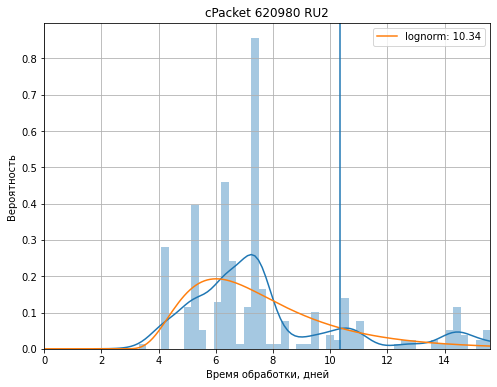


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.5185385221588041, 2.5250253354711423, 4.565125974734275)

630870 RU2
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm     55.193200  0.04708
9  weibull_max     57.795456  0.03641
2        gamma     58.139792  0.06377
5     pearson3     58.148261  0.06386
0         beta     86.913484  0.03237
4         norm    511.399644  0.00003
6       triang   1457.023864  0.00000
7      uniform   5187.161833  0.00000
1        expon   6201.763534  0.00000
8  weibull_min  43277.018679  0.00000


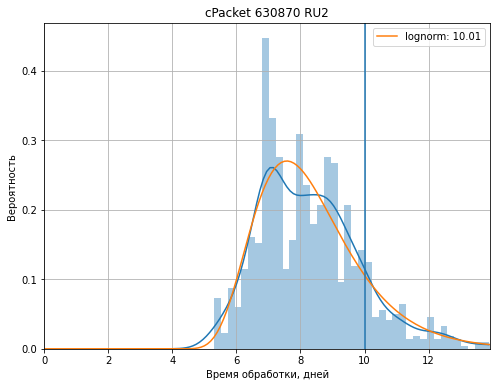


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.3363663041312292, 3.4261045004652715, 4.644842786916828)

102975 RU3
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm    1734.371656      0.0
2        gamma    6152.006446      0.0
5     pearson3    6152.799932      0.0
0         beta    7832.281107      0.0
4         norm   42802.419633      0.0
6       triang  120288.132263      0.0
7      uniform  249274.687036      0.0
1        expon  322724.970692      0.0
8  weibull_min  669991.592810      0.0
9  weibull_max  705197.718798      0.0


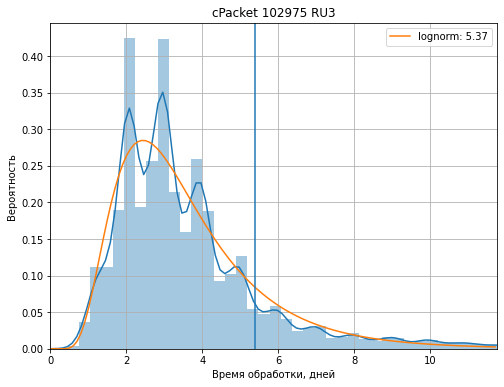


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.5208671235095904, 0.08704273165690782, 3.0792144944486823)

420310 RU3
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
9  weibull_max     244.679387      0.0
3      lognorm     331.791552      0.0
0         beta     633.279567      0.0
5     pearson3     854.668064      0.0
2        gamma     855.083705      0.0
8  weibull_min    8483.637290      0.0
4         norm   11602.430727      0.0
6       triang   32464.926486      0.0
7      uniform  111753.090711      0.0
1        expon  332273.603910      0.0


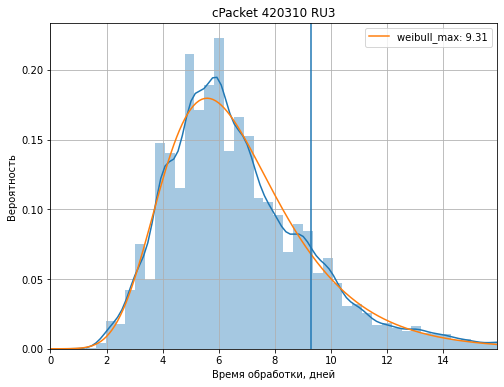


Distribution parameters:
------------------------

Distribution: weibull_max
Parameters: (130207789.94508208, 266570159.09893876, 266570153.5123426)

620980 RU3
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm     75.307000  0.00041
5     pearson3     77.206009  0.00040
2        gamma     77.208740  0.00040
0         beta     77.208799  0.00040
8  weibull_min    107.698754  0.00036
4         norm    194.564907  0.00000
6       triang    717.216550  0.00000
7      uniform   2721.788196  0.00000
1        expon   5158.475573  0.00000
9  weibull_max  14060.466558  0.00000



Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.2465246863495064, -0.7955900403221132, 6.526830273052508)

630870 RU3
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
9  weibull_max     104.548960  0.00001
3      lognorm     175.250523  0.00000
0         beta     373.868401  0.00000
2        gamma     375.557529  0.00000
4         norm    1972.634274  0.00000
6       triang    5283.291073  0.00000
7      uniform   20131.683894  0.00000
1        expon   73103.420624  0.00000
8  weibull_min  276432.678470  0.00000
5     pearson3            NaN      NaN


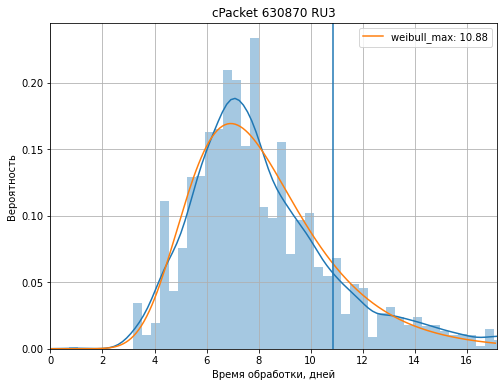


Distribution parameters:
------------------------

Distribution: weibull_max
Parameters: (1495299.4107663163, 3248673.108389792, 3248666.1778571187)

102975 RU4
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm     90.194186  0.01457
9  weibull_max     92.830354  0.01288
2        gamma     93.371458  0.01674
0         beta     94.963422  0.01527
4         norm    280.465859  0.00138
8  weibull_min    286.093235  0.00560
6       triang   1344.782562  0.00000
7      uniform   6205.513302  0.00000
1        expon  21759.249300  0.00000
5     pearson3           NaN      NaN


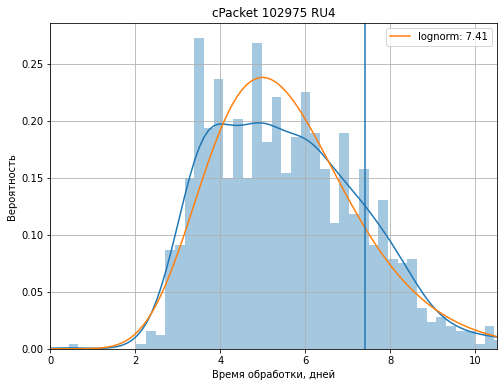


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.23611833990339812, -1.9092090613319477, 7.298243033129361)

420310 RU4
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution   chi_square  p_value
0         beta   444.315152      0.0
8  weibull_min   474.929557      0.0
6       triang   520.686597      0.0
2        gamma   633.493486      0.0
5     pearson3   633.517254      0.0
3      lognorm   691.159544      0.0
9  weibull_max   711.021075      0.0
4         norm  1569.700190      0.0
7      uniform  6328.872274      0.0
1        expon  9063.907219      0.0



Distribution parameters:
------------------------

Distribution: beta
Parameters: (1.9016585213264627, 5.335607836108892, 1.602320619323426, 16.870554762132038)

620980 RU4
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
9  weibull_max    9231.891763      0.0
2        gamma    9303.770653      0.0
5     pearson3    9320.242958      0.0
3      lognorm    9330.607510      0.0
4         norm    9368.089444      0.0
6       triang   10078.368518      0.0
0         beta   10997.375591      0.0
7      uniform   40712.647420      0.0
1        expon  177291.515970      0.0
8  weibull_min  843448.348833      0.0



Distribution parameters:
------------------------

Distribution: weibull_max
Parameters: (3.842081538712087, 19.377646781184932, 13.280619815838966)

630870 RU4
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
2        gamma     268.052847      0.0
5     pearson3     268.088830      0.0
3      lognorm     288.871645      0.0
9  weibull_max     379.687530      0.0
0         beta     830.556939      0.0
4         norm    4744.646516      0.0
8  weibull_min    5960.378587      0.0
6       triang   33344.554249      0.0
7      uniform  149057.962567      0.0
1        expon  569290.730288      0.0


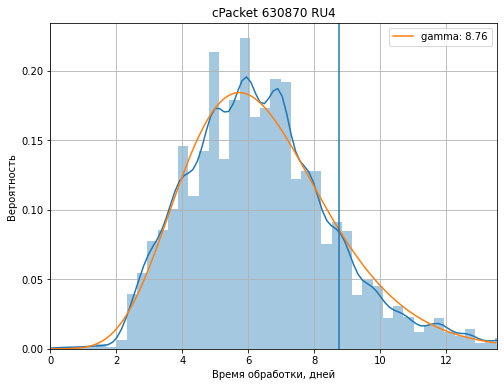


Distribution parameters:
------------------------

Distribution: gamma
Parameters: (10.186669640286027, -0.7744833390752486, 0.7079844526686272)

102975 RU5
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm    1773.565823      0.0
9  weibull_max    3988.062775      0.0
2        gamma    5770.405814      0.0
5     pearson3    5770.987955      0.0
0         beta    6423.521297      0.0
8  weibull_min   17801.276087      0.0
4         norm   24105.859349      0.0
6       triang   69687.367714      0.0
7      uniform  127787.489349      0.0
1        expon  160479.166233      0.0


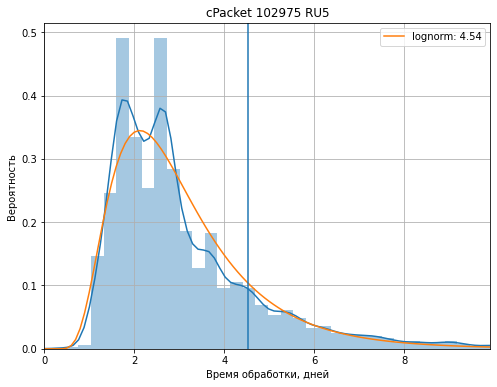


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.517062301663186, 0.16632375906166447, 2.557878073170361)

420310 RU5
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm     338.420363      0.0
9  weibull_max    1075.073016      0.0
2        gamma    1475.851647      0.0
5     pearson3    1476.029569      0.0
0         beta    1763.992802      0.0
8  weibull_min    5924.474507      0.0
4         norm    8673.294934      0.0
6       triang    9593.244256      0.0
7      uniform   42450.097971      0.0
1        expon  150090.145870      0.0


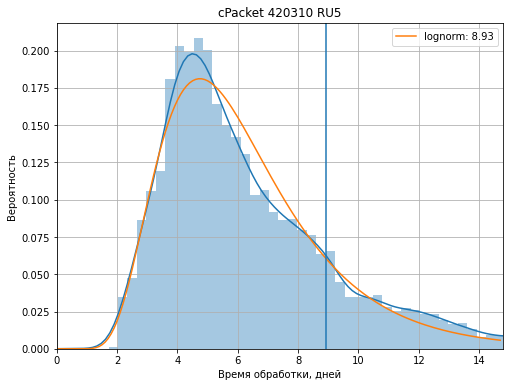


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.446066078535997, 0.2720138063716889, 5.45362313905744)

620980 RU5
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution   chi_square  p_value
4         norm   515.625302      0.0
0         beta   521.044127      0.0
5     pearson3   521.147609      0.0
3      lognorm   521.492816      0.0
2        gamma   525.412209      0.0
8  weibull_min   657.179733      0.0
6       triang  1162.733189      0.0
7      uniform  2147.973622      0.0
9  weibull_max  4736.849687      0.0
1        expon  6275.834319      0.0


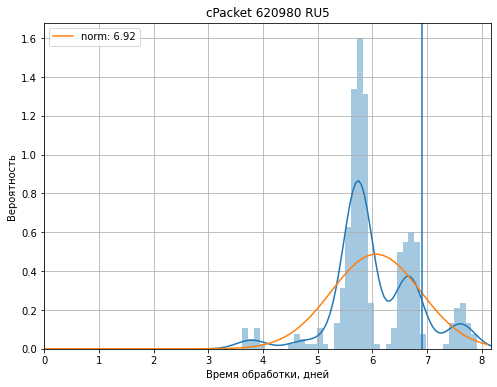


Distribution parameters:
------------------------

Distribution: norm
Parameters: (6.066933379120879, 0.8183963948980486)

630870 RU5
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm     80.787309  0.01695
0         beta     86.593718  0.01390
2        gamma     87.475084  0.01377
5     pearson3     87.493576  0.01375
9  weibull_max    101.082121  0.00094
4         norm    141.769837  0.00393
8  weibull_min    610.083838  0.00000
6       triang   8268.251565  0.00000
7      uniform  21873.774495  0.00000
1        expon  38607.340711  0.00000


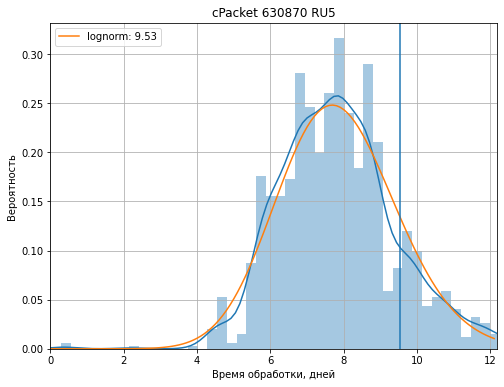


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.07004777128739778, -15.214087117107852, 23.01044561517058)

102975 RU6
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm     87.525758  0.00311
2        gamma    109.765147  0.00012
0         beta    137.300545  0.00001
4         norm    518.816598  0.00000
8  weibull_min    850.271601  0.00000
6       triang   2491.745048  0.00000
7      uniform   7408.878058  0.00000
1        expon  26884.215194  0.00000
9  weibull_max  27744.922553  0.00000
5     pearson3           NaN      NaN


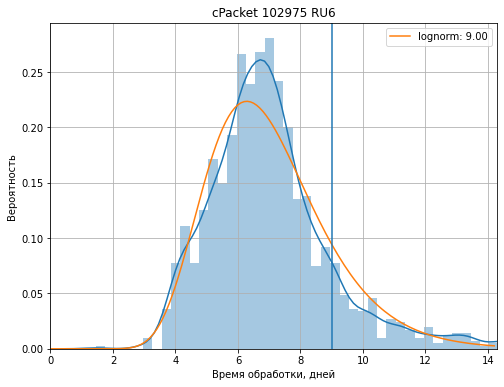


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.2751712897659457, 0.041821202868627734, 6.7325038143471945)

420310 RU6
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
0         beta     59.721964  0.01432
5     pearson3     73.435453  0.04229
2        gamma     73.437686  0.04233
8  weibull_min     79.840544  0.00237
3      lognorm     89.098042  0.01189
6       triang    328.522775  0.00000
4         norm    541.849012  0.00000
7      uniform   5872.821909  0.00000
1        expon  23739.015405  0.00000
9  weibull_max  53396.004590  0.00000


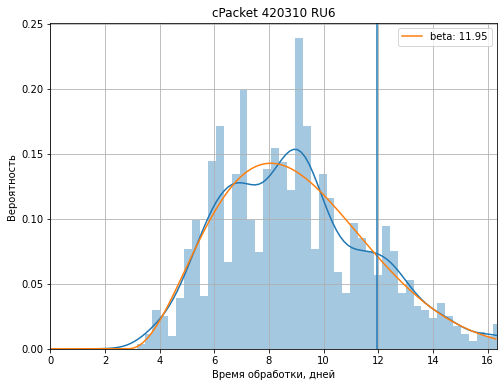


Distribution parameters:
------------------------

Distribution: beta
Parameters: (3.363796043962428, 8.36287890318637, 2.816617898927123, 21.577771034337268)

620980 RU6
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
0         beta  4.606122e+03      0.0
6       triang  7.637683e+03      0.0
4         norm  1.072589e+04      0.0
3      lognorm  1.102595e+04      0.0
8  weibull_min  1.288880e+04      0.0
2        gamma  1.361770e+04      0.0
7      uniform  1.481200e+05      0.0
1        expon  4.041756e+05      0.0
9  weibull_max  5.855510e+05      0.0
5     pearson3  3.419821e+06      0.0


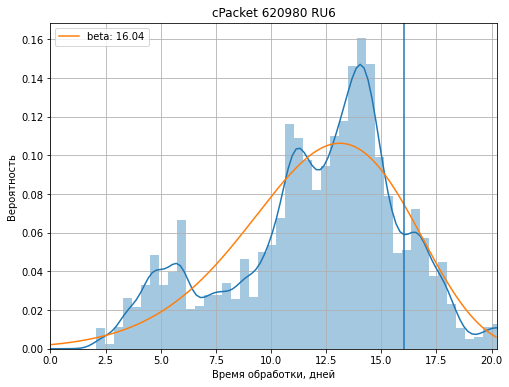


Distribution parameters:
------------------------

Distribution: beta
Parameters: (164.16717125641378, 12.060166215393409, -176.8160392375167, 202.8080272340212)

630870 RU6
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
8  weibull_min    2465.243767      0.0
0         beta    3099.211681      0.0
2        gamma    4827.749436      0.0
5     pearson3    4827.919397      0.0
3      lognorm    5039.885956      0.0
9  weibull_max    6034.080182      0.0
6       triang   24114.211163      0.0
4         norm   33195.117715      0.0
1        expon  108146.386041      0.0
7      uniform  183390.840630      0.0


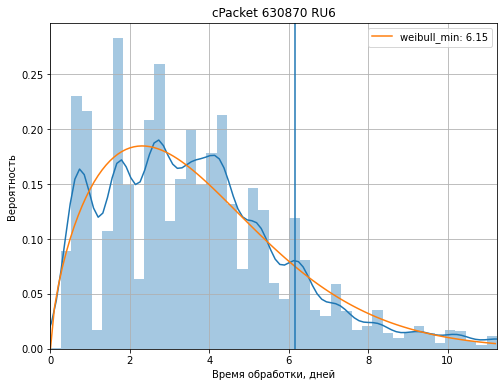


Distribution parameters:
------------------------

Distribution: weibull_min
Parameters: (1.6264338976597204, 0.002878348529378007, 4.144637511789436)

102975 RU7
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution  chi_square  p_value
0         beta  266.174211      0.0
6       triang  386.659999      0.0
5     pearson3  466.366333      0.0
8  weibull_min  530.191989      0.0
1        expon  706.911953      0.0
9  weibull_max  819.710758      0.0
3      lognorm  843.535604      0.0
2        gamma  865.921704      0.0
4         norm  867.923937      0.0
7      uniform  933.316078      0.0


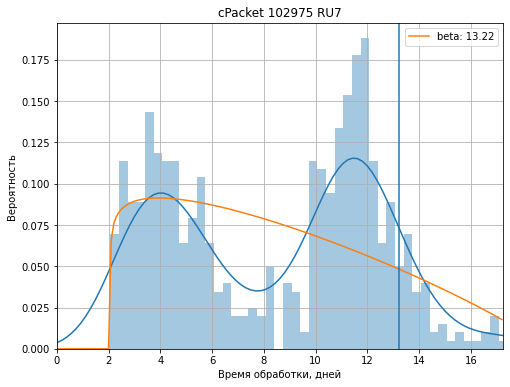


Distribution parameters:
------------------------

Distribution: beta
Parameters: (1.105741856373839, 1.851113058231281, 2.0688301672908436, 16.812333593645704)

420310 RU7
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm     54.827968  0.00555
5     pearson3     55.742207  0.00513
2        gamma     55.746912  0.00513
0         beta     70.053491  0.00197
4         norm     74.657360  0.00292
8  weibull_min    102.515846  0.00060
9  weibull_max    491.694234  0.00000
6       triang    931.131039  0.00000
7      uniform   4368.783661  0.00000
1        expon  15432.344818  0.00000


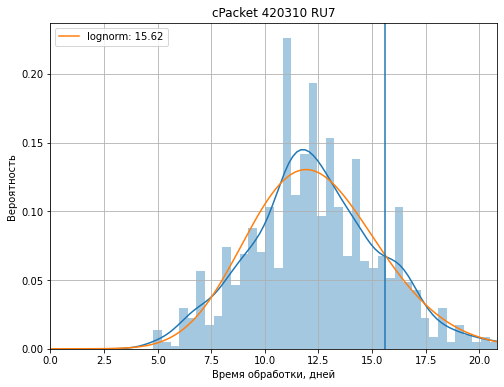


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.10693287010049192, -16.52164006544387, 28.77335795384812)

620980 RU7
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm    2569.834492      0.0
2        gamma    3370.216446      0.0
0         beta    3911.701471      0.0
4         norm   13257.666100      0.0
8  weibull_min   16335.043065      0.0
6       triang   38613.241984      0.0
7      uniform  150407.662153      0.0
1        expon  520411.681892      0.0
9  weibull_max  530730.521614      0.0
5     pearson3            NaN      NaN


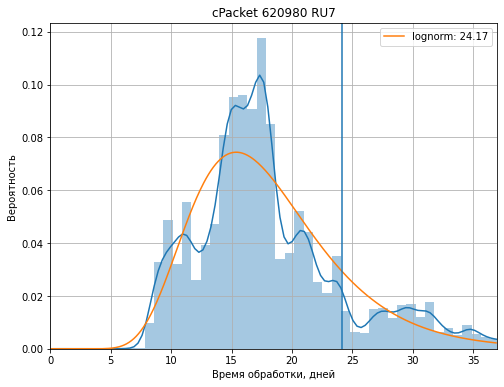


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.3314293689244975, 0.06640343084240644, 17.093388989751112)

630870 RU7
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
0         beta    8523.878846      0.0
8  weibull_min    9172.037819      0.0
4         norm    9257.913002      0.0
3      lognorm   10185.846513      0.0
5     pearson3   10554.858125      0.0
2        gamma   10555.165513      0.0
6       triang   22245.229996      0.0
7      uniform   86178.302326      0.0
1        expon  179247.572052      0.0
9  weibull_max  425274.322731      0.0


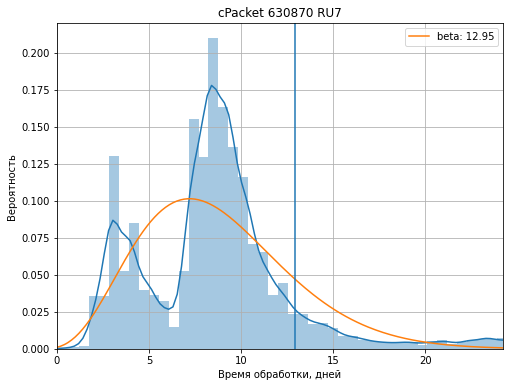


Distribution parameters:
------------------------

Distribution: beta
Parameters: (4.665676056080681, 23.951177918091325, -1.018782232324341, 59.70757070507433)

102975 RU8
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm     637.549483      0.0
9  weibull_max     929.343299      0.0
5     pearson3     974.473742      0.0
2        gamma     974.627499      0.0
0         beta    1708.879008      0.0
8  weibull_min    6014.121667      0.0
4         norm    9673.905987      0.0
6       triang   46890.321399      0.0
7      uniform  109954.302343      0.0
1        expon  182175.665542      0.0


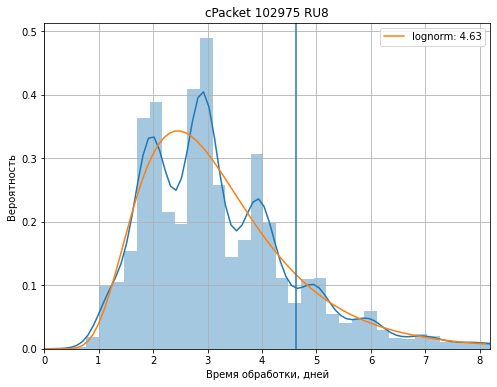


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (0.43214833494038996, 0.003298231539884879, 2.9532790424861366)

420310 RU8
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
8  weibull_min     493.493559      0.0
0         beta     875.943121      0.0
5     pearson3    1291.516259      0.0
2        gamma    1291.924971      0.0
3      lognorm    1577.855800      0.0
9  weibull_max    1650.819552      0.0
4         norm   10869.809209      0.0
6       triang   11168.235583      0.0
7      uniform  125920.859267      0.0
1        expon  372564.423251      0.0


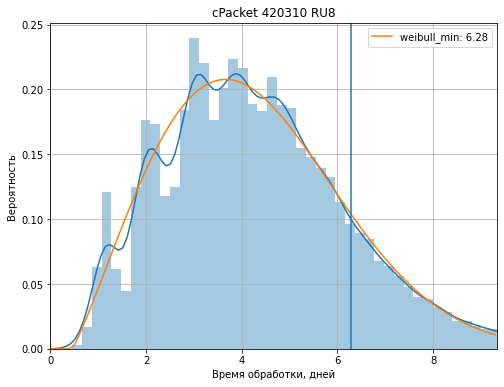


Distribution parameters:
------------------------

Distribution: weibull_min
Parameters: (2.134085303175038, 0.45472758460633256, 4.314120126603127)

620980 RU8
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
9  weibull_max    154.416338      0.0
3      lognorm    170.468680      0.0
2        gamma    203.163276      0.0
5     pearson3    203.209190      0.0
0         beta    203.431423      0.0
8  weibull_min    480.051227      0.0
4         norm    594.099241      0.0
6       triang   1021.582185      0.0
7      uniform   4484.899410      0.0
1        expon  17003.526282      0.0


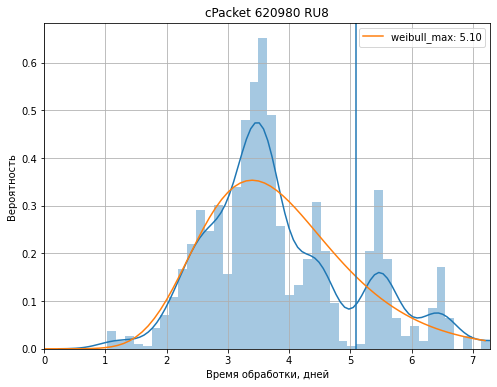


Distribution parameters:
------------------------

Distribution: weibull_max
Parameters: (14.108187049351606, 18.043550888907934, 14.723419843658004)

630870 RU8
--------------------------------------------------------------------------------

Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
9  weibull_max    376.047880      0.0
3      lognorm    498.603954      0.0
2        gamma    638.058101      0.0
0         beta    800.088463      0.0
4         norm   1385.334220      0.0
8  weibull_min   3247.616555      0.0
6       triang  16202.586957      0.0
7      uniform  34733.968591      0.0
1        expon  84313.278751      0.0
5     pearson3           NaN      NaN


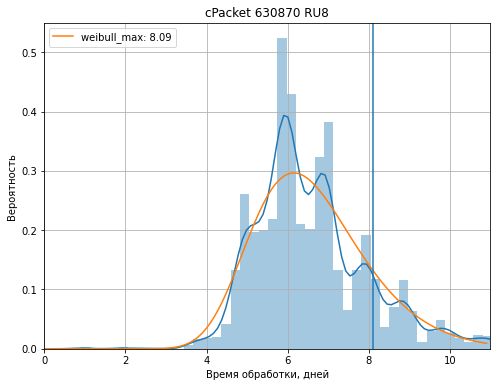


Distribution parameters:
------------------------

Distribution: weibull_max
Parameters: (10.100268783209483, 18.610219648824803, 12.591091871475196)

CPU times: user 2min 13s, sys: 167 ms, total: 2min 14s
Wall time: 2min 13s


In [1193]:
%%time
mag_time_dist = {}
for prod in ['cPacket']:
    mag_time_dist[prod] = {}
    for  zone in zones:
        mag_time_dist[prod][zone] = {}
        for mmpo in filtered_target[prod].keys():
            sample = filtered_target[prod][mmpo].query('zone == @zone')\
                        ['day_on_magistral'].dropna().values
            if len(sample) != 0:
                
                    
                sample = sample[(sample > 0) & (sample <= np.percentile(sample, 99))]
                print(mmpo, zone)
                print('-'*80)
                mag_time_dist[prod][zone][mmpo] = fit_dist(sample, title=prod + ' ' + mmpo + ' ' + zone )
                print()
            #break
        #break
    #break

## Строим модели предсказывающие время обработки каждого продукта в каждом ММПО

In [353]:
train_data.head(1).T

date_                    2020-04-29
delta_in_hours                30.69
mmpo_index_EMS               630870
mmpo_index_PH E2E            630870
mmpo_index_RDC               630870
mmpo_index_RDnR              630870
...                             ...
output__ePacket_HK                0
output__Посылка                   0
output__Посылка авиа            138
output__Посылка наземная          0
target                      1.27875

[77 rows x 1 columns]

In [354]:
X.head(1).T

0
input__EMS                   8.0
input__PH E2E                0.0
input__RDC                   0.0
input__RDnR                  0.0
input__RDnR Air              0.0
input__RDnR E2E              0.0
input__RDnR Ground           0.0
input__RM                    0.0
input__RM Air             1533.0
input__RM E2E                1.0
input__RM Ground             0.0
input__RM Letter Air         0.0
input__RM Letter Ground      0.0
input__RMH E2E               0.0
input__SRM                   0.0
input__SRM Air           68717.0
input__SRM E2E               0.0
input__SRM Ground            0.0
input__cPacket            5636.0
input__domestic            599.0
input__ePacket_CN            2.0
input__ePacket_HK            0.0
input__Посылка               0.0
input__Посылка авиа        138.0
input__Посылка наземная      0.0

cPacket 102975
(99987, 25)


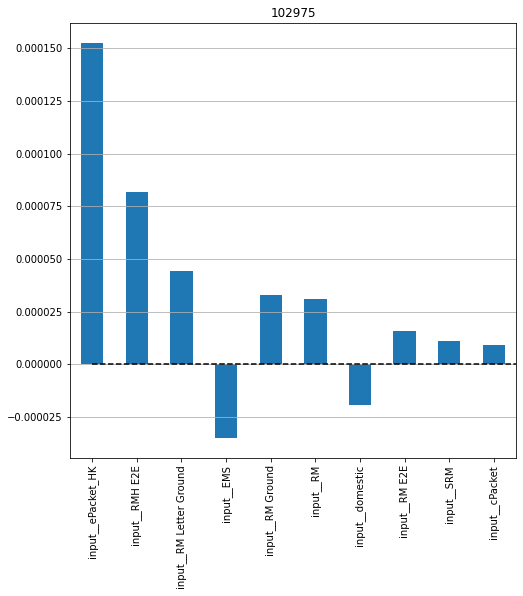

Train:
MAE: 0.8675
MSE: 1.7146
R^2: 0.0682
Test: 
MAE: 0.8612
MSE: 2.0049
R^2: 0.0630
cPacket 420310
(99969, 25)


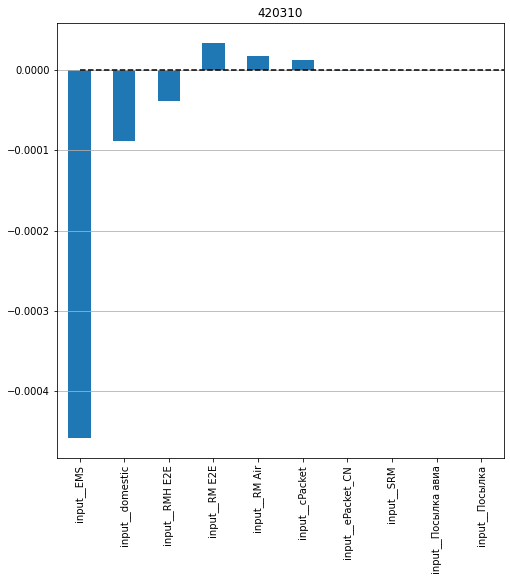

Train:
MAE: 0.7019
MSE: 0.8036
R^2: 0.2534
Test: 
MAE: 0.7016
MSE: 0.9408
R^2: 0.2210
cPacket 620980
(74608, 25)


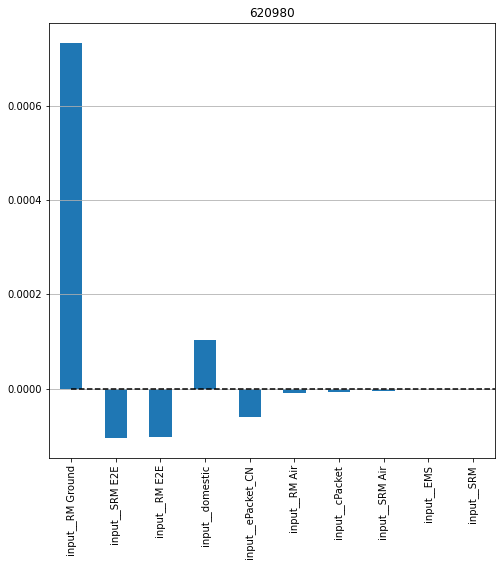

Train:
MAE: 0.5230
MSE: 1.1470
R^2: 0.2623
Test: 
MAE: 0.5241
MSE: 0.8605
R^2: 0.3155
cPacket 630870
(99998, 25)


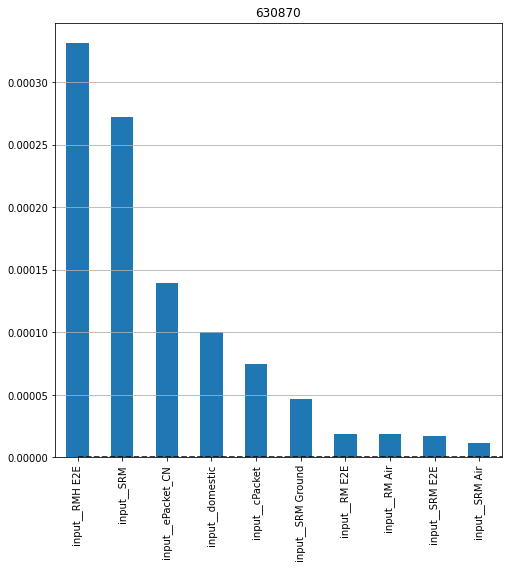

Train:
MAE: 2.6071
MSE: 14.7813
R^2: 0.1159
Test: 
MAE: 2.5928
MSE: 14.1628
R^2: 0.1175
CPU times: user 50.8 s, sys: 3.07 s, total: 53.9 s
Wall time: 4.51 s


In [271]:
%%time
warnings.filterwarnings("ignore")

result_days_all = {}
# targets_all.keys()
for prod in ['cPacket']:
    result_prod = {}
    for idx in ['102975', '420310', '620980', '630870']:
        if targets_all[prod][idx].shape[0] >= 1000:
            temp_load = in_out_streams_days[in_out_streams_days['mmpo_index'] == idx]


            temp_load = temp_load.pivot(index='date_', columns='type_product').fillna(0)#.reset_index()
            temp_load.columns = [col[0] + '_' + str(col[1]) for col in temp_load.columns.to_flat_index()]

            temp_target = targets_all[prod][idx]
            temp_target['date_'] = temp_target['b_date_h'].dt.date
            temp_target = temp_target[['date_','delta_in_hours']].set_index('date_')
            train_data = pd.merge(temp_target, temp_load,
                              left_index=True, right_index=True,
                              how = 'left').dropna()

            train_data['target'] = train_data['delta_in_hours'] / 24

            X = train_data.filter(like='input').reset_index(drop=True)
            #y = np.log1p(train_data['target'].reset_index(drop=True))
            y = train_data['target'].reset_index(drop=True)

            #scaler = StandardScaler()
            #X_sc = scaler.fit_transform(X)
            X_sc = X


            X_train,  X_valid, y_train, y_valid = train_test_split(X_sc, y, train_size=0.6)
            X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, train_size=0.5)


            model = LassoCV(cv=3)
            model.fit(X_train, y_train)

            result_prod[idx] = (model, X.columns)

            print(prod, idx)
            print(X.shape)
            plotCoefficients(model, X.columns, title=idx)

            print('Train:')
            regression_qlt(y_train, model.predict(X_train))
            print('Test: ')
            regression_qlt(y_test, model.predict(X_test))
            print('='*80)
    
    result_days_all[prod] = result_prod

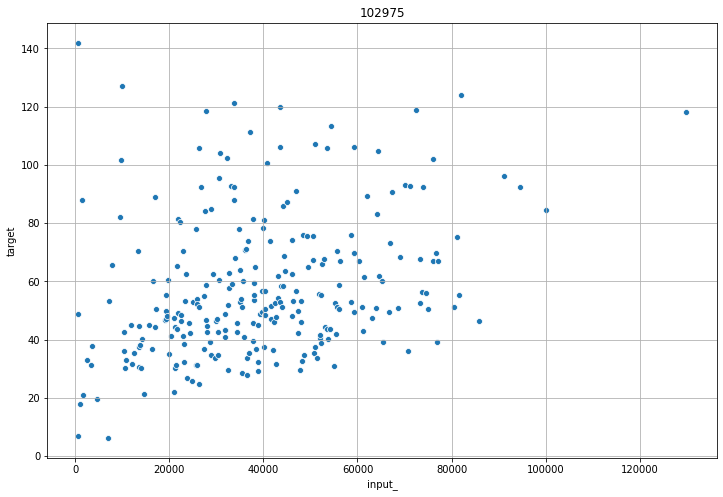

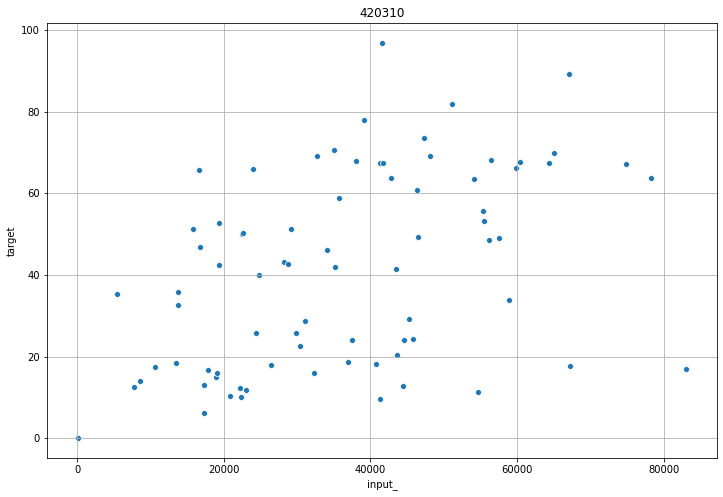

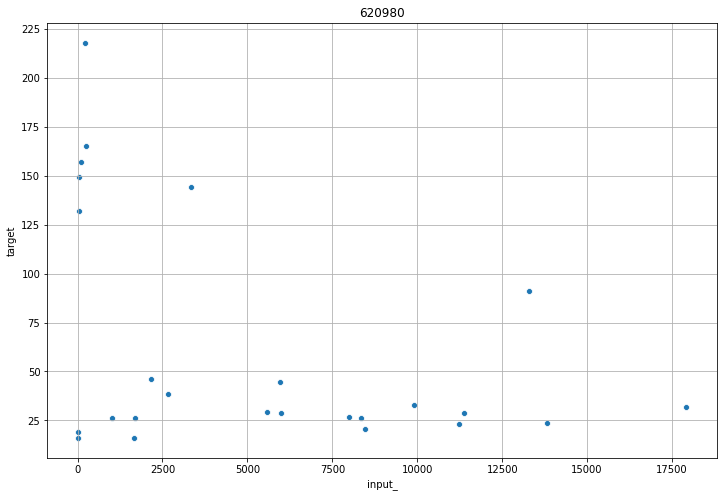

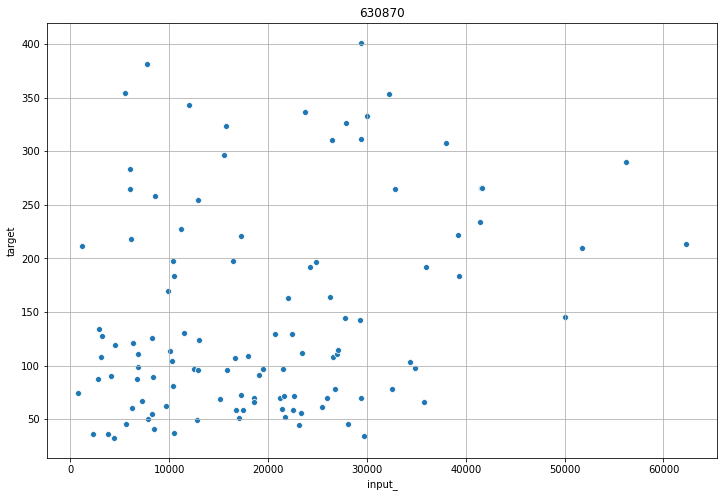

CPU times: user 1.25 s, sys: 4 ms, total: 1.26 s
Wall time: 1.26 s


In [1224]:
%%time
warnings.filterwarnings("ignore")

#result_days_all = {}
# targets_all.keys()
for prod in ['cPacket']:
#    result_prod = {}
    for idx in ['102975', '420310', '620980', '630870']:
        if targets_all[prod][idx].shape[0] >= 1000:
            temp_load = in_out_streams_days[(in_out_streams_days['mmpo_index'] == idx) &\
                                           (in_out_streams_days['type_product'] == prod)]
        

            temp_load.set_index('date_', inplace=True)
            #temp_load = temp_load.pivot(index='date_', columns='type_product').fillna(0)#.reset_index()
            #temp_load.columns = [col[0] + '_' + str(col[1]) for col in temp_load.columns.to_flat_index()]

            temp_target = targets_all[prod][idx]
            temp_target['date_'] = temp_target['b_date_h'].dt.date
            temp_target = temp_target[['date_','delta_in_hours']].set_index('date_')
            train_data = pd.merge(temp_target, temp_load,
                              left_index=True, right_index=True,
                              how = 'left').dropna()

            train_data['target'] = train_data['delta_in_hours'] 
            
            percentile_time = train_data.groupby('input_', as_index=False).agg({'target':lambda val: np.percentile(val, 85)})
            plt.figure(figsize=(12,8))
            sns.scatterplot('input_', 'target', data=percentile_time)
            plt.title(idx)
            plt.grid()
            plt.show()

            #X = train_data.filter(like='input').reset_index(drop=True)
            #y = np.log1p(train_data['target'].reset_index(drop=True))
            #y = train_data['target'].reset_index(drop=True)



## Models for processing time

In [272]:
pd.DataFrame(result_days_all['cPacket']).T

0                                                  1
102975  LassoCV(cv=3)  Index(['input__EMS', 'input__PH E2E', 'input__...
420310  LassoCV(cv=3)  Index(['input__EMS', 'input__PH E2E', 'input__...
620980  LassoCV(cv=3)  Index(['input__EMS', 'input__PH E2E', 'input__...
630870  LassoCV(cv=3)  Index(['input__EMS', 'input__PH E2E', 'input__...

## Models for magistral time

In [891]:
mag_time_frame = pd.DataFrame(mag_time_dist['cPacket'])
arr_mag = mag_time_frame.applymap(get_percent_time).values.T

In [358]:
# mag_time_frame.to_pickle('mmpo_time_models.pckl')
# pd.DataFrame(arr_mag).to_pickle('85_perc_mag_rime.pckl')

## Volumes forecast

In [391]:
forecast_load = pd.read_pickle('../forecast/data/product_mmpo_forecast.pckl')
forecast_region = pd.read_pickle('../forecast/data/product_mmpo_region_forecast.pckl')

mmpo_dict = {'брянск': None, 'владивосток':None, 'екатеринбург':'620980', 'казань':'420310', 'москва':'102975',
       'новосибирск':'630870', 'оренбург':None, 'санкт-петербург': None } 
forecast_load['mmpo_index'] = forecast_load['mmpo'].map(mmpo_dict)
forecast_load.dropna(inplace=True)
forecast_load.rename(columns={'count_rpo':'input_'}, inplace=True)

forecast_region['mmpo_index'] = forecast_region['mmpo'].map(mmpo_dict)
forecast_region.dropna(inplace=True)
forecast_region.rename(columns={'count_rpo':'input_'}, inplace=True)


In [392]:
forecast_region = forecast_region[(forecast_region['ds'] >= '2021-01-01') &\
                              (forecast_region['ds'] <= '2021-03-31')]

forecast_region['ds'] = forecast_region['ds'].dt.date

forecast_load = forecast_load[(forecast_load['ds'] >= '2021-01-11') &\
                              (forecast_load['ds'] <= '2021-03-31')]

In [135]:
# fact_load = pd.read_pickle('../forecast/data/fact_data_from_11_11_20_2020-12-02.pckl')

# mmpo_dict = {'брянск': None, 'владивосток':None, 'екатеринбург':'620980', 'казань':'420310', 'москва':'102975',
#        'новосибирск':'630870', 'оренбург':None, 'санкт-петербург': None } 
# fact_load.rename(columns={'myday':'ds','region_from':'mmpo', 'cnt_rpo':'input_'}, inplace=True)
# fact_load['mmpo_index'] = fact_load['mmpo'].map(mmpo_dict)
# fact_load.dropna(inplace=True)
# fact_load = fact_load[[ 'ds', 'mmpo', 'zone', 'bar_code_type', 'input_', 'mmpo_index']]
# fact_load['ds'] = fact_load['ds'].dt.date.astype(str)

In [378]:
# %%time

# # construct data for predition prcessing time in mmpo 
# forecast_volumes = {}
# for idx in forecast_load['mmpo_index'].unique():
#     temp_load = forecast_load[forecast_load['mmpo_index'] == idx]
#     temp_load = temp_load.pivot(index='ds', columns='bar_code_type').fillna(0)#.reset_index()
#     temp_load.columns = [col[0] + '_' + str(col[1]) for col in temp_load.columns.to_flat_index()]
#     temp_load = temp_load.filter(like='input')
#     forecast_volumes[idx] = temp_load
    
# future_frames = {}
# time_frames = {}

# for prod in result_days_all.keys():
#     volumes = {}
#     time = {}
#     time_frame = pd.DataFrame()

            
#     for idx in result_days_all[prod].keys():
        
#         # extract forcasted volumes
#         temp_load = forecast_volumes[idx]
        
#         # construct frame for prediction by columns order
#         future_frame = pd.DataFrame(columns=result_days_all[prod][idx][1], index=temp_load.index)
        
#         for col in future_frame.columns:
#             if col in temp_load.columns:
#                 future_frame[col] = temp_load[col]
#         future_frame.fillna(0, inplace=True)
        
#         # save future frame
#         volumes[idx] = future_frame
        
#         #predict time
#         time_frame[f'{prod}_{idx}_time'] = result_days_all[prod][idx][0].predict(future_frame)
#         time_frame.set_index(temp_load.index,inplace=True)
#         # save time for mmpo
#         time[idx] = time_frame
        
#     # save times for product
#     time_frames[prod] = time
#     future_frames[prod] = volumes



CPU times: user 126 ms, sys: 999 µs, total: 127 ms
Wall time: 126 ms


In [393]:
%%time
mmpo_idx = ['102975', '420310', '620980', '630870']
frames_by_day = {}
for day in forecast_region['ds'].unique():# forecast_region['ds'].unique()[-180:]:
    zone_volumes = {}
    for zone in forecast_region['zone'].unique():
        temp = forecast_region[(forecast_region['ds'] == day) &\
                        (forecast_region['zone'] == zone)][['mmpo_index', 'zone', 
                                                             'bar_code_type', 'input_']]
        if mmpo_idx not in list(temp['mmpo_index'].unique()):
            missed_idx = list(set(mmpo_idx) - set(temp['mmpo_index'].unique()))
            missed_rows = []
            for idx in missed_idx:
                row = {'mmpo_index':idx, 
                     'zone':zone,
                     'bar_code_type':'ePacket_CN', 
                     'input_':0}
                missed_rows.append(row)

            temp = temp.append(missed_rows, ignore_index=True)
        
        
        temp = temp.pivot_table(index='mmpo_index', 
                                columns='bar_code_type', 
                                values='input_', 
                                fill_value=0)
        temp.columns = ['input_' + '_' + str(col) for col in temp.columns]
        
        # construct frame for prediction by columns order
        future_frame = pd.DataFrame(columns=result_days_all['cPacket']['102975'][1], index=temp.index)
        
        for col in future_frame.columns:
            if col in temp.columns:
                future_frame[col] = temp[col]
        future_frame.fillna(0, inplace=True)
        
        
        
        zone_volumes[zone] = future_frame.copy()
    frames_by_day[str(day)] = zone_volumes

CPU times: user 26.2 s, sys: 14.1 ms, total: 26.2 s
Wall time: 26.2 s


In [207]:
# %%time
# mmpo_idx = ['102975', '420310', '620980', '630870']
# frames_by_day = {}
# for day in fact_load['ds'].unique():# forecast_region['ds'].unique()[-180:]:
#     zone_volumes = {}
#     for zone in fact_load['zone'].unique():
#         temp = fact_load[(fact_load['ds'] == day) &\
#                         (fact_load['zone'] == zone)][['mmpo_index', 'zone', 
#                                                              'bar_code_type', 'input_']]
#         if mmpo_idx not in list(temp['mmpo_index'].unique()):
#             missed_idx = list(set(mmpo_idx) - set(temp['mmpo_index'].unique()))
#             missed_rows = []
#             for idx in missed_idx:
#                 row = {'mmpo_index':idx, 
#                      'zone':zone,
#                      'bar_code_type':'ePacket_CN', 
#                      'input_':0}
#                 missed_rows.append(row)

#             temp = temp.append(missed_rows, ignore_index=True)
        
        
#         temp = temp.pivot_table(index='mmpo_index', 
#                                 columns='bar_code_type', 
#                                 values='input_', 
#                                 fill_value=0)
#         temp.columns = ['input_' + '_' + str(col) for col in temp.columns]
        
#         # construct frame for prediction by columns order
#         future_frame = pd.DataFrame(columns=result_days_all['cPacket']['102975'][1], index=temp.index)
        
#         for col in future_frame.columns:
#             if col in temp.columns:
#                 future_frame[col] = temp[col]
#         future_frame.fillna(0, inplace=True)
        
        
        
#         zone_volumes[zone] = future_frame.copy()
#     frames_by_day[str(day)] = zone_volumes


CPU times: user 3.9 s, sys: 0 ns, total: 3.9 s
Wall time: 35.4 s


In [208]:
for k1 in frames_by_day.keys():
    for k2 in frames_by_day[k1].keys():
        print(k1, k2, frames_by_day[k1][k2].shape)
    print()

2020-11-25 RU1 (4, 25)
2020-11-25 RU2 (4, 25)
2020-11-25 RU3 (4, 25)
2020-11-25 RU4 (4, 25)
2020-11-25 RU5 (4, 25)
2020-11-25 RU6 (4, 25)
2020-11-25 RU7 (4, 25)
2020-11-25 RU8 (4, 25)

2020-11-11 RU1 (4, 25)
2020-11-11 RU2 (4, 25)
2020-11-11 RU3 (4, 25)
2020-11-11 RU4 (4, 25)
2020-11-11 RU5 (4, 25)
2020-11-11 RU6 (4, 25)
2020-11-11 RU7 (4, 25)
2020-11-11 RU8 (4, 25)

2020-11-12 RU1 (4, 25)
2020-11-12 RU2 (4, 25)
2020-11-12 RU3 (4, 25)
2020-11-12 RU4 (4, 25)
2020-11-12 RU5 (4, 25)
2020-11-12 RU6 (4, 25)
2020-11-12 RU7 (4, 25)
2020-11-12 RU8 (4, 25)

2020-11-13 RU1 (4, 25)
2020-11-13 RU2 (4, 25)
2020-11-13 RU3 (4, 25)
2020-11-13 RU4 (4, 25)
2020-11-13 RU5 (4, 25)
2020-11-13 RU6 (4, 25)
2020-11-13 RU7 (4, 25)
2020-11-13 RU8 (4, 25)

2020-11-14 RU1 (4, 25)
2020-11-14 RU2 (4, 25)
2020-11-14 RU3 (4, 25)
2020-11-14 RU4 (4, 25)
2020-11-14 RU5 (4, 25)
2020-11-14 RU6 (4, 25)
2020-11-14 RU7 (4, 25)
2020-11-14 RU8 (4, 25)

2020-11-15 RU1 (4, 25)
2020-11-15 RU2 (4, 25)
2020-11-15 RU3 (4, 25)
2020-1

In [175]:
mmpo_index = frames_by_day['2020-11-11']['RU1'].index
flows = frames_by_day['2020-11-11']['RU1'].columns
zone_names = ['RU1', 'RU2', 'RU3', 'RU4', 'RU5', 'RU6', 'RU7', 'RU8']

In [176]:
def plot_rel_change(x0, x , title=''):

    plt.figure(figsize=(18,2))
    sns.heatmap(pd.DataFrame((x - x0)  / x0.sum(axis=0)[None,:], columns=flows, index=mmpo_index), 
                cmap='RdYlGn', annot=True, fmt='.0%')
    plt.title(title)
    plt.show()

## Оптимизируемый функционал

In [177]:
def total_sla_1(x):
    value = ((((x.reshape(8, 4, 25).sum(axis=0) \
               * np.array(( result_days_all['cPacket']['102975'][0].coef_,
                            result_days_all['cPacket']['420310'][0].coef_,
                            result_days_all['cPacket']['620980'][0].coef_,
                            result_days_all['cPacket']['630870'][0].coef_))).sum(axis=1) \
               + np.array((result_days_all['cPacket']['102975'][0].intercept_,
                           result_days_all['cPacket']['420310'][0].intercept_,
                           result_days_all['cPacket']['620980'][0].intercept_,
                           result_days_all['cPacket']['630870'][0].intercept_)))[None, :] +  arr_mag)\
             * x.reshape(8, 4, 25)[:, :, -7]).sum() 
    return value


def total_sla_2(x):
    value = ((((x.reshape(8, 4, 25).sum(axis=0) \
               * np.array(( result_days_all['cPacket']['102975'][0].coef_ * (result_days_all['cPacket']['102975'][0].coef_ > 0),
                            result_days_all['cPacket']['420310'][0].coef_ * (result_days_all['cPacket']['420310'][0].coef_ > 0),
                            result_days_all['cPacket']['620980'][0].coef_ * (result_days_all['cPacket']['620980'][0].coef_ > 0),
                            result_days_all['cPacket']['630870'][0].coef_ * (result_days_all['cPacket']['630870'][0].coef_ > 0)))).sum(axis=1) \
               + np.array((result_days_all['cPacket']['102975'][0].intercept_,
                           result_days_all['cPacket']['420310'][0].intercept_,
                           result_days_all['cPacket']['620980'][0].intercept_,
                           result_days_all['cPacket']['630870'][0].intercept_)))[None, :] +  arr_mag)\
             * x.reshape(8, 4, 25)[:, :, -7]).sum() 
    return value


def total_sla_3(x):
    scaler = StandardScaler()
    value = ((((x.reshape(8, 4, 25).sum(axis=0) \
               * np.array(( result_days_all['cPacket']['102975'][0].coef_,
                            result_days_all['cPacket']['420310'][0].coef_,
                            result_days_all['cPacket']['620980'][0].coef_,
                            result_days_all['cPacket']['630870'][0].coef_))).sum(axis=1) \
               + np.array((result_days_all['cPacket']['102975'][0].intercept_,
                           result_days_all['cPacket']['420310'][0].intercept_,
                           result_days_all['cPacket']['620980'][0].intercept_,
                           result_days_all['cPacket']['630870'][0].intercept_)))[None, :] +  arr_mag)\
             * x.reshape(8, 4, 25)[:, :, -7]).sum() 
    return value


def total_time(x):
    value = (((x.reshape(8, 4, 25).sum(axis=0) \
               * np.array(( result_days_all['cPacket']['102975'][0].coef_,
                            result_days_all['cPacket']['420310'][0].coef_,
                            result_days_all['cPacket']['620980'][0].coef_,
                            result_days_all['cPacket']['630870'][0].coef_))).sum(axis=1) \
               + np.array((result_days_all['cPacket']['102975'][0].intercept_,
                           result_days_all['cPacket']['420310'][0].intercept_,
                           result_days_all['cPacket']['620980'][0].intercept_,
                           result_days_all['cPacket']['630870'][0].intercept_)))[None, :] +  arr_mag)\

    return value


def total_time_2(x):
    value = (((x.reshape(8, 4, 25).sum(axis=0) \
               * np.array(( result_days_all['cPacket']['102975'][0].coef_ * (result_days_all['cPacket']['102975'][0].coef_ > 0),
                            result_days_all['cPacket']['420310'][0].coef_ * (result_days_all['cPacket']['420310'][0].coef_ > 0),
                            result_days_all['cPacket']['620980'][0].coef_ * (result_days_all['cPacket']['620980'][0].coef_ > 0),
                            result_days_all['cPacket']['630870'][0].coef_ * (result_days_all['cPacket']['630870'][0].coef_ > 0)))).sum(axis=1) \
               + np.array((result_days_all['cPacket']['102975'][0].intercept_,
                           result_days_all['cPacket']['420310'][0].intercept_,
                           result_days_all['cPacket']['620980'][0].intercept_,
                           result_days_all['cPacket']['630870'][0].intercept_)))[None, :] +  arr_mag)\

    return value


def mmpo_time_2(x):
    value = (((x.reshape(8, 4, 25).sum(axis=0) \
               * np.array(( result_days_all['cPacket']['102975'][0].coef_ * (result_days_all['cPacket']['102975'][0].coef_ > 0),
                            result_days_all['cPacket']['420310'][0].coef_ * (result_days_all['cPacket']['420310'][0].coef_ > 0),
                            result_days_all['cPacket']['620980'][0].coef_ * (result_days_all['cPacket']['620980'][0].coef_ > 0),
                            result_days_all['cPacket']['630870'][0].coef_ * (result_days_all['cPacket']['630870'][0].coef_ > 0)))).sum(axis=1) \
               + np.array((result_days_all['cPacket']['102975'][0].intercept_,
                           result_days_all['cPacket']['420310'][0].intercept_,
                           result_days_all['cPacket']['620980'][0].intercept_,
                           result_days_all['cPacket']['630870'][0].intercept_)))[None, :] + np.zeros(shape=(8,4)))

    return value

## Цикл оптимизации

In [396]:
vl_by_days = pd.DataFrame(frames_by_day).T.sort_index()

In [299]:
%%time
vl_by_days = pd.DataFrame(frames_by_day).T.sort_index()
func=[]
optimize_volumes = []
for idx, row in tqdm(vl_by_days.iterrows()):

    x0 = np.array([r.values for r in row])
    bnds = Bounds ([0]*800, [np.inf]*800)
    eq_cons = {'type': 'eq',
               'fun': lambda x: x0.sum(axis=1).flatten() - x.reshape(8, 4, 25).sum(axis=1).flatten(),
           }
    res = minimize(total_sla_1, x0, method='SLSQP', constraints=eq_cons, bounds=bnds)
    
    optimize_volumes.append(res.x.reshape(8, 4, 25))
    func.append(res.fun)


CPU times: user 38min 21s, sys: 856 ms, total: 38min 22s
Wall time: 38min 21s


In [324]:
%%time
vl_by_days = pd.DataFrame(frames_by_day).T.sort_index()
func_2=[]
optimize_volumes_2 = []
for idx, row in tqdm(vl_by_days.iterrows()):
    
    x0 = np.array([r.values for r in row])
    bnds = Bounds ([0]*800, [np.inf]*800)
    eq_cons = {'type': 'eq',
               'fun': lambda x: x0.sum(axis=1).flatten() - x.reshape(8, 4, 25).sum(axis=1).flatten(),
           }
    res = minimize(total_sla_2, x0, method='SLSQP', constraints=eq_cons, bounds=bnds)
    
    optimize_volumes_2.append(res.x.reshape(8, 4, 25))
    func_2.append(res.fun)


CPU times: user 36min 39s, sys: 800 ms, total: 36min 40s
Wall time: 36min 39s


## AS IS значения

In [397]:
func_prev=[]
cpacket_count = []
as_is_vol = []

for idx, row in vl_by_days.iterrows():

    x0 = np.stack([r.values for r in row])
    func_prev.append(total_sla_1(x0))
    cpacket_count.append(x0[:, :,-7].sum())
    as_is_vol.append(x0)    

## Результаты оптимизации

In [326]:
sla_time_df = pd.DataFrame(np.array([func_prev, func_2]).T, 
                           index=vl_by_days.index, 
                           columns=['as_is_func', 'optimize_func'])

sla_time_df['cpacket_count'] = cpacket_count
sla_time_df['as_is_time'] = sla_time_df['as_is_func'] / sla_time_df['cpacket_count']
sla_time_df['optimize_time'] = sla_time_df['optimize_func'] / sla_time_df['cpacket_count']

sla_time_df[['roll_7_as_is_time', 
             'roll_7_optimize_time']] = sla_time_df[['as_is_time', 
                                                     'optimize_time']].rolling(7).mean()

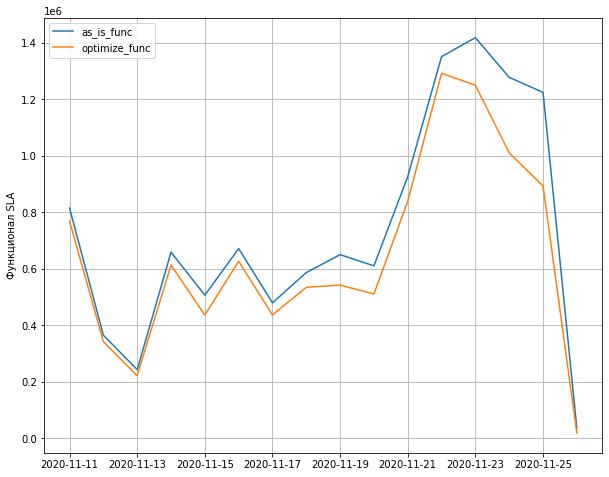

In [327]:
sla_time_df[['as_is_func', 'optimize_func']].plot(figsize=(10,8))
plt.grid()
plt.ylabel('Функционал SLA')
#plt.ylim([0, 4e6])
plt.show()

In [328]:
# sla_time_df = pd.DataFrame(np.array([func_prev, func]).T, 
#                            index=vl_by_days.index, 
#                            columns=['as_is_func', 'optimize_func'])

# sla_time_df['cpacket_count'] = cpacket_count
# sla_time_df['as_is_time'] = sla_time_df['as_is_func'] / sla_time_df['cpacket_count']
# sla_time_df['optimize_time'] = sla_time_df['optimize_func'] / sla_time_df['cpacket_count']

# sla_time_df[['roll_7_as_is_time', 
#              'roll_7_optimize_time']] = sla_time_df[['as_is_time', 
#                                                      'optimize_time']].rolling(7).mean()

# sla_time_df[['as_is_func', 'optimize_func']].plot(figsize=(10,8))
# plt.grid()
# plt.ylabel('Функционал SLA')
# #plt.ylim([0, 4e6])
# plt.show()

## Время доставки

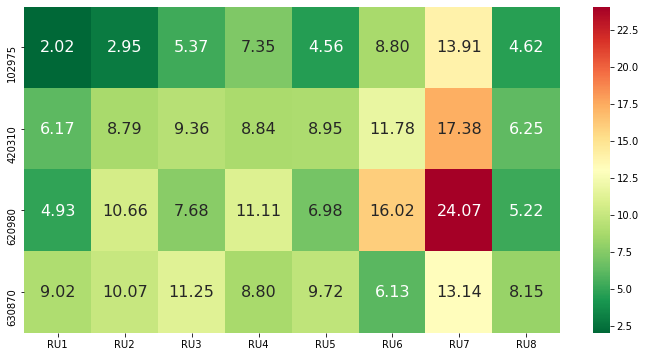

In [382]:
plt.figure(figsize=(12, 6))
sns.heatmap(mag_time_frame.applymap(get_percent_time), cmap='RdYlGn_r', annot=True, fmt='.2f', annot_kws={"size": 16});

In [428]:
from functools import reduce

In [430]:
forcasted_time = []

for i, date in zip(range(len(as_is_vol)), vl_by_days.index):
    
    new_mmpo_time = pd.DataFrame(mmpo_time_2(as_is_vol[i]),
                             columns =mmpo_index.values)
    new_mmpo_time['date']= date
    new_mmpo_time['zone']= zone_names
    
    new_mmpo_time = new_mmpo_time.melt(id_vars=['date', 'zone'], 
                                        var_name='mmpo_index', 
                                        value_name='mmpo_time')
    
    new_time = pd.DataFrame(total_time(as_is_vol[i]),
                            columns =mmpo_index.values)
    new_time['date']= date
    new_time['zone']= zone_names
    
    new_time = new_time.melt(id_vars=['date', 'zone'], 
                                        var_name='mmpo_index', 
                                        value_name='total_time_1')
    
    new_time_2 = pd.DataFrame( total_time_2(as_is_vol[i]),
                            columns =mmpo_index.values) 
    new_time_2['date']= date
    new_time_2['zone']= zone_names
    
    new_time_2= new_time_2.melt(id_vars=['date', 'zone'], 
                                        var_name='mmpo_index', 
                                        value_name='total_time_2')
    
    df_final = reduce(lambda left,right: pd.merge(left,right,on=['date', 'zone', 'mmpo_index']), 
                      [new_mmpo_time, new_time, new_time_2])
    
    forcasted_time.append(df_final)

In [433]:
forcasted_time =  pd.concat(forcasted_time).reset_index(drop=True)

In [434]:
forcasted_time.to_pickle('forcasted_time_1_kvartal.pckl')

## Общие сроки  доставки при фактическом и оптимизированном распределении потоков

2020-11-25
--------------------------------------------------------------------------------


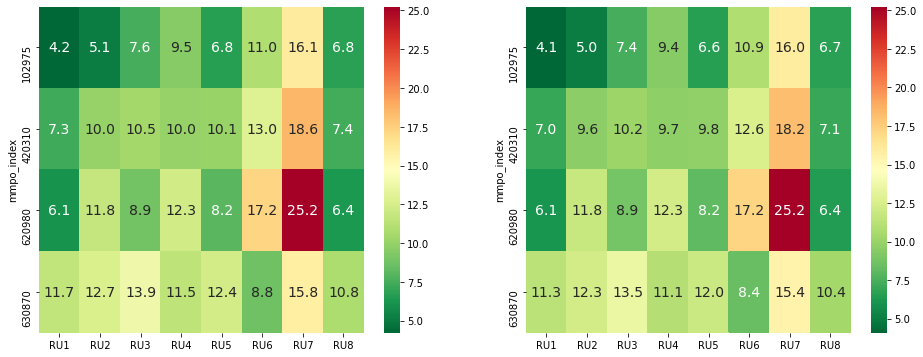

2020-11-11
--------------------------------------------------------------------------------


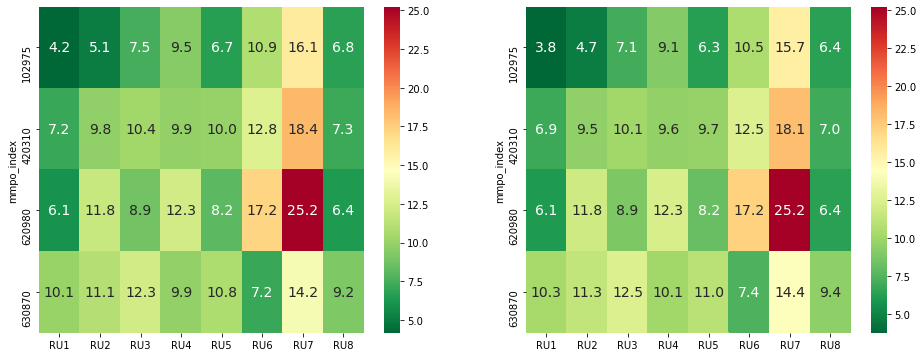

2020-11-12
--------------------------------------------------------------------------------


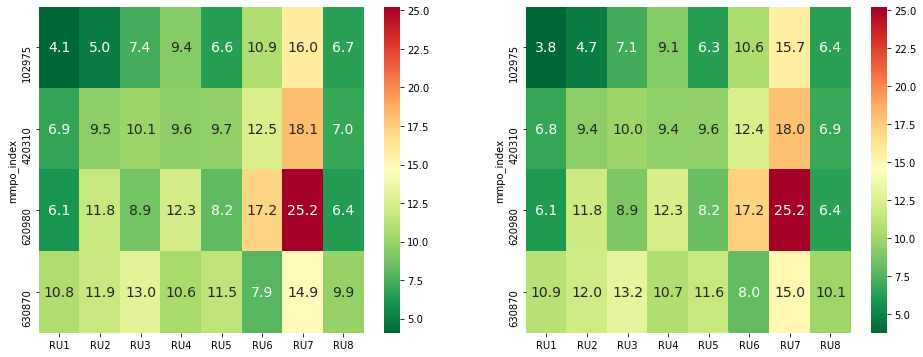

2020-11-13
--------------------------------------------------------------------------------


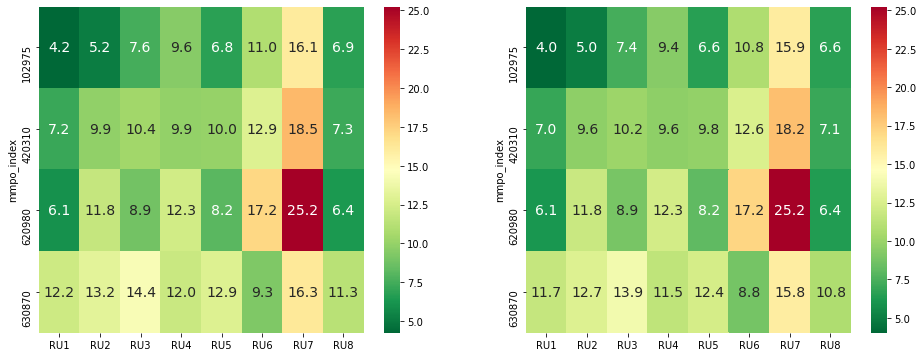

2020-11-14
--------------------------------------------------------------------------------


KeyboardInterrupt: 

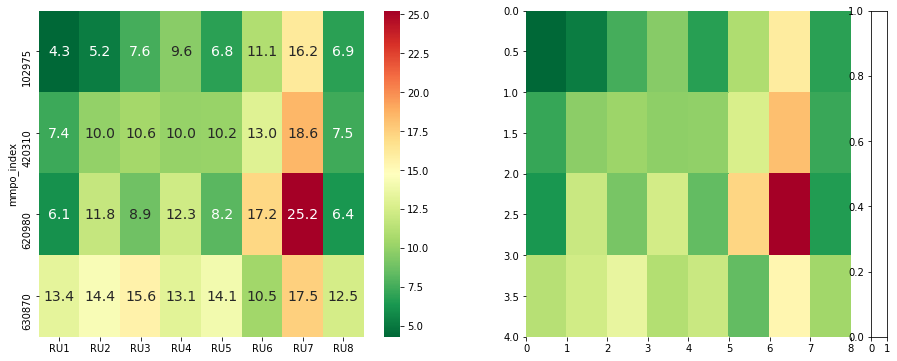

In [383]:
for i, date in zip(range(len(as_is_vol)), vl_by_days.index):
    print(date)
    print('-'*80)
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    new_time = pd.DataFrame(total_time_2(as_is_vol[i]).T,
                            columns=zone_names, index=mmpo_index) 
    new_time = new_time * (new_time > 0)
    sns.heatmap(new_time, cmap='RdYlGn_r', annot=True, fmt='.1f', annot_kws={"size": 14}, ax=axs[0]);
    
    new_time = pd.DataFrame( total_time_2(optimize_volumes_2[i]).T,
                            columns=zone_names, index=mmpo_index) 
    new_time = new_time * (new_time > 0)
    sns.heatmap(new_time, cmap='RdYlGn_r', annot=True, fmt='.1f', annot_kws={"size": 14}, ax=axs[1]);
    
    plt.show()

## Относительное изменение полного времени

2020-11-11
--------------------------------------------------------------------------------


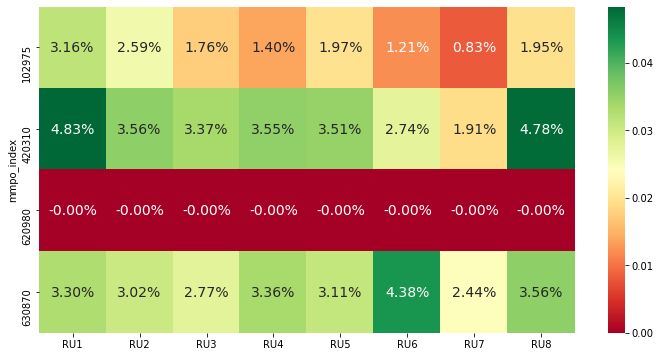

2020-11-12
--------------------------------------------------------------------------------


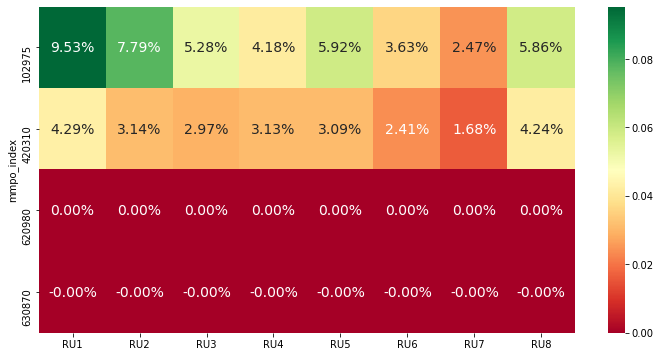

2020-11-13
--------------------------------------------------------------------------------


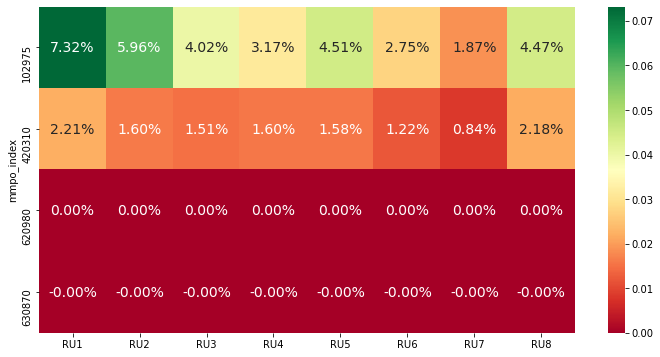

2020-11-14
--------------------------------------------------------------------------------


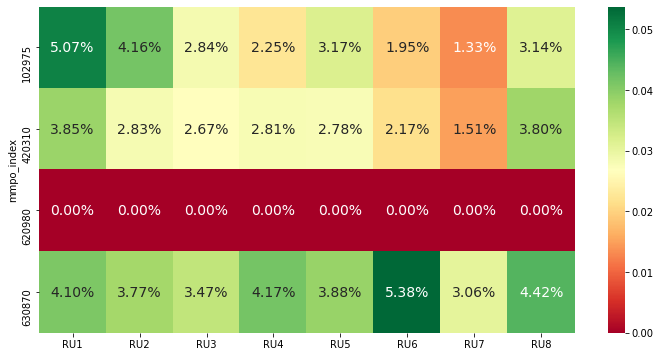

2020-11-15
--------------------------------------------------------------------------------


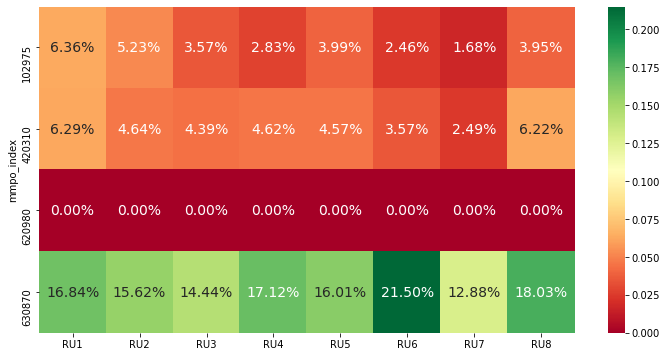

2020-11-16
--------------------------------------------------------------------------------


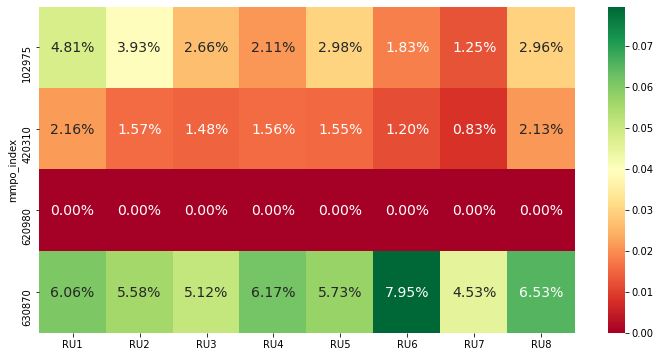

2020-11-17
--------------------------------------------------------------------------------


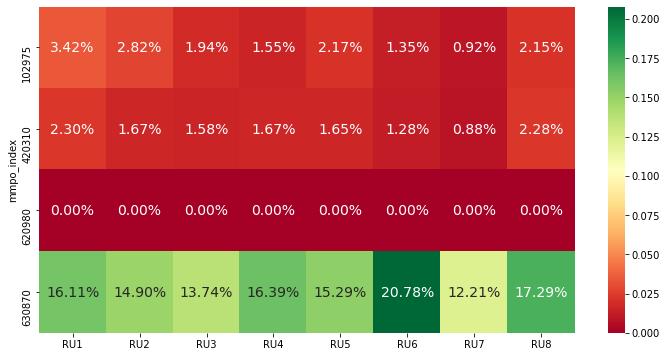

2020-11-18
--------------------------------------------------------------------------------


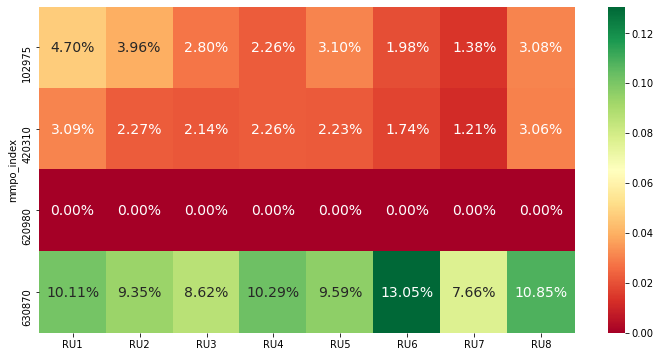

2020-11-19
--------------------------------------------------------------------------------


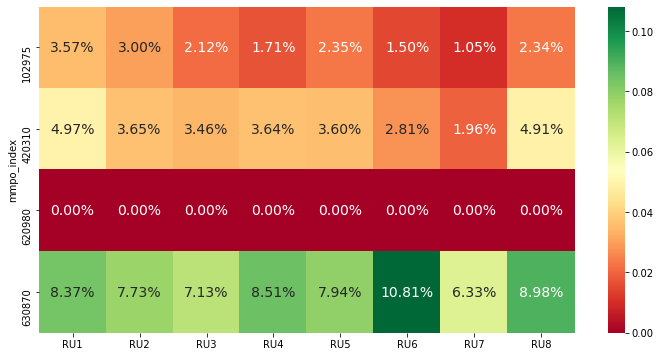

2020-11-20
--------------------------------------------------------------------------------


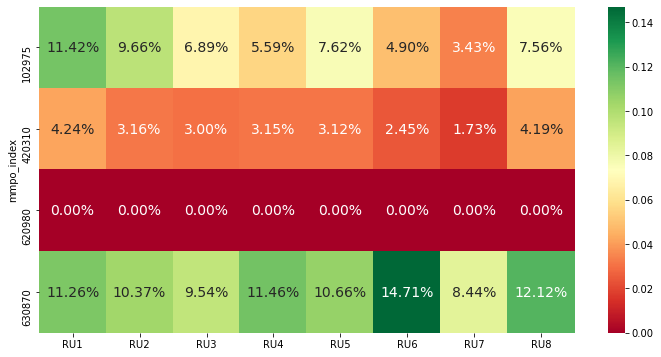

2020-11-21
--------------------------------------------------------------------------------


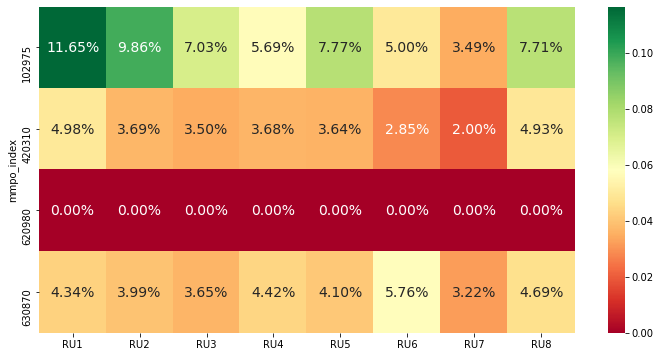

2020-11-22
--------------------------------------------------------------------------------


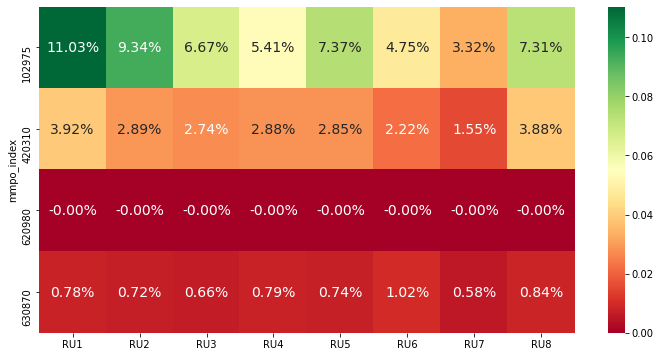

2020-11-23
--------------------------------------------------------------------------------


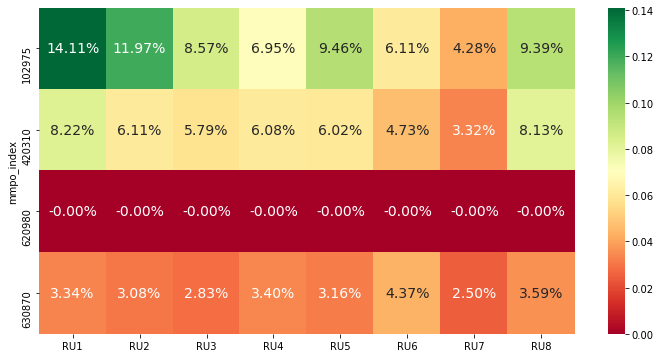

2020-11-24
--------------------------------------------------------------------------------


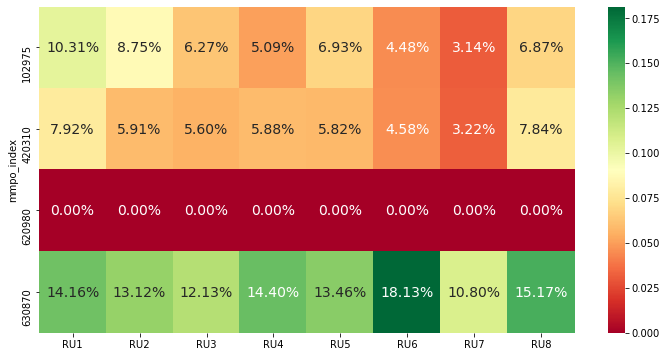

2020-11-25
--------------------------------------------------------------------------------


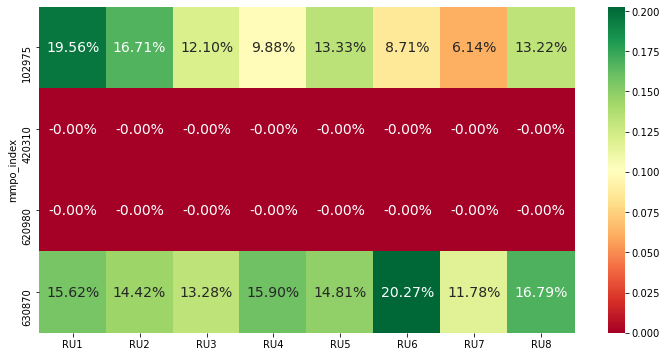

2020-11-26
--------------------------------------------------------------------------------


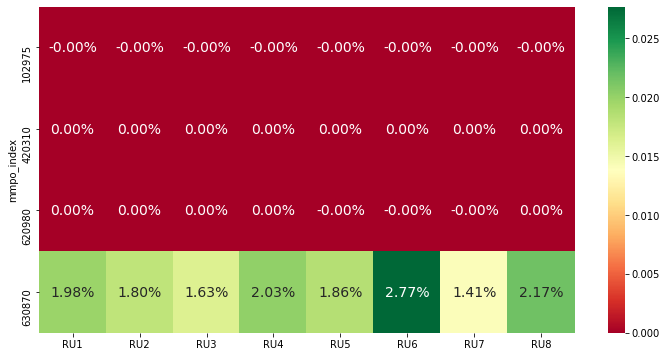

In [331]:
for i, date in zip(range(len(as_is_vol)), vl_by_days.index):
    print(date)
    print('-'*80)
    plt.figure(figsize=(12, 6))
    new_time = pd.DataFrame((total_time_2(as_is_vol[i]).T - total_time_2(optimize_volumes_2[i]).T)\
                            /total_time_2(as_is_vol[i]).T
                            , columns=zone_names, index=mmpo_index) 
    new_time = new_time * (new_time > 0)
    sns.heatmap(new_time, cmap='RdYlGn', annot=True, fmt='.2%', annot_kws={"size": 14})
    plt.show()

## Время обработки в ММПО при фактическом и оптимизированном распределении потоков

2020-11-11
--------------------------------------------------------------------------------


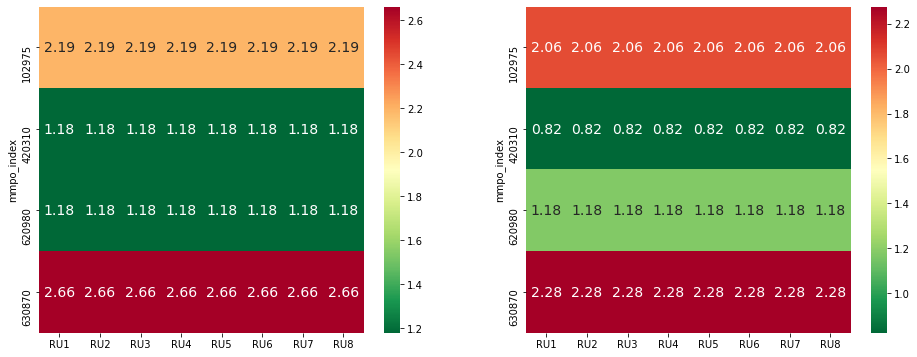

2020-11-12
--------------------------------------------------------------------------------


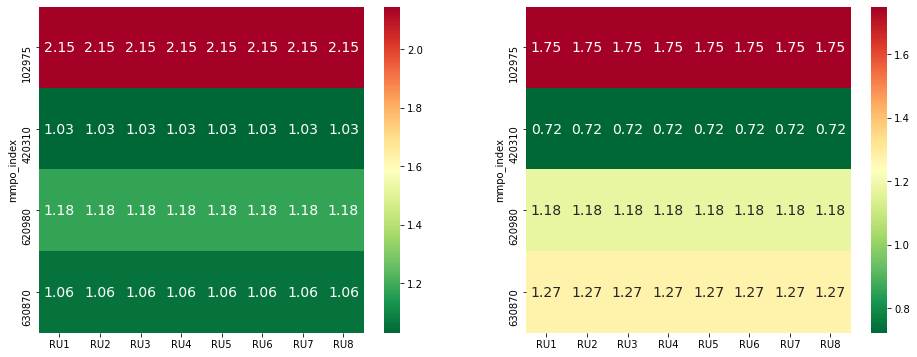

2020-11-13
--------------------------------------------------------------------------------


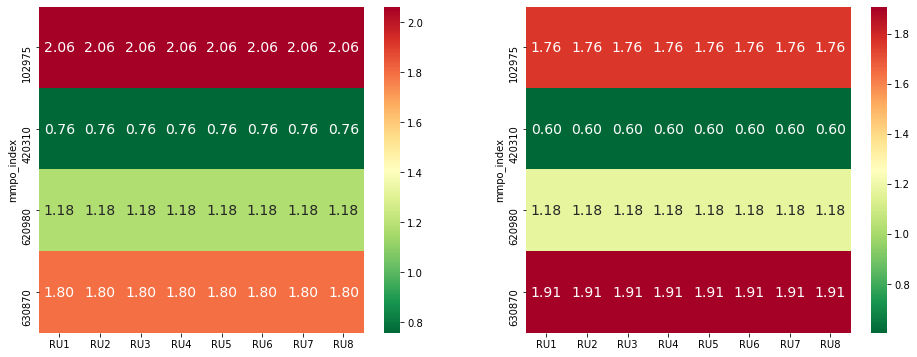

2020-11-14
--------------------------------------------------------------------------------


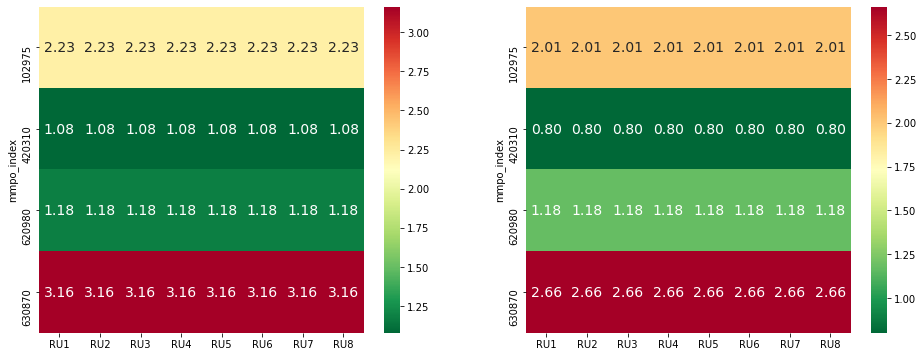

2020-11-15
--------------------------------------------------------------------------------


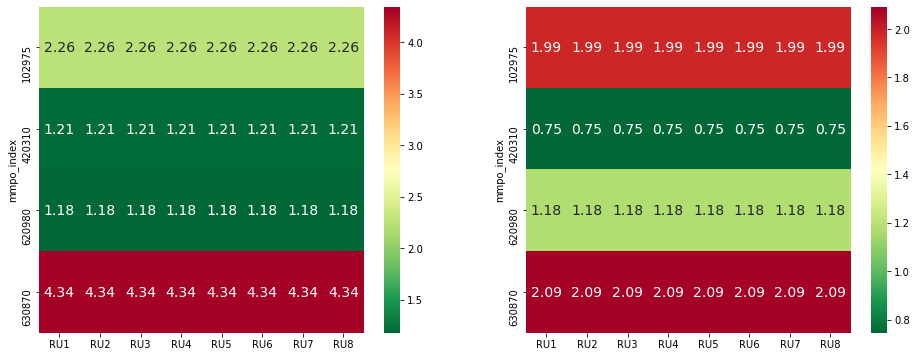

2020-11-16
--------------------------------------------------------------------------------


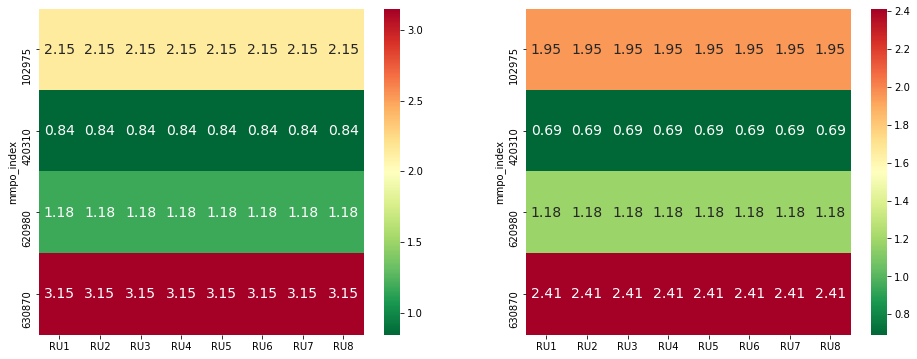

2020-11-17
--------------------------------------------------------------------------------


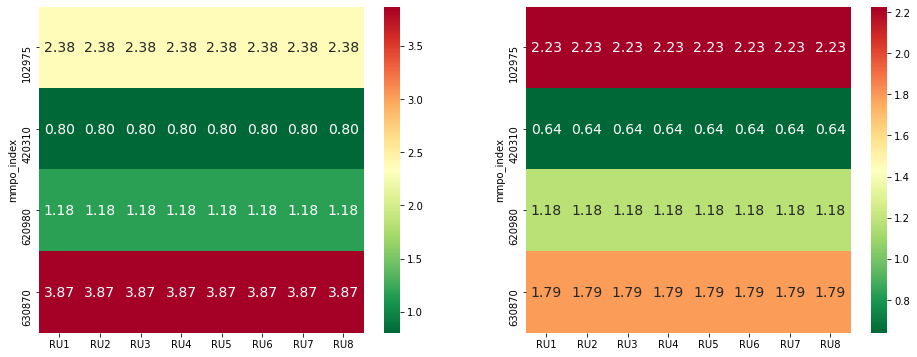

2020-11-18
--------------------------------------------------------------------------------


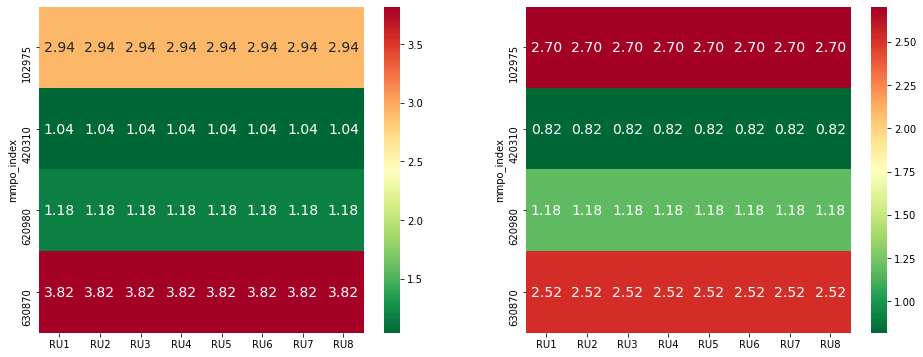

2020-11-19
--------------------------------------------------------------------------------


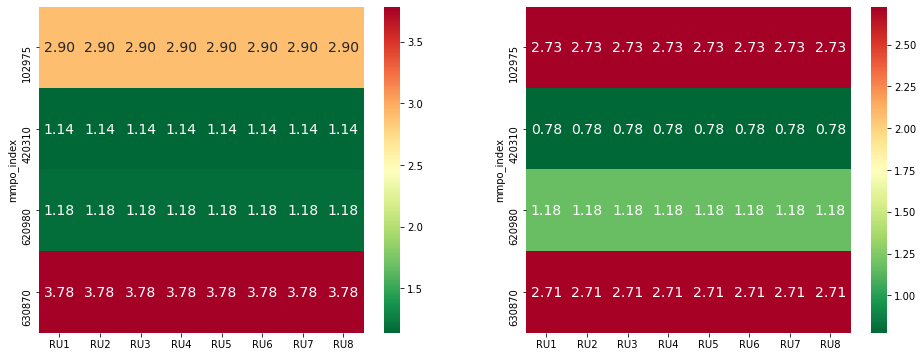

2020-11-20
--------------------------------------------------------------------------------


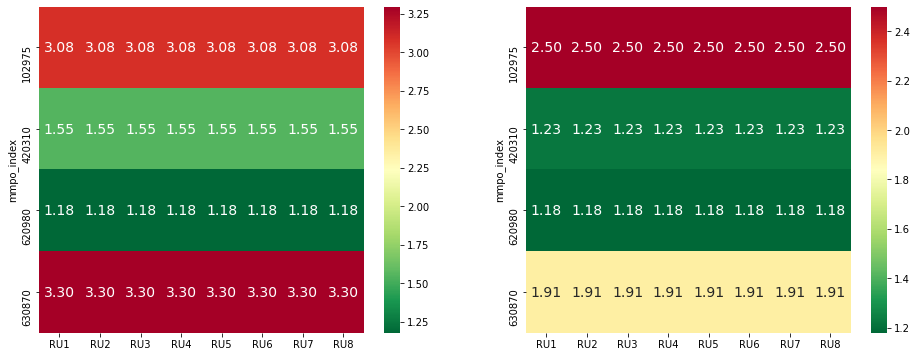

2020-11-21
--------------------------------------------------------------------------------


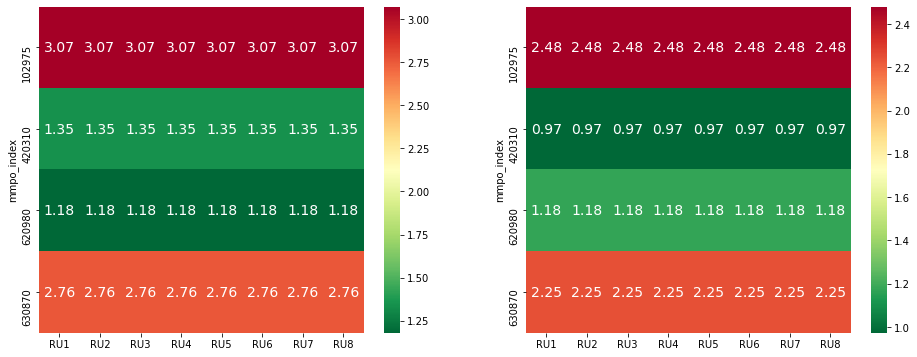

2020-11-22
--------------------------------------------------------------------------------


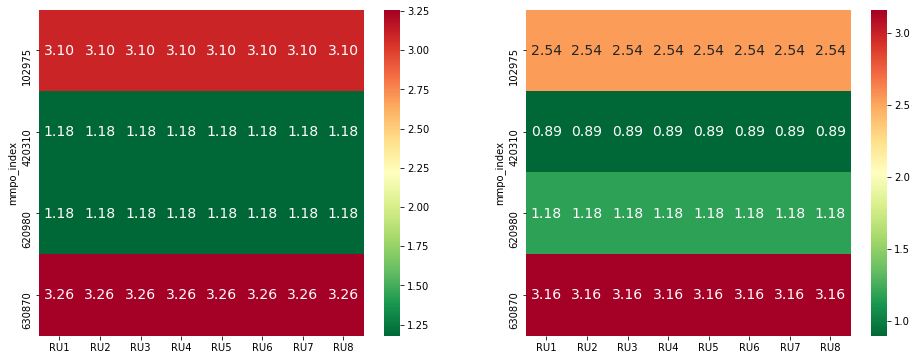

2020-11-23
--------------------------------------------------------------------------------


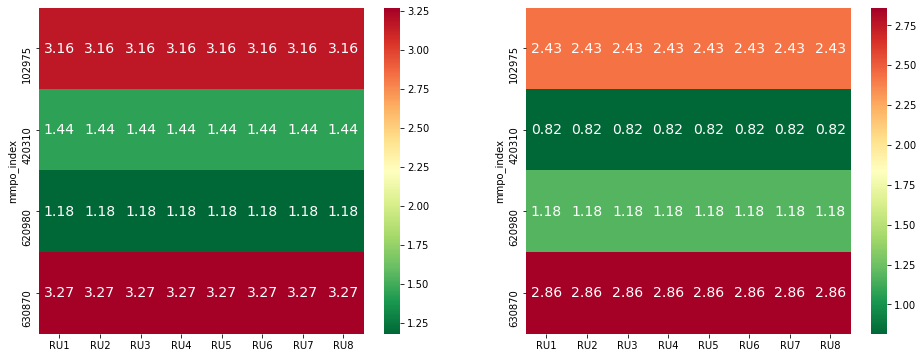

2020-11-24
--------------------------------------------------------------------------------


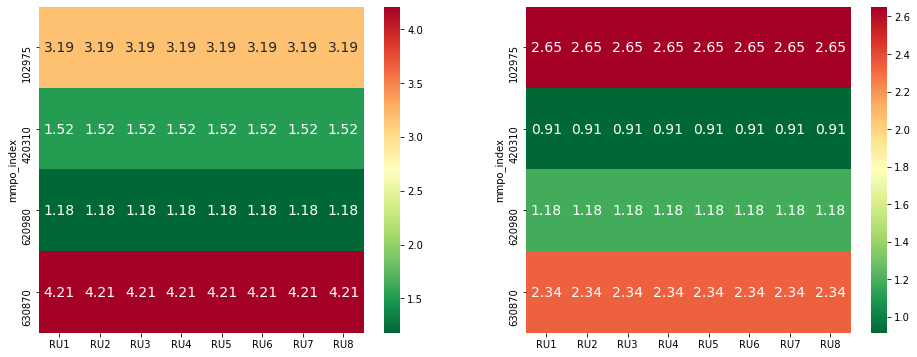

2020-11-25
--------------------------------------------------------------------------------


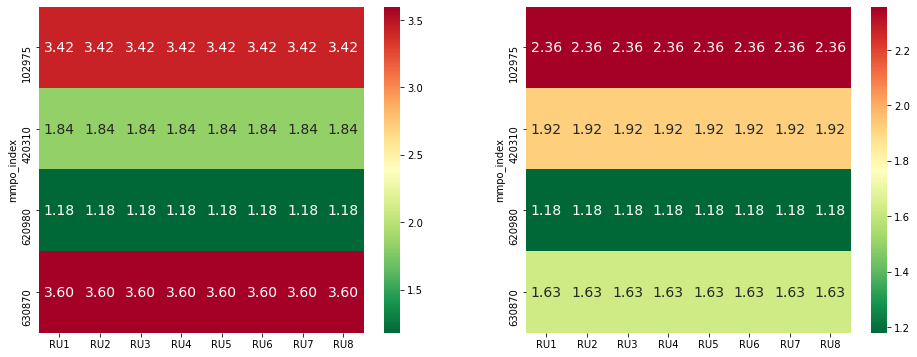

2020-11-26
--------------------------------------------------------------------------------


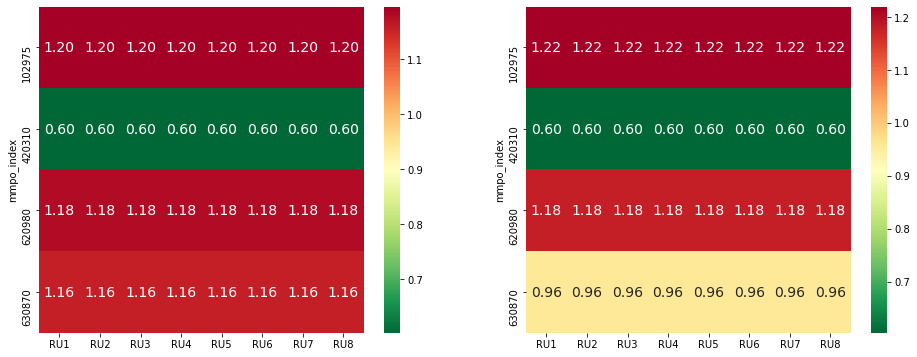

In [335]:
for i, date in zip(range(len(as_is_vol)), vl_by_days.index):
    print(date)
    print('-'*80)
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    new_time = pd.DataFrame(mmpo_time_2(as_is_vol[i]).T,
                            columns=zone_names, index=mmpo_index) 
    new_time = new_time * (new_time > 0)
    sns.heatmap(new_time, cmap='RdYlGn_r', annot=True, fmt='.2f', annot_kws={"size": 14}, ax=axs[0]);
    
    new_time = pd.DataFrame( mmpo_time_2(optimize_volumes_2[i]).T,
                            columns=zone_names, index=mmpo_index) 
    new_time = new_time * (new_time > 0)
    sns.heatmap(new_time, cmap='RdYlGn_r', annot=True, fmt='.2f', annot_kws={"size": 14}, ax=axs[1]);
    
    plt.show()

## Относительное изменение времени обработки в ММПО

2020-11-11
--------------------------------------------------------------------------------


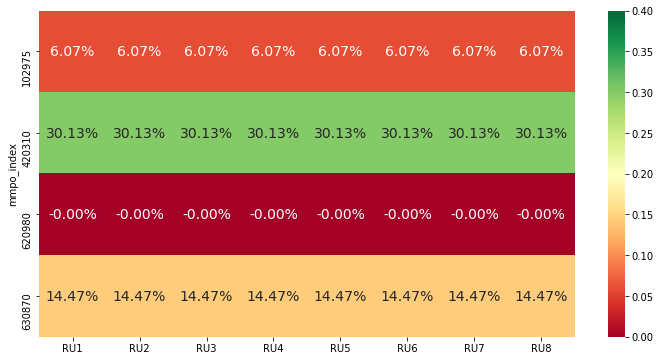

2020-11-12
--------------------------------------------------------------------------------


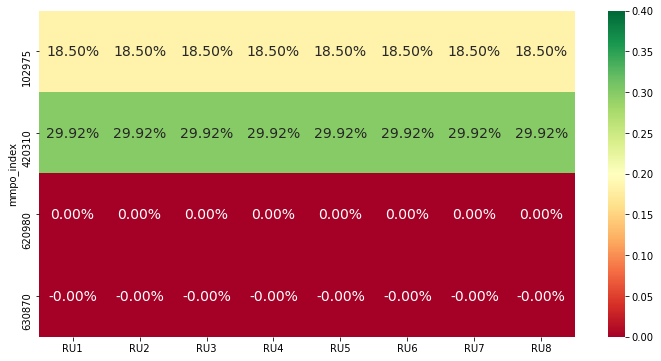

2020-11-13
--------------------------------------------------------------------------------


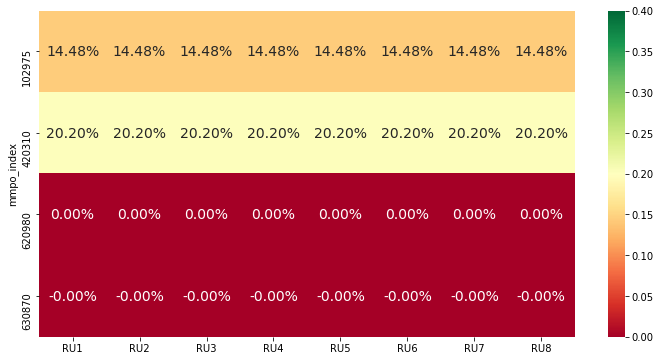

2020-11-14
--------------------------------------------------------------------------------


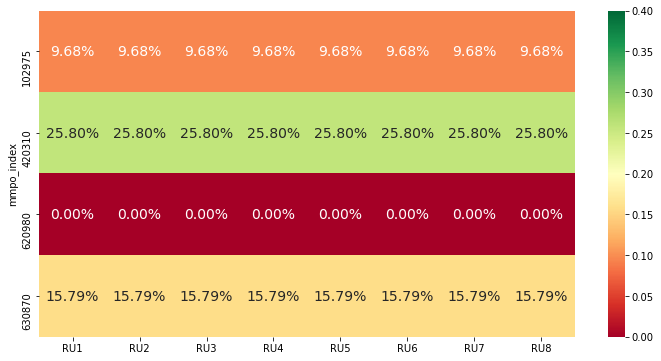

2020-11-15
--------------------------------------------------------------------------------


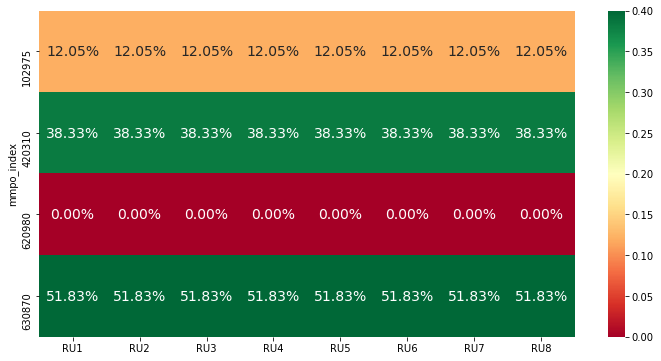

2020-11-16
--------------------------------------------------------------------------------


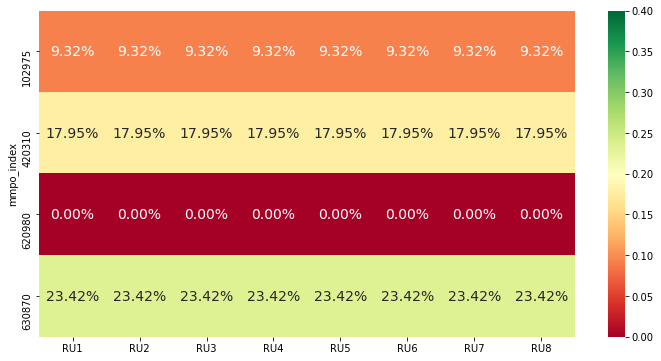

2020-11-17
--------------------------------------------------------------------------------


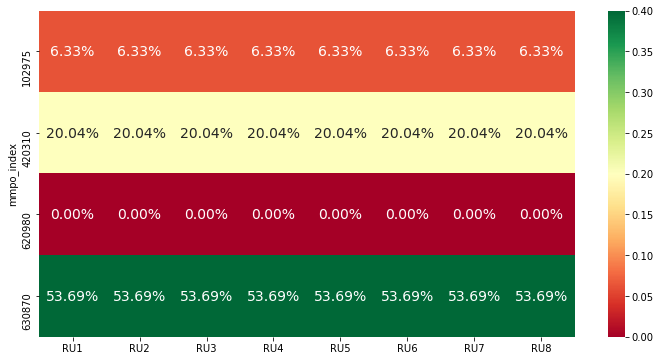

2020-11-18
--------------------------------------------------------------------------------


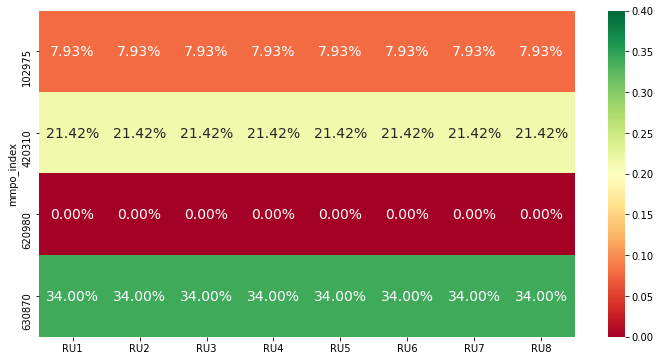

2020-11-19
--------------------------------------------------------------------------------


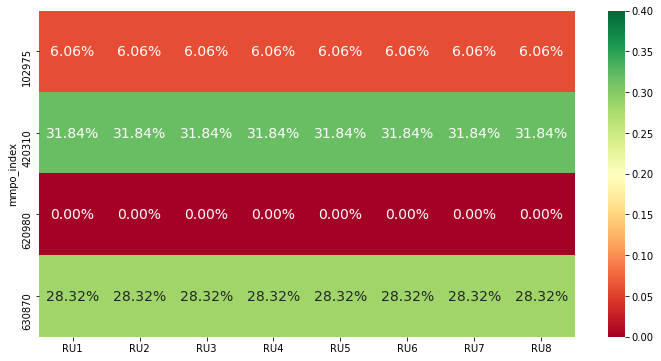

2020-11-20
--------------------------------------------------------------------------------


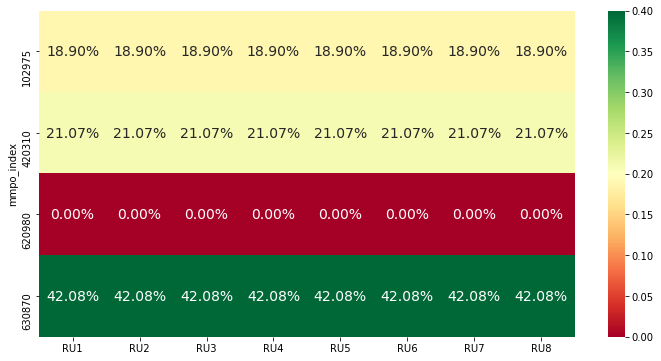

2020-11-21
--------------------------------------------------------------------------------


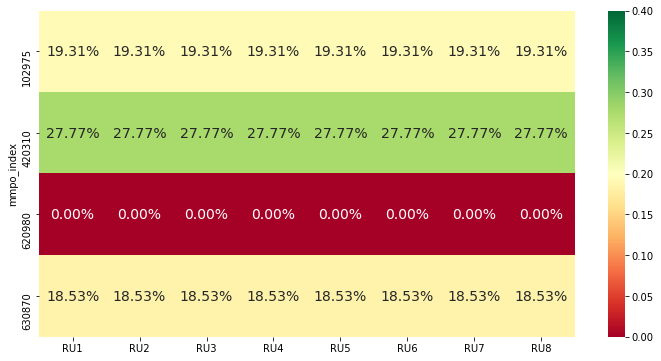

2020-11-22
--------------------------------------------------------------------------------


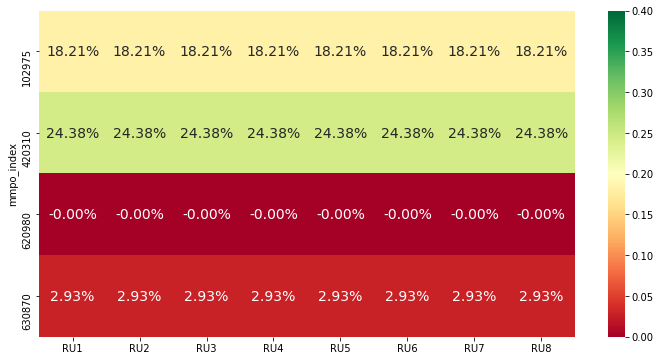

2020-11-23
--------------------------------------------------------------------------------


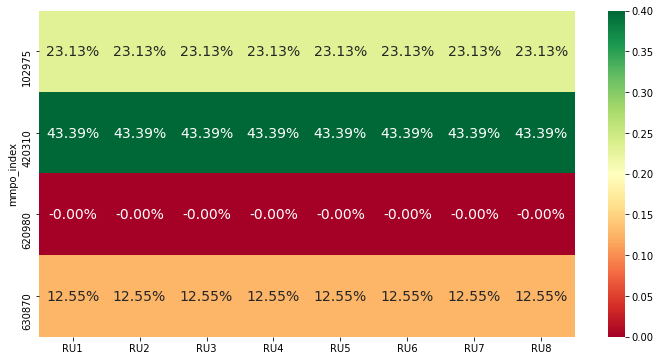

2020-11-24
--------------------------------------------------------------------------------


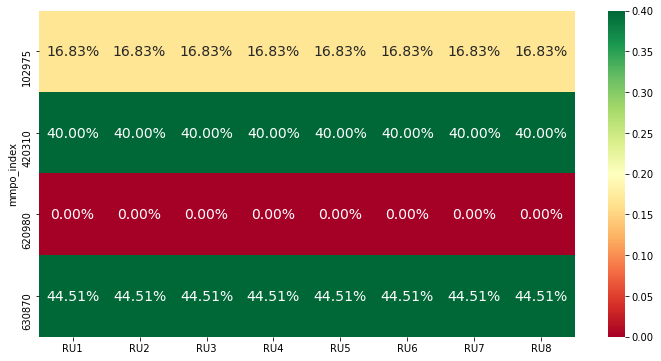

2020-11-25
--------------------------------------------------------------------------------


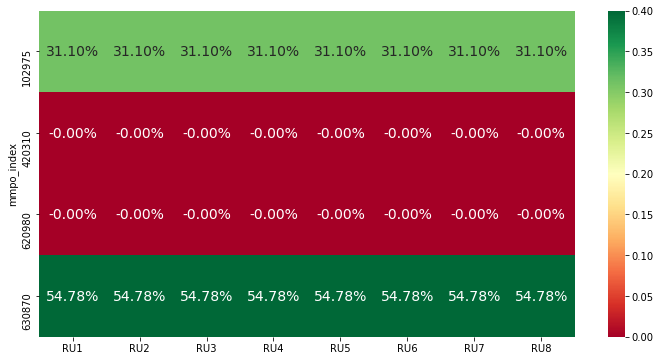

2020-11-26
--------------------------------------------------------------------------------


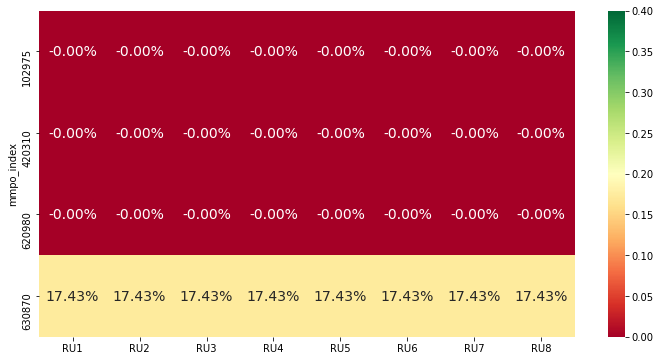

In [341]:
for i, date in zip(range(len(as_is_vol)), vl_by_days.index):
    print(date)
    print('-'*80)
    plt.figure(figsize=(12, 6))
    new_time = pd.DataFrame((mmpo_time_2(as_is_vol[i]).T - mmpo_time_2(optimize_volumes_2[i]).T) / mmpo_time_2(as_is_vol[i]).T,
                            columns=zone_names, index=mmpo_index) 
    new_time = new_time * (new_time > 0)
    sns.heatmap(new_time, cmap='RdYlGn', annot=True, fmt='.2%', vmax = 0.4, annot_kws={"size": 14});

    
    plt.show()

In [293]:
time_by_day = []
for vol in optimize_volumes:
    time_by_day.append(pd.DataFrame(mmpo_time_2(optimize_volumes_2[0]).T, columns=zone_names, index=mmpo_index))

In [294]:
df_tbd = []
for frame, day in zip(time_by_day,  vl_by_days.index):
    temp = frame.unstack().to_frame().reset_index().rename(columns={'level_0':'zone', 0:'total_time'})
    temp['day'] = day
    df_tbd.append(temp)
    
df_tbd = pd.concat(df_tbd)
df_tbd['day'] = pd.to_datetime(df_tbd['day'])

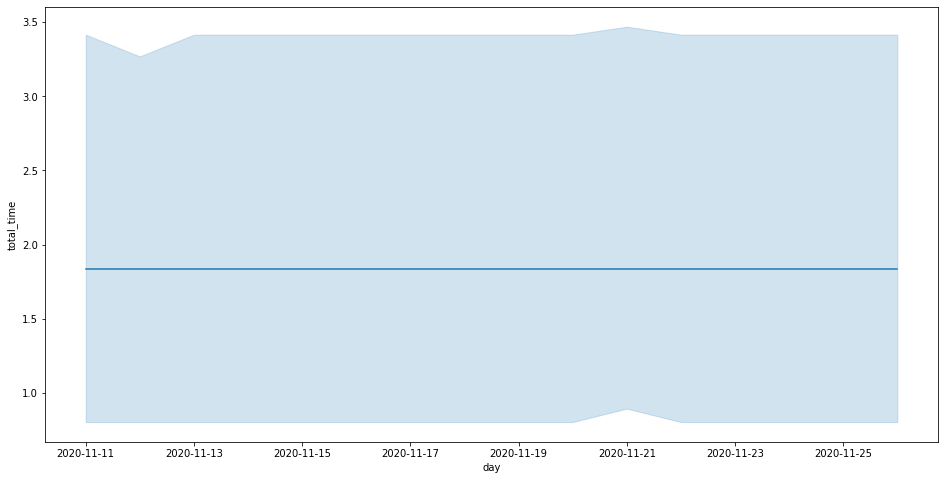

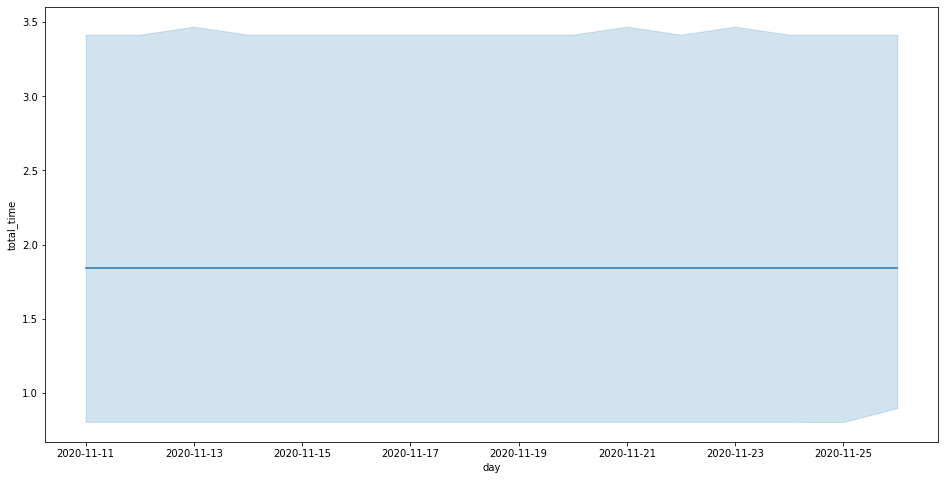

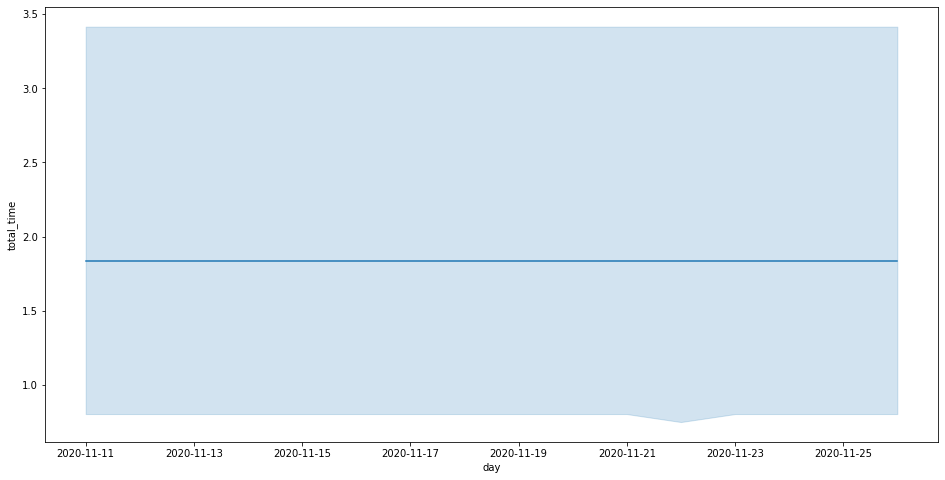

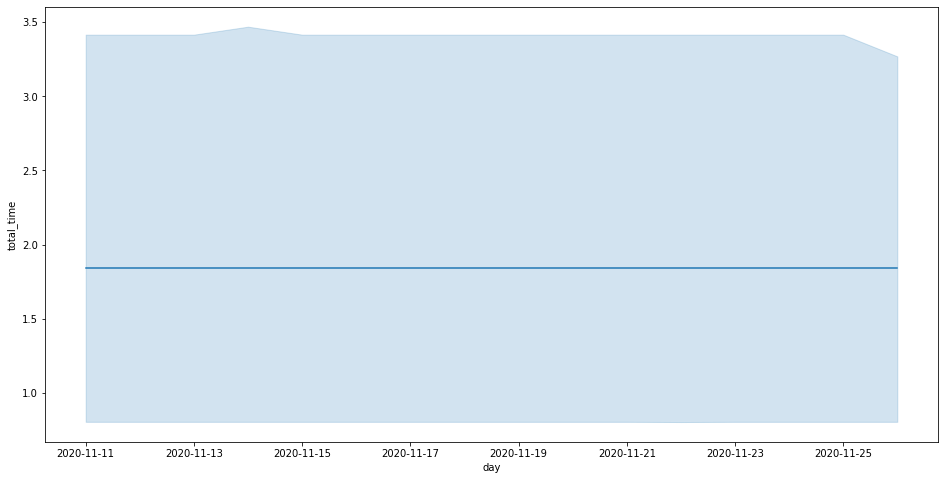

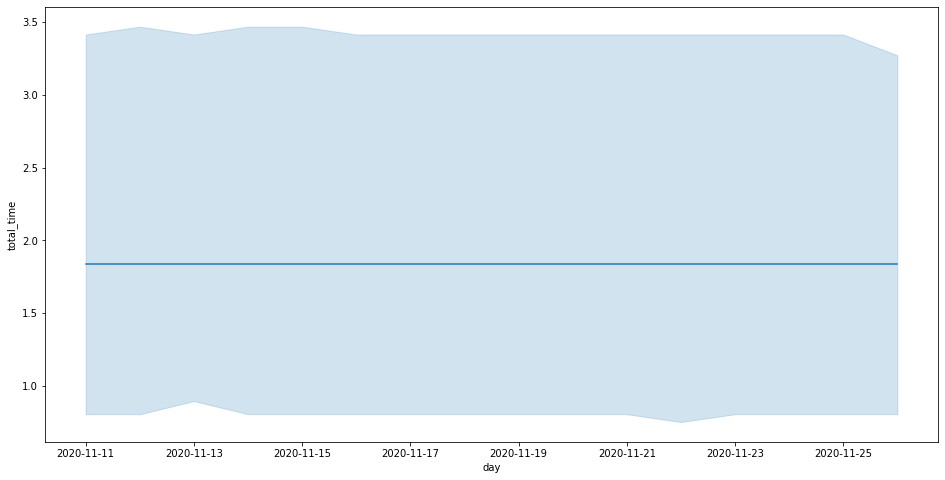

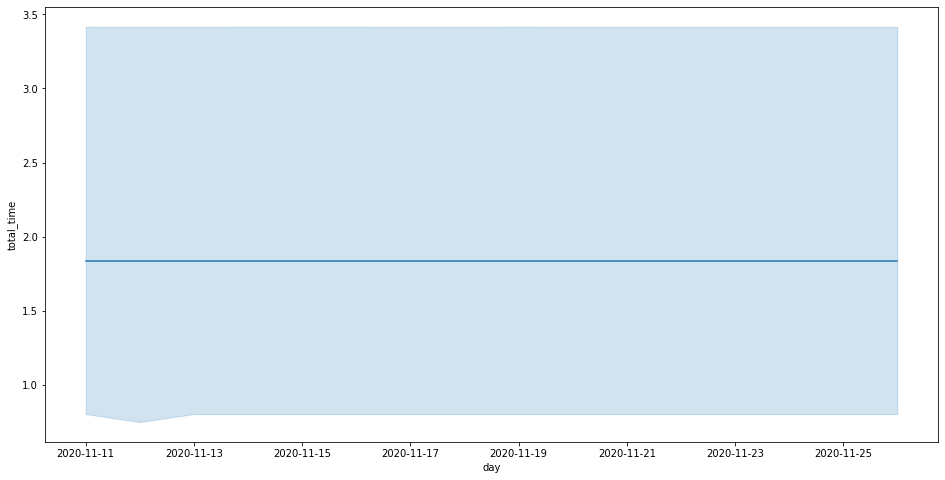

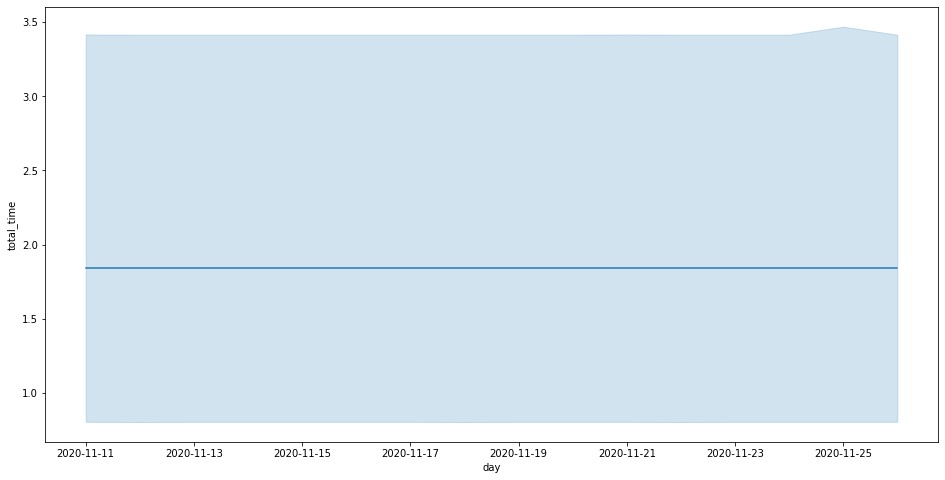

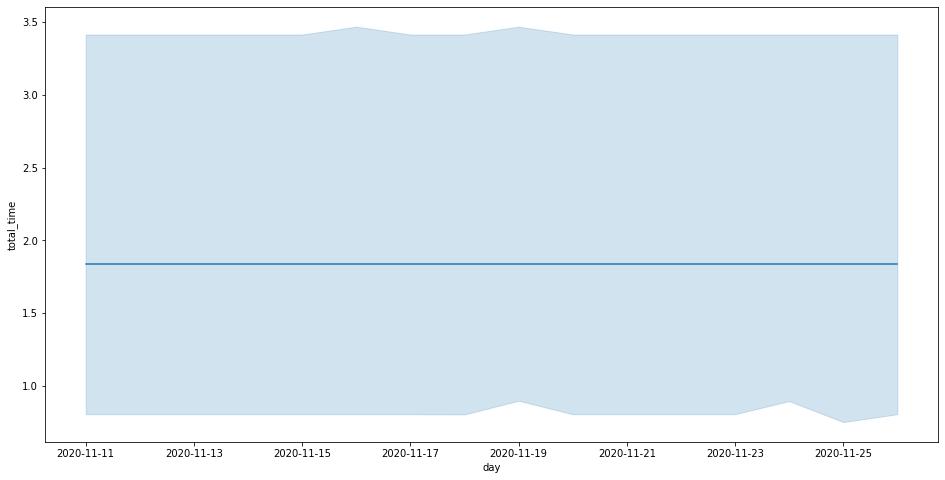

In [300]:
for z in df_tbd['zone'].unique():
    plt.figure(figsize=(16,8))
    sns.lineplot('day', 'total_time', data=df_tbd[df_tbd['zone'] == z])
    plt.show()

## Изменение структуры потоков

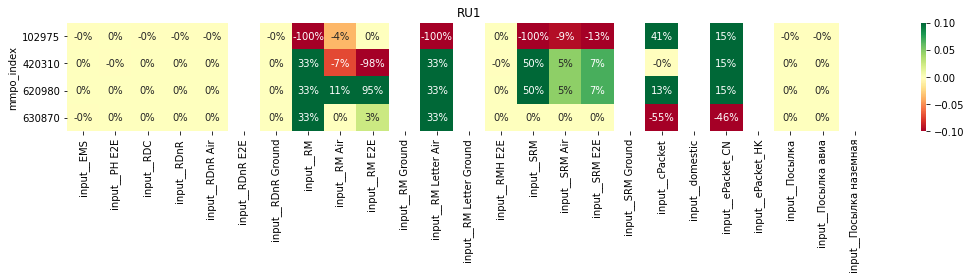

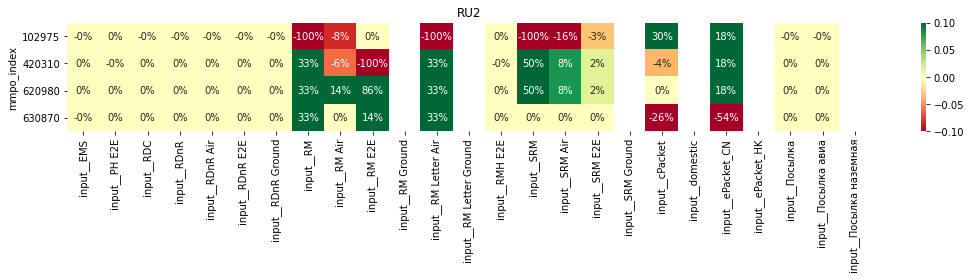

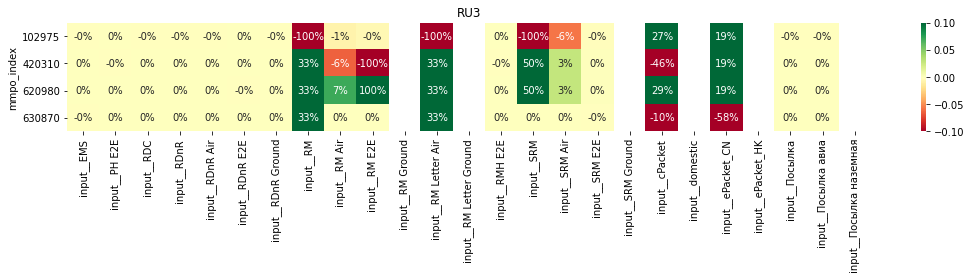

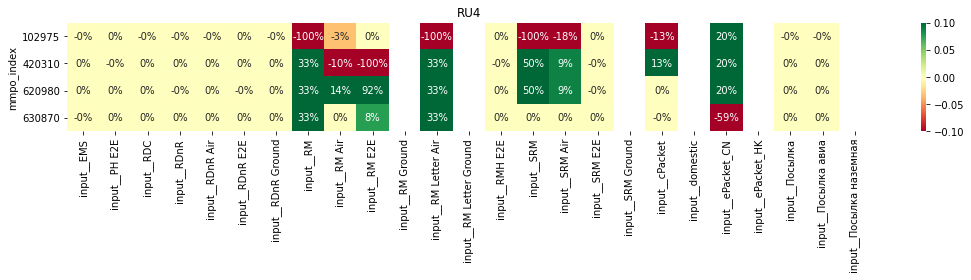

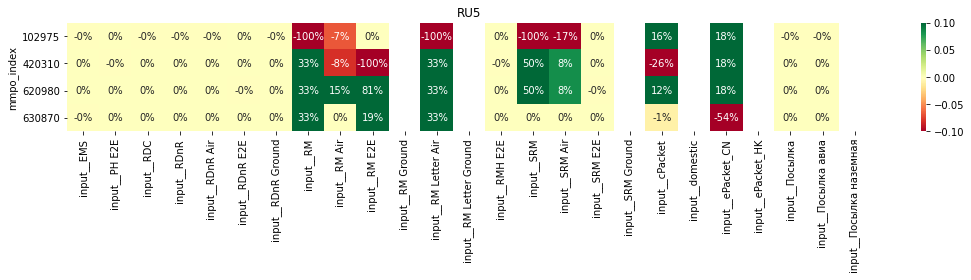

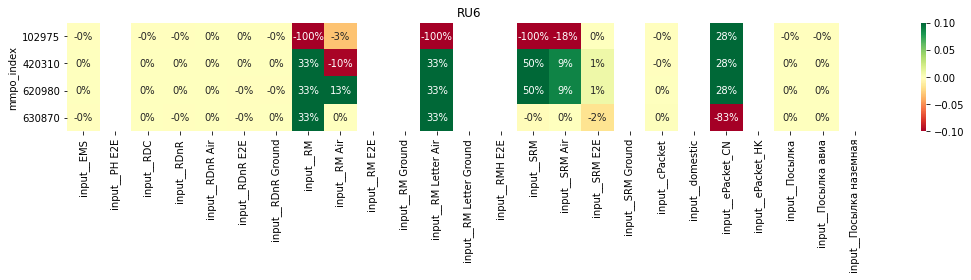

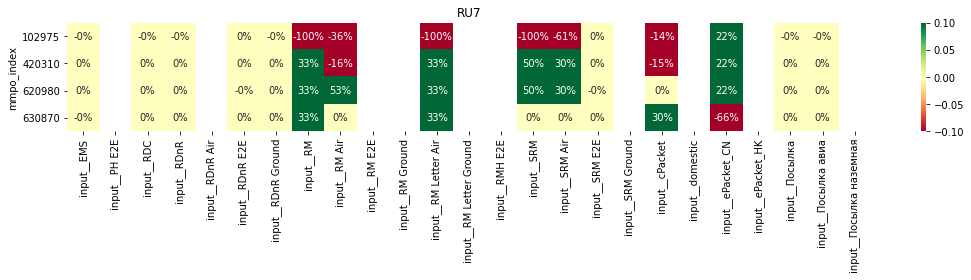

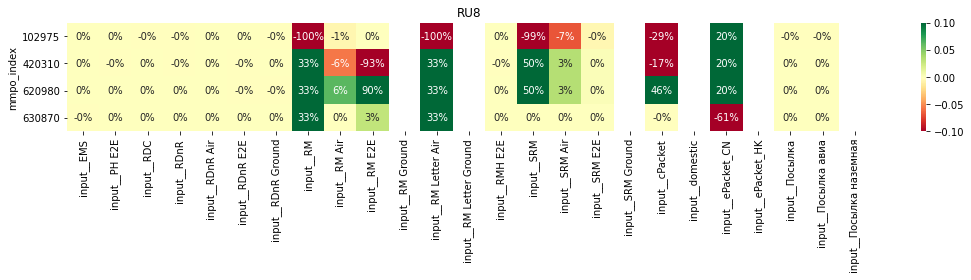

In [337]:
for name, x0, x in zip(zone_names, as_is_vol[-3], optimize_volumes_2[-3]):
    plot_rel_change(x0, x, name)
    plt.show()